# 1. Import

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modèles de classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier

# Métriques d'évaluation
from sklearn.metrics import (precision_recall_curve, recall_score, precision_score, 
                           f1_score, confusion_matrix, classification_report, 
                           roc_auc_score)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

# Optimisation des hyperparamètres
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Exploratory data analysis

## EDA - extrait_sirh.csv

Ce fichier **extrait_sirh.csv** contient les informations concernant les employés (âge, poste, ancienneté, sociodémographiques, etc.)

- 1470 lignes et 12 colonnes, aucunes valeurs manquantes.

- 4 colonnes catégorielles

- 8 colonnes numériques (int64)

- La colonne `id_employee` nous servira de clé primaire 

In [3]:
df_sirh = pd.read_csv('extrait_sirh.csv')

In [4]:
df_sirh.head(10)

id_employee  age genre  revenu_mensuel statut_marital departement  \
0            1   41     F            5993    Célibataire  Commercial   
1            2   49     M            5130       Marié(e)  Consulting   
2            4   37     M            2090    Célibataire  Consulting   
3            5   33     F            2909       Marié(e)  Consulting   
4            7   27     M            3468       Marié(e)  Consulting   
5            8   32     M            3068    Célibataire  Consulting   
6           10   59     F            2670       Marié(e)  Consulting   
7           11   30     M            2693     Divorcé(e)  Consulting   
8           12   38     M            9526    Célibataire  Consulting   
9           13   36     M            5237       Marié(e)  Consulting   

                    poste  nombre_experiences_precedentes  \
0        Cadre Commercial                               8   
1  Assistant de Direction                               1   
2              Consultant                               6   
3  Assistant de Direction                               1   
4              Consultant                               9   
5              Consultant                               0   
6              Consultant                               4   
7              Consultant                               1   
8               Tech Lead                               0   
9                 Manager                               6   

   nombre_heures_travailless  annee_experience_totale  \
0                         80                        8   
1                         80                       10   
2                         80                        7   
3                         80                        8   
4                         80                        6   
5                         80                        8   
6                         80                       12   
7                         80                        1   
8                         80                       10   
9                         80                       17   

   annees_dans_l_entreprise  annees_dans_le_poste_actuel  
0                         6                            4  
1                        10                            7  
2                         0                            0  
3                         8                            7  
4                         2                            2  
5                         7                            7  
6                         1                            0  
7                         1                            0  
8                         9                            7  
9                         7                            7

In [5]:
df_sirh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


In [6]:
# On vérifie qu'il n'y a pas de doublons dans l'identifiant des employés
df_sirh["id_employee"].duplicated().sum()

np.int64(0)

In [7]:
# Statistiques descriptives des colonnes numériques
num_cols = df_sirh.select_dtypes(include=['number']).columns.drop('id_employee')
df_sirh[num_cols].describe().T

count         mean          std     min  \
age                             1470.0    36.923810     9.135373    18.0   
revenu_mensuel                  1470.0  6502.931293  4707.956783  1009.0   
nombre_experiences_precedentes  1470.0     2.693197     2.498009     0.0   
nombre_heures_travailless       1470.0    80.000000     0.000000    80.0   
annee_experience_totale         1470.0    11.279592     7.780782     0.0   
annees_dans_l_entreprise        1470.0     7.008163     6.126525     0.0   
annees_dans_le_poste_actuel     1470.0     4.229252     3.623137     0.0   

                                   25%     50%     75%      max  
age                               30.0    36.0    43.0     60.0  
revenu_mensuel                  2911.0  4919.0  8379.0  19999.0  
nombre_experiences_precedentes     1.0     2.0     4.0      9.0  
nombre_heures_travailless         80.0    80.0    80.0     80.0  
annee_experience_totale            6.0    10.0    15.0     40.0  
annees_dans_l_entreprise           3.0     5.0     9.0     40.0  
annees_dans_le_poste_actuel        2.0     3.0     7.0     18.0

- Colonne `id_employee` : les statistiques pas pertinent
- Colonne `age` : range (18 ; 60) ans, moyenne proche de la médiane (36,92 VS 36) -> quasi-symétrie
- Colonne `revenu_mensuel` : range (1009 ; 19999), moyenne plus élevé que la médiane (6502 VS 4919) -> asymétrie
- Colonne `nombre_experiences_precedentes` : range (0 ; 9), moyenne et médiane prochent -> quasi-symétrie. Du débutant au Senior
- Colonne `nombre_heures_travailless` : tout le monde travail 80 heures par semaines. C'est une constate
- Colonne `annee_experience_totale` : range (0 ; 40), moyenne proche de la médiane -> quasi-symétrie. Du débutant au Senior
- Colonne `annees_dans_l_entreprise` : range (0 ; 40), asymétrie, du nouveau au senior
- Colonne `annees_dans_le_poste_actuel` : range (0 ; 18), asymétrie, de débutant à l'expert

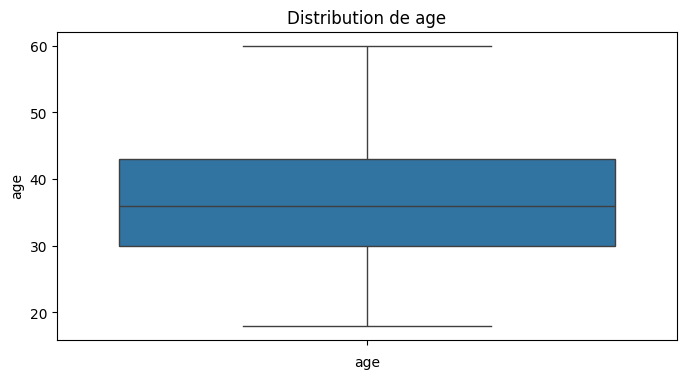

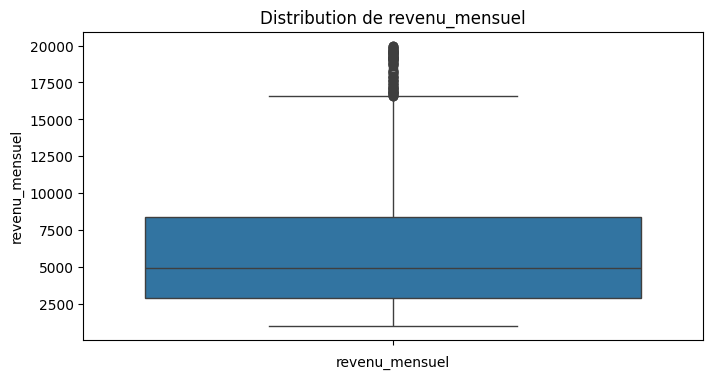

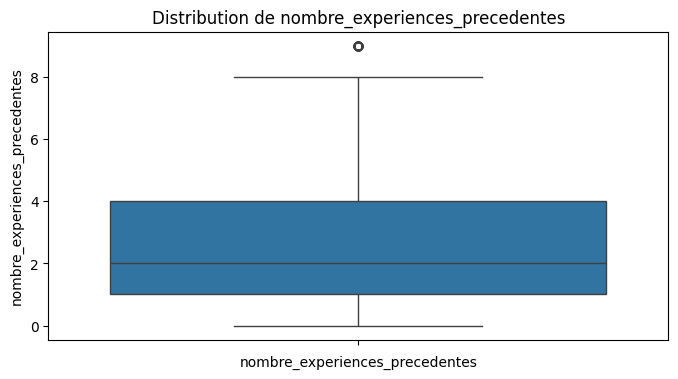

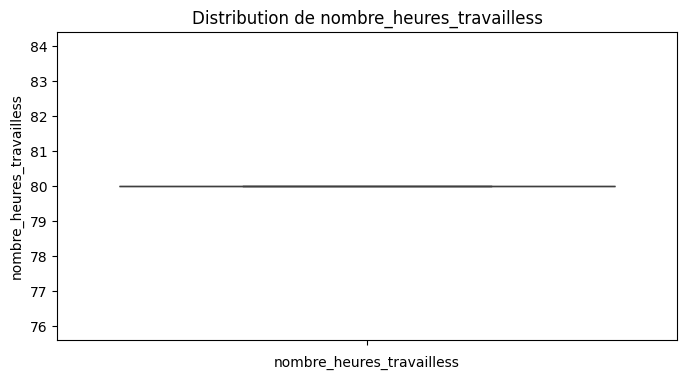

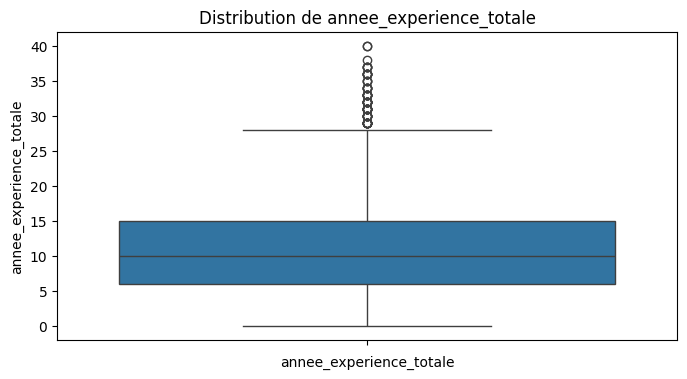

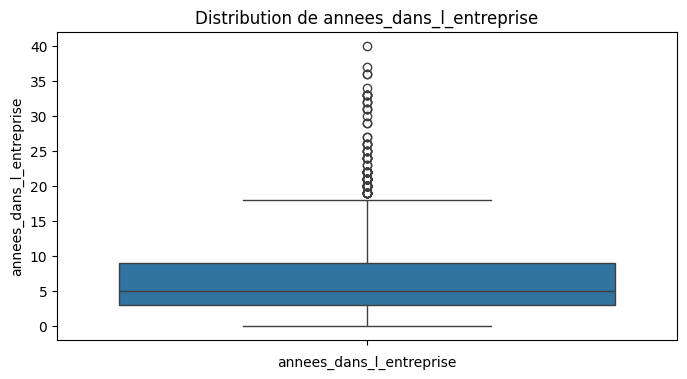

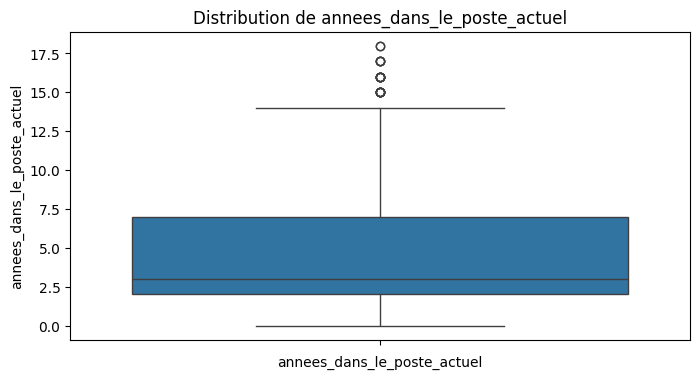

In [8]:
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(df_sirh[col])
    plt.xlabel(col)
    plt.title(f'Distribution de {col}')
    plt.show()

In [9]:
cat_cols = df_sirh.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(f"Colonne '{col}' :")
    print(df_sirh[col].value_counts())
    print("\n")

Colonne 'genre' :
genre
M    882
F    588
Name: count, dtype: int64


Colonne 'statut_marital' :
statut_marital
Marié(e)       673
Célibataire    470
Divorcé(e)     327
Name: count, dtype: int64


Colonne 'departement' :
departement
Consulting             961
Commercial             446
Ressources Humaines     63
Name: count, dtype: int64


Colonne 'poste' :
poste
Cadre Commercial           326
Assistant de Direction     292
Consultant                 259
Tech Lead                  145
Manager                    131
Senior Manager             102
Représentant Commercial     83
Directeur Technique         80
Ressources Humaines         52
Name: count, dtype: int64




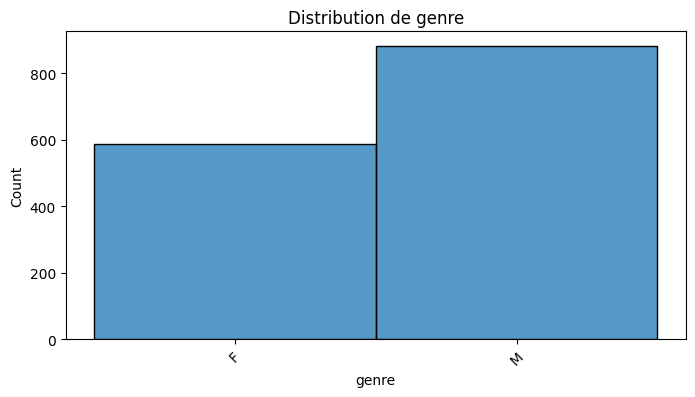

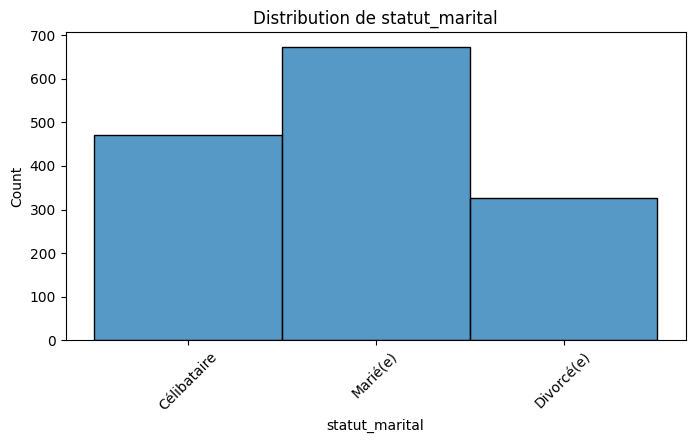

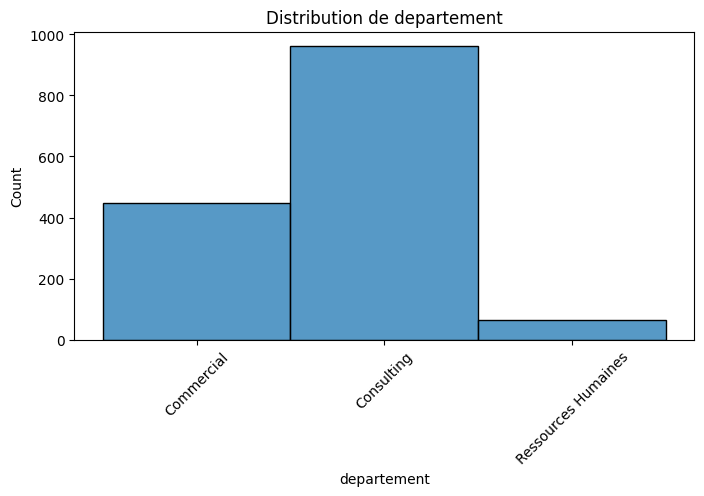

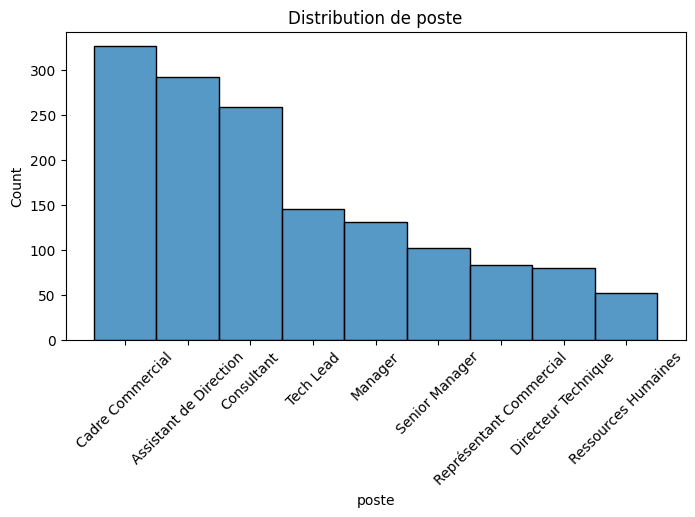

In [10]:
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df_sirh[col])
    plt.xlabel(col)
    plt.title(f'Distribution de {col}')
    plt.xticks(rotation=45)
    plt.show()

- Colonne `genre` : il y a plus d'homme (60%) que de femme (40%)
- Colonne `statut_marital` : 45,78% des employés sont mariés, les autres sont soit célibataires (31,97%), soit divorcés (22,25%)
- Colonne `departement` : Conslting (65,37%), Commercial (30,35) et RH (4,28%)
- Colonne `poste` : 9 postes : Cadre Commercial (22,18%), Assistant de Direction (19,86%), Consultant (17,62%), Tech Lead (9,86%), Manager (8,91%), Senior Manager (6,94%), Représentant Commercial (5,65%), Directeur Technique (5,44%) et Ressources Humaines (3,54%)

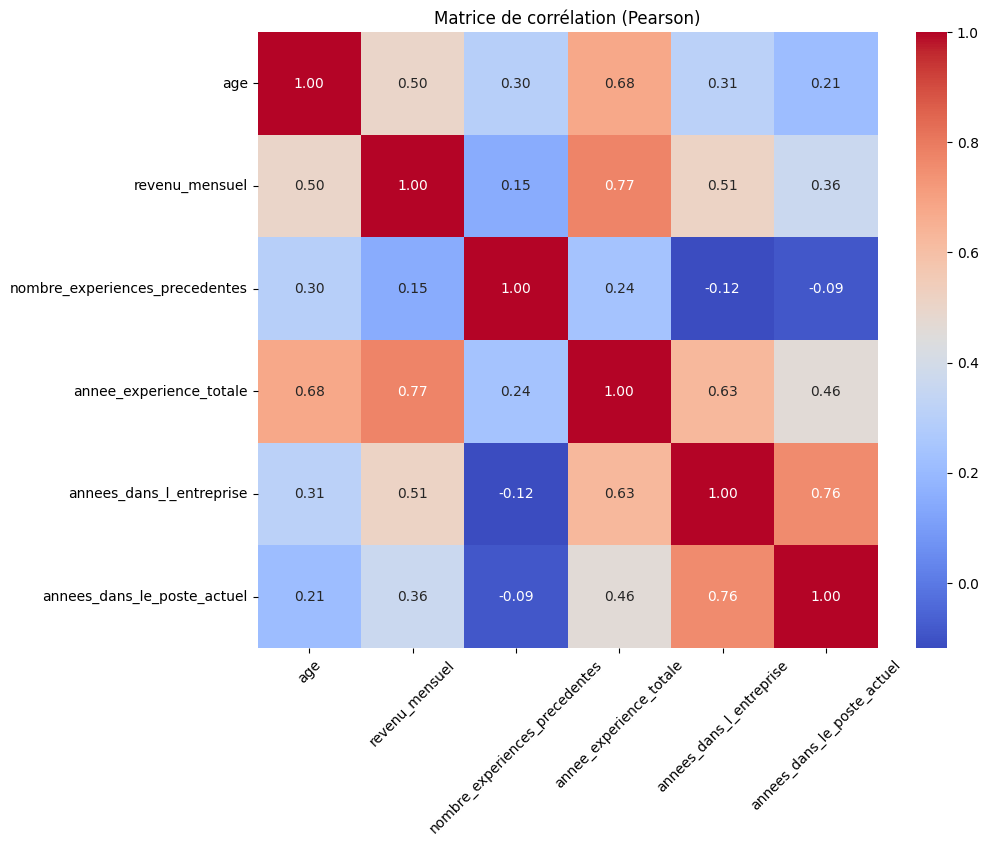

In [11]:
drop_cols = ['id_employee','nombre_heures_travailless']
num_cols = df_sirh.select_dtypes(include=['number']).columns.drop(drop_cols)
pearson_corr = df_sirh[num_cols].corr('pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation (Pearson)')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Seuil de forte corrélation
threshold = 0.7

# Liste pour stocker les paires de colonnes fortement corrélées
strongly_correlated_pairs = []
for i in range(len(num_cols)):
    for j in range(i + 1, len(num_cols)):
        corr_value = pearson_corr.iloc[i, j]
        if abs(corr_value) > threshold:
            strongly_correlated_pairs.append((num_cols[i], num_cols[j], corr_value))

# Affichage des paires de colonnes fortement corrélées
for col1, col2, corr in strongly_correlated_pairs:
    print(f"Colonnes fortement corrélées : {col1} et {col2} avec une corrélation de {corr:.2f}")


Colonnes fortement corrélées : revenu_mensuel et annee_experience_totale avec une corrélation de 0.77
Colonnes fortement corrélées : annees_dans_l_entreprise et annees_dans_le_poste_actuel avec une corrélation de 0.76


- `revenu_mensuel` & `annee_experience_totale` : c'est un résultat très logique et attendu dans le monde du travail. Plus un employé a d'expérience professionnelle (total des années), plus son salaire est généralement élevé. C'est une relation directe entre l'ancienneté dans le monde du travail et la rémunération. C'est une variable très importante à prendre en compte.

- `annees_dans_l_entreprise` & `annees_dans_le_poste_actuel` : ce résultat suggère que les employés restent souvent dans le même poste pendant la majeure partie de leur carrière au sein de l'entreprise.

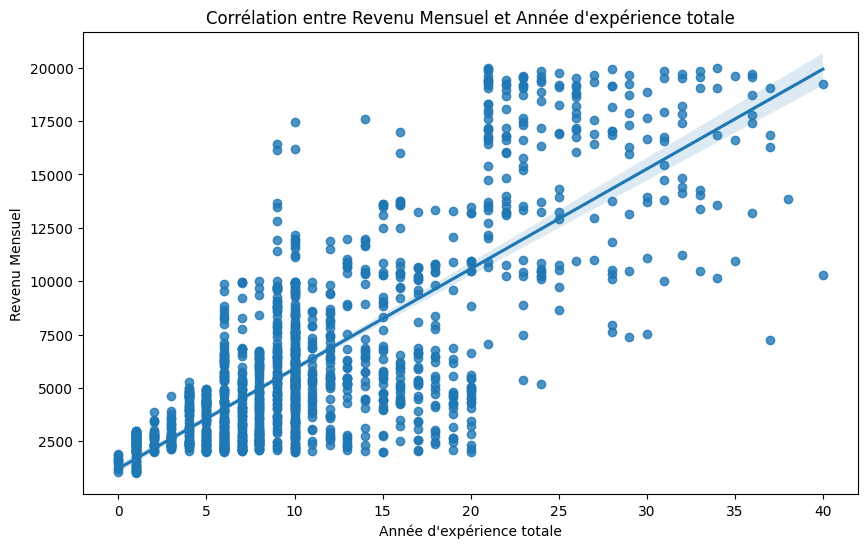

In [13]:
# Créer un nuage de points avec une ligne de régression
plt.figure(figsize=(10, 6))
sns.regplot(x='annee_experience_totale', y='revenu_mensuel', data=df_sirh)
plt.title('Corrélation entre Revenu Mensuel et Année d\'expérience totale')
plt.xlabel('Année d\'expérience totale')
plt.ylabel('Revenu Mensuel')
plt.show()

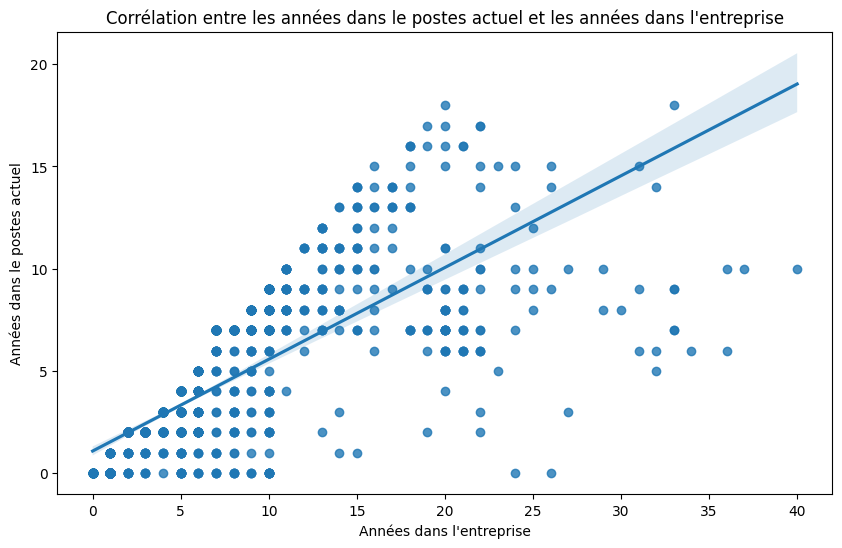

In [14]:
# Créer un nuage de points avec une ligne de régression
plt.figure(figsize=(10, 6))
sns.regplot(x='annees_dans_l_entreprise', y='annees_dans_le_poste_actuel', data=df_sirh)
plt.title('Corrélation entre les années dans le postes actuel et les années dans l\'entreprise')
plt.xlabel('Années dans l\'entreprise')
plt.ylabel('Années dans le postes actuel')
plt.show()

## EDA - extrait_eval.csv

Ce fichier **extrait_eval.csv** contient les évaluations annuelles de performance (note d'évaluation et note satisfaction client) des employés

- 1470 lignes et 10 colonnes, aucunes valeurs manquantes
- 7 colonnes numériques
- 3 colonnes catégorielles :
    - nous pouvons transformer la colonne `eval_number` en numérique
    - la colonne `heure_supplementaires` peut être convertit en une colonne contenant uniquement des 1 (pour OUI) et 0 (pour NON)
    - la colonne `augmentation_salaire_precedente` peut aussi être transformer en numérique

In [15]:
df_eval = pd.read_csv('extrait_eval.csv')
df_eval.head(10)

satisfaction_employee_environnement  note_evaluation_precedente  \
0                                    2                           3   
1                                    3                           2   
2                                    4                           2   
3                                    4                           3   
4                                    1                           3   
5                                    4                           3   
6                                    3                           4   
7                                    4                           3   
8                                    4                           2   
9                                    3                           3   

   niveau_hierarchique_poste  satisfaction_employee_nature_travail  \
0                          2                                     4   
1                          2                                     2   
2                          1                                     3   
3                          1                                     3   
4                          1                                     2   
5                          1                                     4   
6                          1                                     1   
7                          1                                     3   
8                          3                                     3   
9                          2                                     3   

   satisfaction_employee_equipe  satisfaction_employee_equilibre_pro_perso  \
0                             1                                          1   
1                             4                                          3   
2                             2                                          3   
3                             3                                          3   
4                             4                                          3   
5                             3                                          2   
6                             1                                          2   
7                             2                                          3   
8                             2                                          3   
9                             2                                          2   

  eval_number  note_evaluation_actuelle heure_supplementaires  \
0         E_1                         3                   Oui   
1         E_2                         4                   Non   
2         E_4                         3                   Oui   
3         E_5                         3                   Oui   
4         E_7                         3                   Non   
5         E_8                         3                   Non   
6        E_10                         4                   Oui   
7        E_11                         4                   Non   
8        E_12                         4                   Non   
9        E_13                         3                   Non   

  augementation_salaire_precedente  
0                             11 %  
1                             23 %  
2                             15 %  
3                             11 %  
4                             12 %  
5                             13 %  
6                             20 %  
7                             22 %  
8                             21 %  
9                             13 %

In [16]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augementation_salaire_precedente           1470 non-null   object
dtypes: int64(7), object(3)
memory usage:

Transformation des colonnes catégorielles en numériques

In [17]:
df_eval["heure_supplementaires"].value_counts()

heure_supplementaires
Non    1054
Oui     416
Name: count, dtype: int64

In [18]:
df_eval['heure_supplementaires'] = df_eval['heure_supplementaires'].replace({'Oui': 1, 'Non': 0})
df_eval['heure_supplementaires'].dtypes

C:\Users\artur\AppData\Local\Temp\ipykernel_26452\4064574001.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eval['heure_supplementaires'] = df_eval['heure_supplementaires'].replace({'Oui': 1, 'Non': 0})


dtype('int64')

In [19]:
df_eval['eval_number'].value_counts()

eval_number
E_1       1
E_2       1
E_4       1
E_5       1
E_7       1
E_8       1
E_10      1
E_11      1
E_12      1
E_13      1
E_14      1
E_15      1
E_16      1
E_18      1
E_19      1
E_20      1
E_21      1
E_22      1
E_23      1
E_24      1
E_26      1
E_27      1
E_28      1
E_30      1
E_31      1
E_32      1
E_33      1
E_35      1
E_36      1
E_38      1
E_39      1
E_40      1
E_41      1
E_42      1
E_45      1
E_46      1
E_47      1
E_49      1
E_51      1
E_52      1
E_53      1
E_54      1
E_55      1
E_56      1
E_57      1
E_58      1
E_60      1
E_61      1
E_62      1
E_63      1
E_64      1
E_65      1
E_68      1
E_70      1
E_72      1
E_73      1
E_74      1
E_75      1
E_76      1
E_77      1
E_78      1
E_79      1
E_80      1
E_81      1
E_83      1
E_84      1
E_85      1
E_86      1
E_88      1
E_90      1
E_91      1
E_94      1
E_95      1
E_96      1
E_97      1
E_98      1
E_100     1
E_101     1
E_102     1
E_103     1
E_104     1
E_105     1
E_10

In [20]:
df_eval['augementation_salaire_precedente'].value_counts()

augementation_salaire_precedente
11 %    210
13 %    209
14 %    201
12 %    198
15 %    101
18 %     89
17 %     82
16 %     78
19 %     76
22 %     56
20 %     55
21 %     48
23 %     28
24 %     21
25 %     18
Name: count, dtype: int64

In [21]:
# Transformation de eval_number
df_eval['eval_number'] = df_eval['eval_number'].str.replace('E_', '').astype(int)

In [22]:
# Transformation de augmentation_salaire_precedente
df_eval['augementation_salaire_precedente'] = df_eval['augementation_salaire_precedente'].str.replace(' %', '').astype(float) / 100

In [23]:
df_eval['eval_number'].dtypes

dtype('int64')

In [24]:
df_eval['augementation_salaire_precedente'].dtypes

dtype('float64')

In [25]:
cols_to_drop = ['heure_supplementaires','eval_number']
df_eval.drop(cols_to_drop, axis=1).describe().T

count      mean       std   min  \
satisfaction_employee_environnement        1470.0  2.721769  1.093082  1.00   
note_evaluation_precedente                 1470.0  2.729932  0.711561  1.00   
niveau_hierarchique_poste                  1470.0  2.063946  1.106940  1.00   
satisfaction_employee_nature_travail       1470.0  2.728571  1.102846  1.00   
satisfaction_employee_equipe               1470.0  2.712245  1.081209  1.00   
satisfaction_employee_equilibre_pro_perso  1470.0  2.761224  0.706476  1.00   
note_evaluation_actuelle                   1470.0  3.153741  0.360824  3.00   
augementation_salaire_precedente           1470.0  0.152095  0.036599  0.11   

                                            25%   50%   75%   max  
satisfaction_employee_environnement        2.00  3.00  4.00  4.00  
note_evaluation_precedente                 2.00  3.00  3.00  4.00  
niveau_hierarchique_poste                  1.00  2.00  3.00  5.00  
satisfaction_employee_nature_travail       2.00  3.00  4.00  4.00  
satisfaction_employee_equipe               2.00  3.00  4.00  4.00  
satisfaction_employee_equilibre_pro_perso  2.00  3.00  3.00  4.00  
note_evaluation_actuelle                   3.00  3.00  3.00  4.00  
augementation_salaire_precedente           0.12  0.14  0.18  0.25

In [26]:
df_eval['note_evaluation_actuelle'].value_counts()

note_evaluation_actuelle
3    1244
4     226
Name: count, dtype: int64

**Statistiques descriptives**
- `satisfaction_employee_environnement` & `satisfaction_employee_nature_travail` :
    - Les moyennes sont similaires, environ 2.72. Cela nous dit que la satisfaction générale des employés pour leur environnement et la nature de leur travail est plutôt "neutre" à "satisfaite" sur une échelle qui semble aller de 1 à 4
    - L'écart-type est d'environ 1.09 et 1.10. C'est relativement élevé comparé à la moyenne, ce qui suggère qu'il y a une bonne diversité de réponses. Les employés ne sont pas tous d'accord, certains sont très insatisfaits et d'autres très satisfaits.
    - La médiane est de 3.00, ce qui est légèrement supérieur à la moyenne. Cela peut indiquer que les données sont légèrement asymétriques, tirant vers les valeurs plus élevées (satisfaction). Cela signifie que la moitié des employés ont donné une note de 3 ou plus.

- `note_evaluation_precedente` & `note_evaluation_actuelle` : 
    - note_evaluation_precedente : La moyenne est de 2.73 et l'écart-type de 0.71. C'est une plus faible dispersion que les variables de satisfaction. La plupart des notes précédentes sont regroupées entre 2.00 et 3.00 (quartiles). La médiane est 3.00.

    - note_evaluation_actuelle : La moyenne est de 3.15, et l'écart-type est de 0.36, ce qui est très faible ! De plus, la note minimale est de 3.00 et le 75ème percentile est aussi de 3.00.

    - Interprétation clé : La plupart des employés ont reçu une note de 3.00 lors de leur évaluation actuelle. La distribution des notes est très concentrée, presque toutes les notes sont à 3.00. Il n'y a pas beaucoup de notes à 4.00 (seulement 226 (15,37%)), et aucune note en dessous de 3.00. Cela pourrait indiquer un biais, par exemple, que le manager n'ose pas donner de mauvaises notes ou qu'il y a une politique qui ne permet pas les notes en dessous d'un certain seuil.

- `niveau_hierarchique_poste` :
    - La moyenne est de 2.06, ce qui est légèrement supérieur à 2. Si l'échelle va de 1 à 5, cela indique que la majorité des employés se trouvent dans les niveaux hiérarchiques les plus bas.
    
    - La médiande de 2.00 confirme que 50% des employés ont un niveau hiérarchique de 2 ou mois.

- `satisfaction_employee_equipe` :
    - La moyenne de 2.71 est très similaire aux autres variables de satisfaction.
    
    - L'écart-type est de 1.08, ce qui montre une bonne dispersion des réponses. Il y a des employés très satisfaits de leur équipe et d'autres qui ne le sont pas du tout.
    
    - La médiane est de 3.00, indique une légère asymétrie vers les valeurs plus élevées.

- `satisfaction_employee_equilibre_pro_perso` :
    - La moyenne la plus élevée, 2.76, cela suggère que c'est le domaine où les employés se sentent globalement le plus satisfaits.
    
    - L'écart-type est de 0.70. C'est le plus faible des écarts-types pour les variables de satisfaction, ce qui indique que les opinions sont plus homogènes sur ce sujet. Les employés ont une opinion assez cohérente sur l'équilibre vie pro/perso.
    
- `augementation_salaire_precedente` : La moyenne est de 0.152, soit environ 15.2%. L'écart-type est très faible, 0.036. Cela signifie que les augmentations de salaire sont très regroupées autour de la moyenne. Il n'y a pas d'énormes variations d'une augmentation à l'autre. L'essentiel des augmentations de salaire se situe entre 12% et 18% (l'écart interquartile).

- `heure_supplementaires` & `eval_number` : l'application des statistiques descriptives n'a aucune sens sur ces variables.

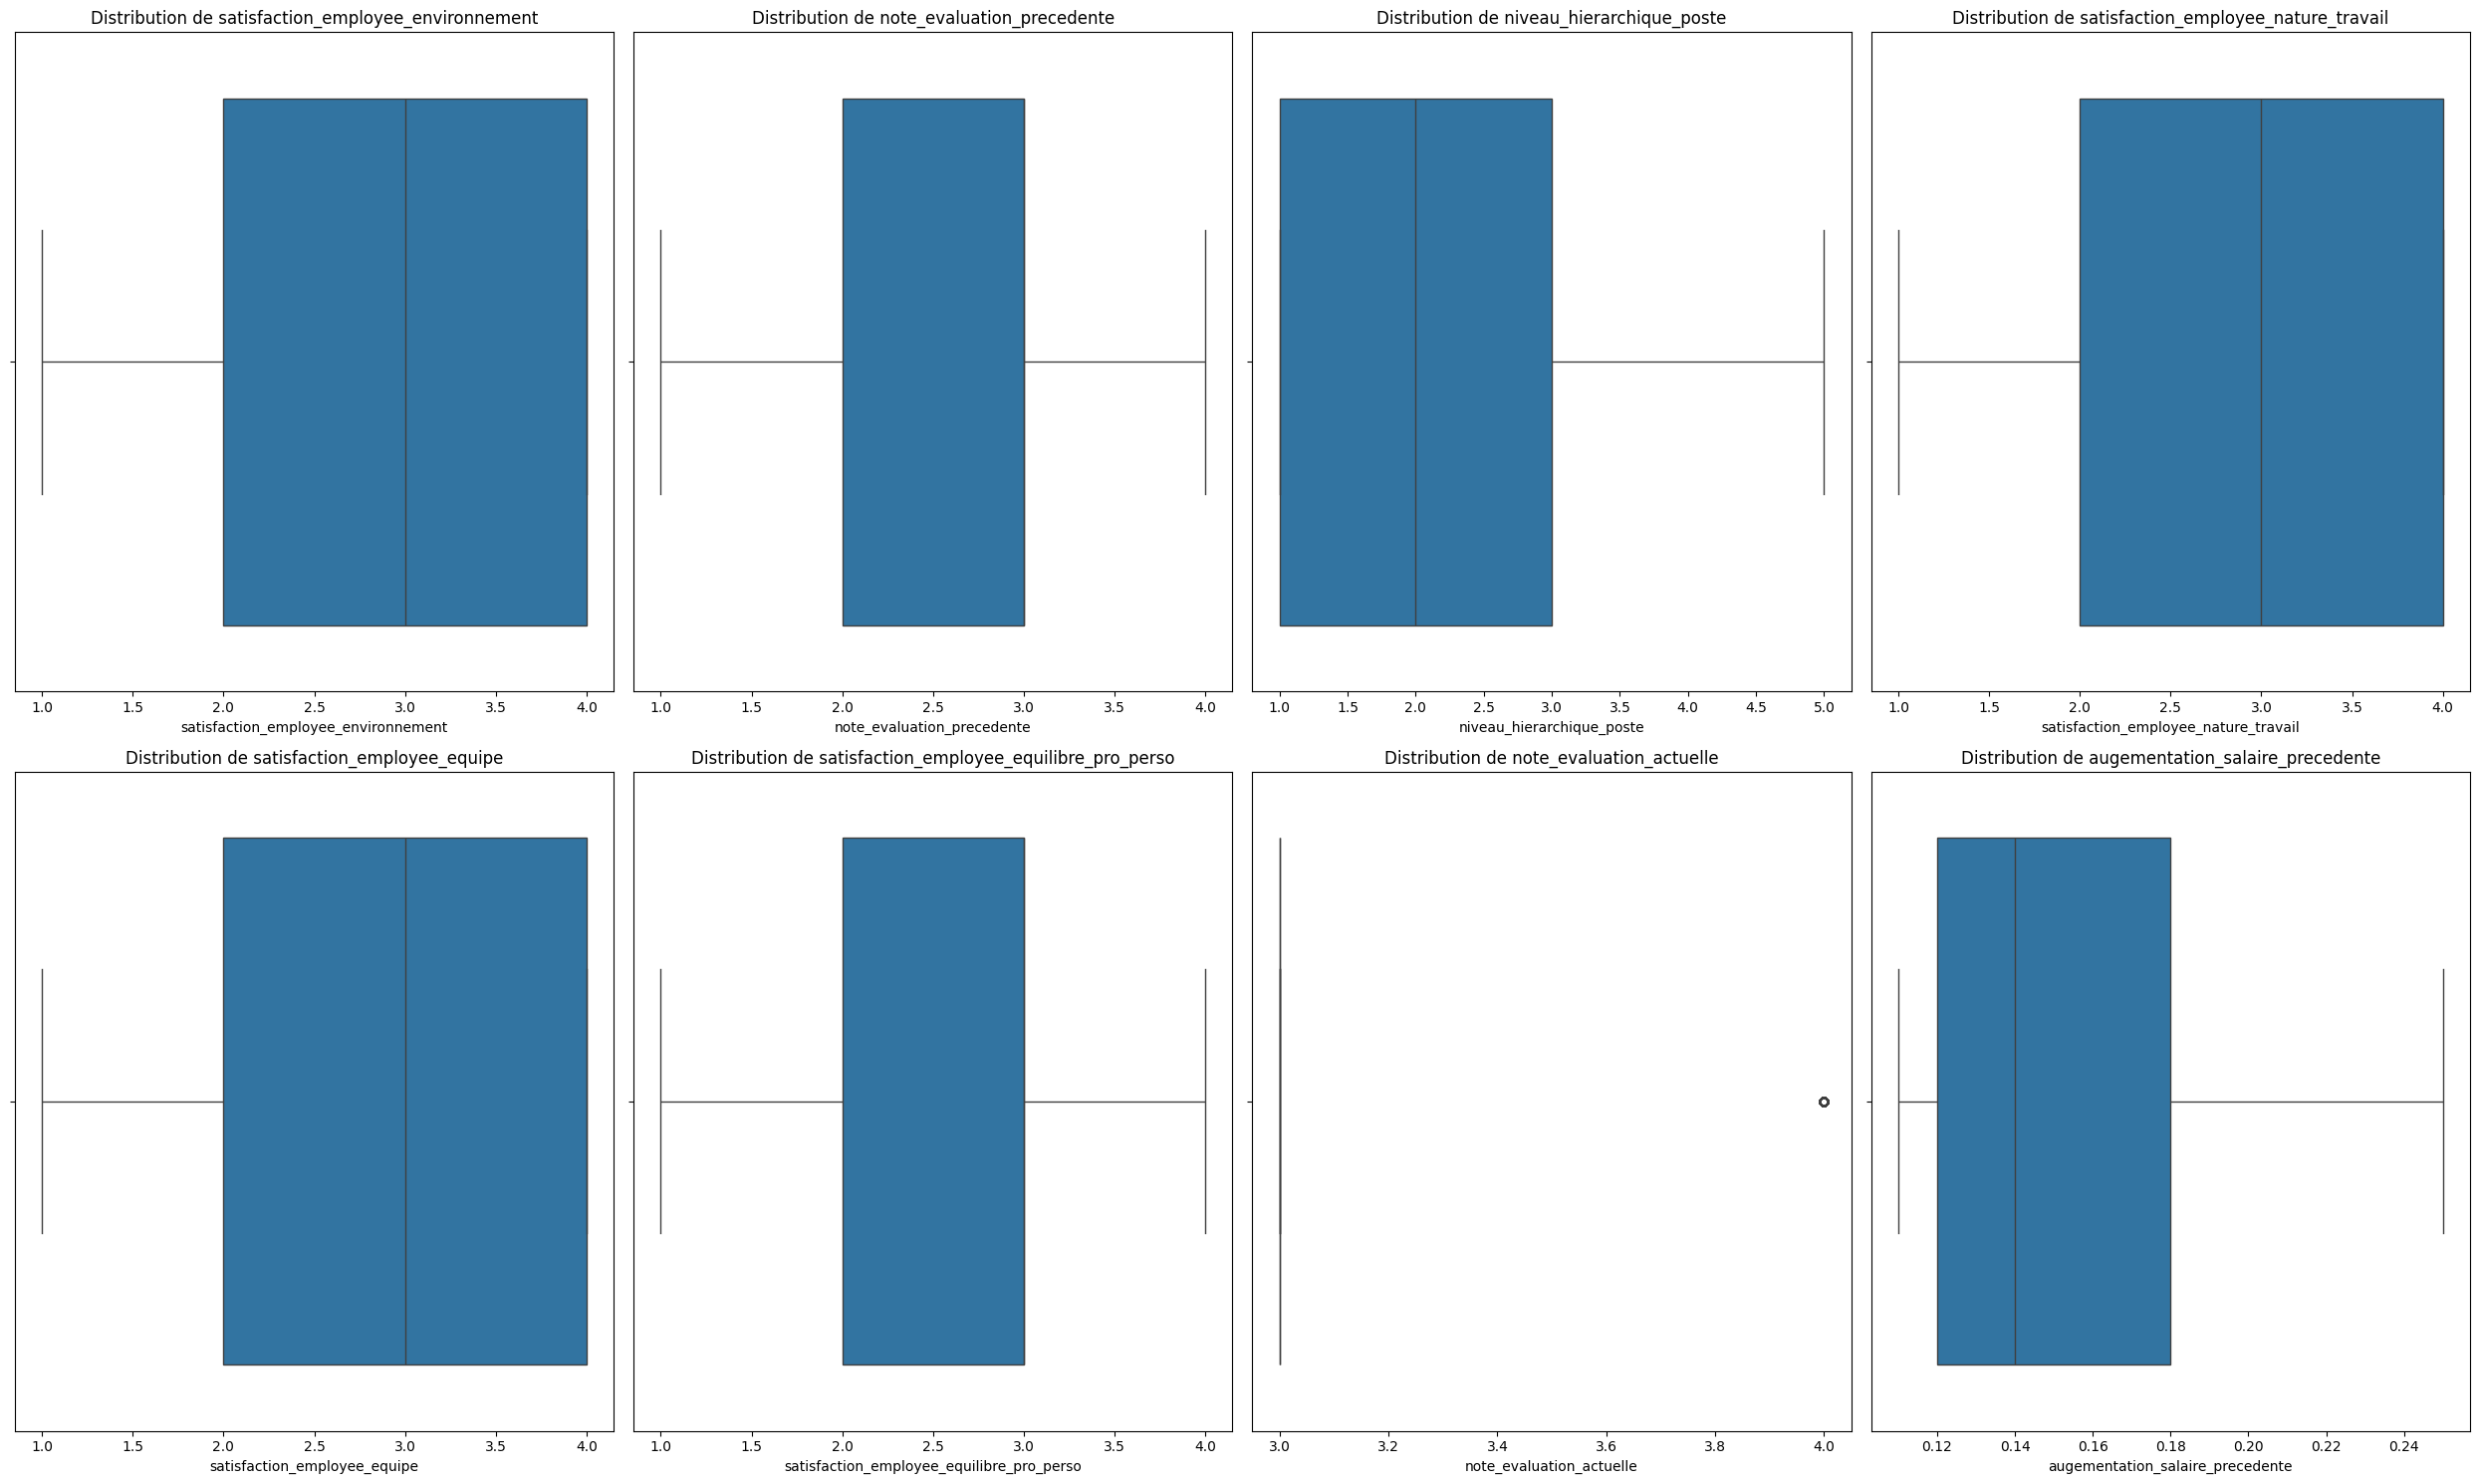

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.flatten()
for i, col in enumerate(df_eval.drop(cols_to_drop, axis=1).columns):
    sns.boxplot(x=df_eval[col], ax=axes[i])
    axes[i].set_title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

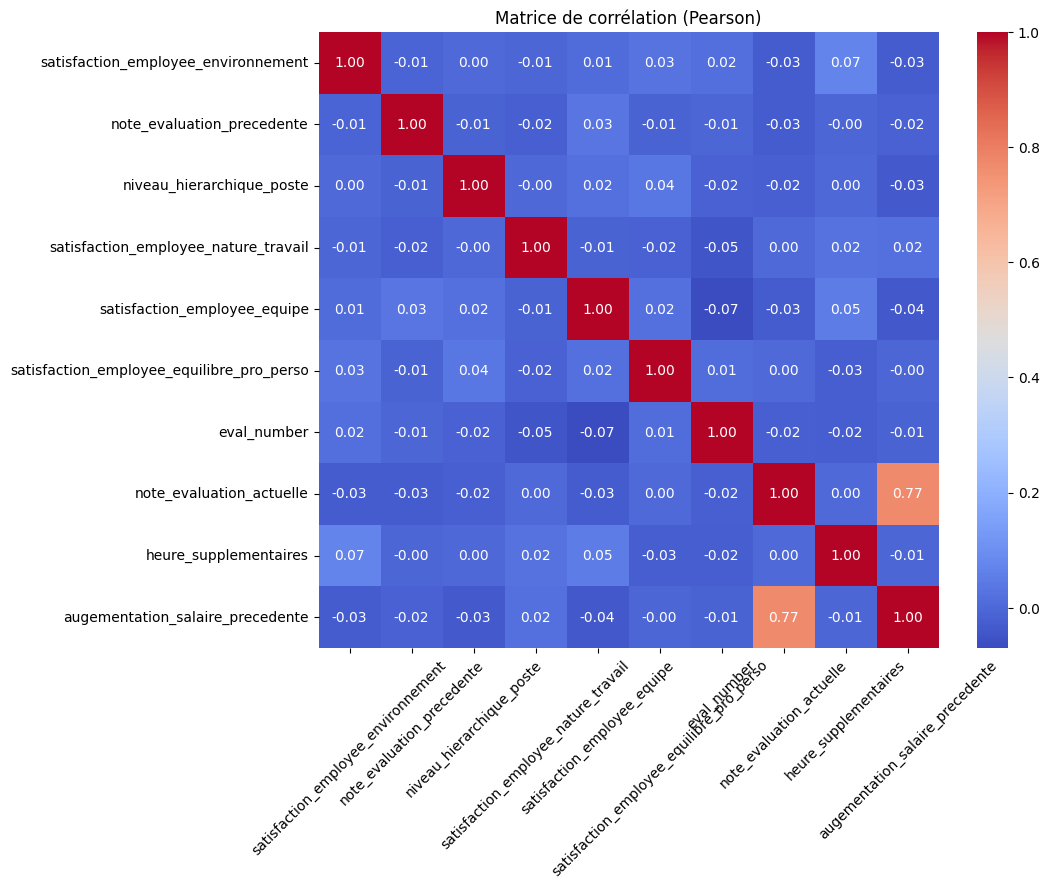

In [28]:
pearson_corr = df_eval.corr('pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation (Pearson)')
plt.xticks(rotation=45)
plt.show()

In [29]:
# Définir un seuil de corrélation
threshold = 0.7

# Trouver les paires de variables fortement corrélées
high_corr_pairs = []
for i in range(len(pearson_corr.columns)):
    for j in range(i):
        if abs(pearson_corr.iloc[i, j]) > threshold:
            high_corr_pairs.append((pearson_corr.columns[i], pearson_corr.columns[j], pearson_corr.iloc[i, j]))

# Afficher les paires fortement corrélées
print("Paires de variables fortement corrélées (seuil =", threshold, "):")
for pair in high_corr_pairs:
    print(f"Variables: {pair[0]} et {pair[1]}, Corrélation: {pair[2]:.2f}")

Paires de variables fortement corrélées (seuil = 0.7 ):
Variables: augementation_salaire_precedente et note_evaluation_actuelle, Corrélation: 0.77


Cette forte corrélation positive suggère que les employés qui ont eu une bonne note_evaluation_actuelle ont aussi tendance à recevoir une augementation_salaire_precedente plus élevée.

Les augmentations de salaire sont généralement liées aux performances. Plus un employé est bien noté, plus son augmentation est significative.

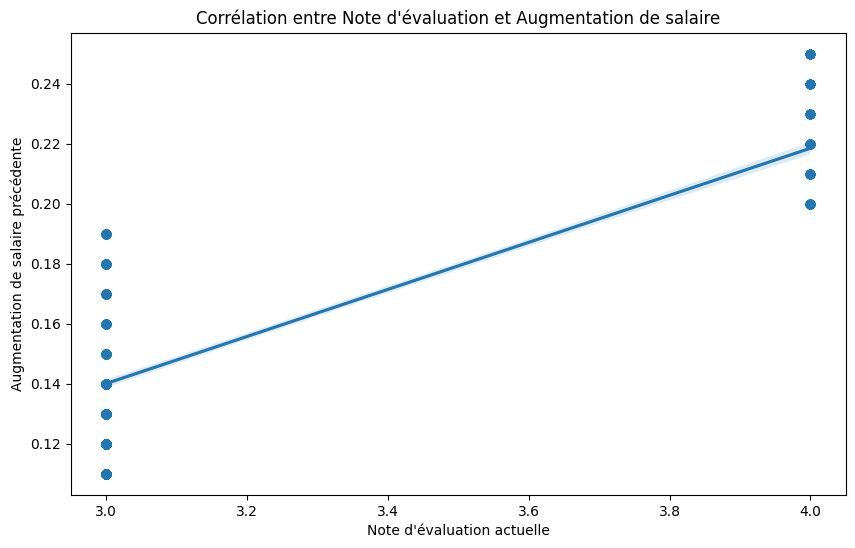

In [30]:
# Créer un nuage de points avec une ligne de régression pour visualiser la corrélation
plt.figure(figsize=(10, 6))
sns.regplot(x='note_evaluation_actuelle', y='augementation_salaire_precedente', data=df_eval)
plt.title('Corrélation entre Note d\'évaluation et Augmentation de salaire')
plt.xlabel('Note d\'évaluation actuelle')
plt.ylabel('Augmentation de salaire précédente')
plt.show()

In [31]:
df_eval['eval_number'].duplicated().sum()

np.int64(0)

## EDA - extrait_sondage.csv

Le fichier **extrait_sondage.csv** contient les réponses des employés du sondage annuel qui aide à l'entreprise à mettre en place des actions pour le bien-être des employés
 
- Contient 1470 lignes et 12 colonnes.
- Aucune valeurs manquantes
- Contient 4 colonnes catégrielles et 8 colonnes numériques

In [32]:
df_sondage = pd.read_csv('extrait_sondage.csv')
df_sondage.head()

a_quitte_l_entreprise  nombre_participation_pee  nb_formations_suivies  \
0                   Oui                         0                      0   
1                   Non                         1                      3   
2                   Oui                         0                      3   
3                   Non                         0                      3   
4                   Non                         1                      3   

   nombre_employee_sous_responsabilite  code_sondage  \
0                                    1             1   
1                                    1             2   
2                                    1             4   
3                                    1             5   
4                                    1             7   

   distance_domicile_travail  niveau_education            domaine_etude  \
0                          1                 2            Infra & Cloud   
1                          8                 1            Infra & Cloud   
2                          2                 2                    Autre   
3                          3                 4            Infra & Cloud   
4                          2                 1  Transformation Digitale   

  ayant_enfants frequence_deplacement  annees_depuis_la_derniere_promotion  \
0             Y           Occasionnel                                    0   
1             Y              Frequent                                    1   
2             Y           Occasionnel                                    0   
3             Y              Frequent                                    3   
4             Y           Occasionnel                                    2   

   annes_sous_responsable_actuel  
0                              5  
1                              7  
2                              0  
3                              0  
4                              2

In [33]:
df_sondage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

In [34]:
# Colonnes catégorielles
cat_cols = df_sondage.select_dtypes(include=['object']).columns

print("Colonnes catégorielles :", cat_cols.tolist())

Colonnes catégorielles : ['a_quitte_l_entreprise', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']


In [35]:
for col in cat_cols:
    print(f"Colonne '{col}' :")
    print(df_sondage[col].value_counts())
    print("\n")

Colonne 'a_quitte_l_entreprise' :
a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64


Colonne 'domaine_etude' :
domaine_etude
Infra & Cloud              606
Transformation Digitale    464
Marketing                  159
Entrepreunariat            132
Autre                       82
Ressources Humaines         27
Name: count, dtype: int64


Colonne 'ayant_enfants' :
ayant_enfants
Y    1470
Name: count, dtype: int64


Colonne 'frequence_deplacement' :
frequence_deplacement
Occasionnel    1043
Frequent        277
Aucun           150
Name: count, dtype: int64




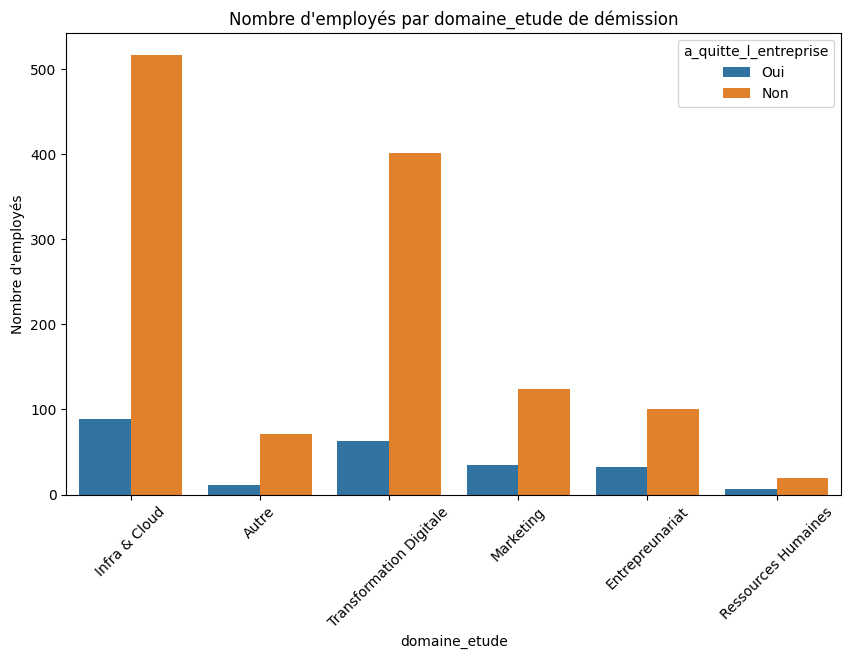

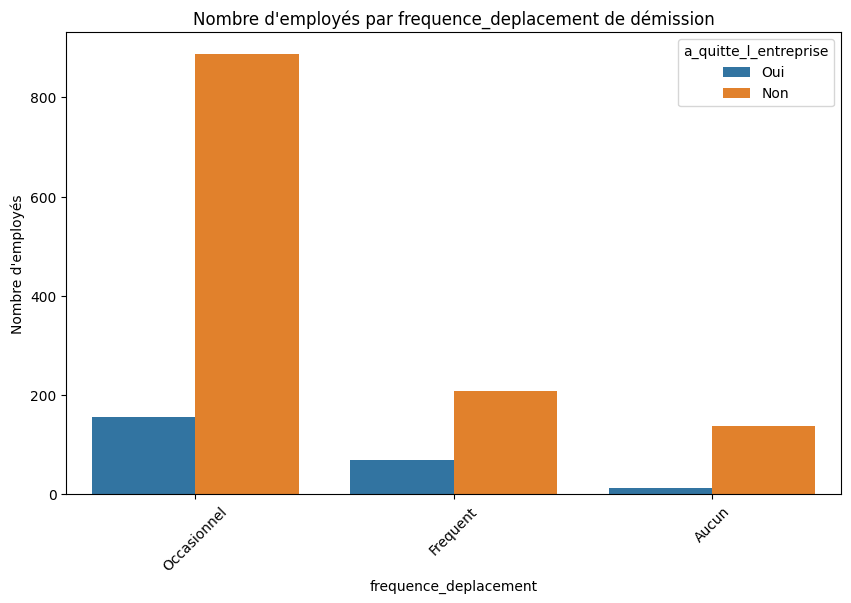

In [36]:
for col in cat_cols.drop(['a_quitte_l_entreprise', 'ayant_enfants']):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='a_quitte_l_entreprise', data=df_sondage)
    plt.title(f'Nombre d\'employés par {col} de démission')
    plt.xlabel(col)
    plt.ylabel('Nombre d\'employés')
    plt.xticks(rotation=45)
    plt.show()

a_quitte_l_entreprise      Non    Oui
domaine_etude                        
Autre                    86.59  13.41
Entrepreunariat          75.76  24.24
Infra & Cloud            85.31  14.69
Marketing                77.99  22.01
Ressources Humaines      74.07  25.93
Transformation Digitale  86.42  13.58

<Figure size 1000x600 with 0 Axes>

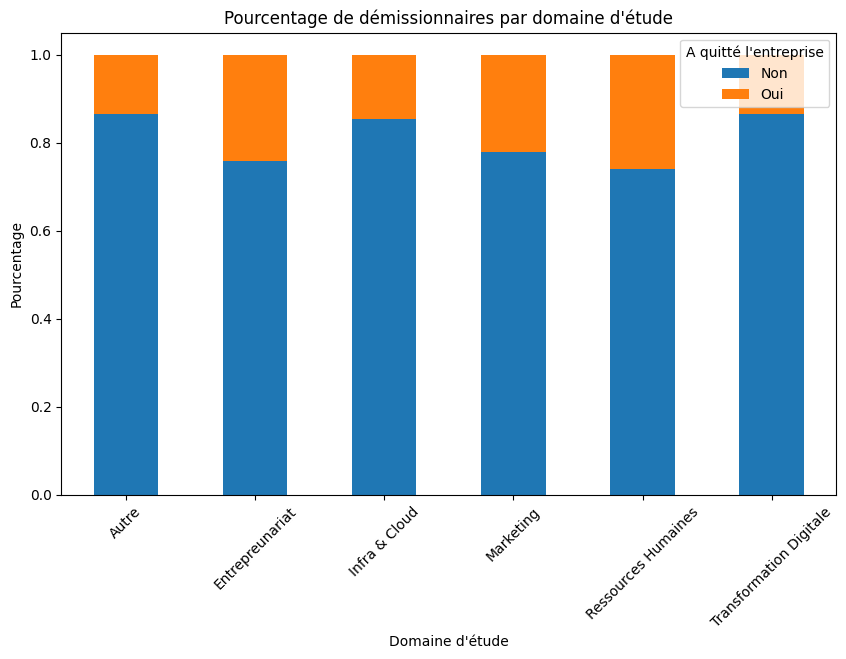

In [37]:
proportions_etude = df_sondage.groupby('domaine_etude')['a_quitte_l_entreprise'].value_counts(normalize=True).unstack()

display((proportions_etude*100).round(2))

plt.figure(figsize=(10, 6))
proportions_etude.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Pourcentage de démissionnaires par domaine d\'étude')
plt.xlabel('Domaine d\'étude')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45)
plt.legend(title='A quitté l\'entreprise')
plt.show()

a_quitte_l_entreprise    Non    Oui
frequence_deplacement              
Aucun                  92.00   8.00
Frequent               75.09  24.91
Occasionnel            85.04  14.96

<Figure size 1000x600 with 0 Axes>

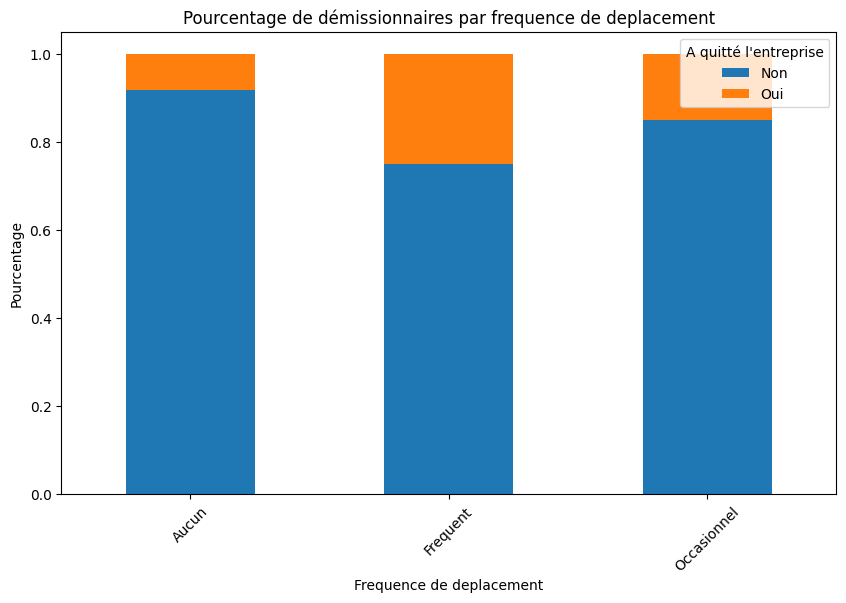

In [38]:
proportions_deplacement = df_sondage.groupby('frequence_deplacement')['a_quitte_l_entreprise'].value_counts(normalize=True).unstack()

display((proportions_deplacement*100).round(2))

plt.figure(figsize=(10, 6))
proportions_deplacement.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Pourcentage de démissionnaires par frequence de deplacement')
plt.xlabel('Frequence de deplacement')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45)
plt.legend(title='A quitté l\'entreprise')
plt.show()

**Analyse des colonnes catégorielles**
- Colonne `a_quitte_l_entreprise` : Les employés qui ont démissionné sont minoritaires. Il faudra en tenir compte lors de la modélisation. Un modèle pourrait être tenté de prédire "Non" pour tout le monde, car c'est la réponse la plus fréquente.

- Colonne `domaine_etude` : On voit que les domaines "Infra & Cloud" et "Transformation Digitale" sont les plus représentés, ce qui est logique pour une entreprise de Consulting et Commercial

- Colonne `ayant_enfants` : cette colonne ne contienne qu'une seule valeur (Y), c'est une constante, et on peut l'éliminer du dataset final, car elle ne sert à rien.

- Colonne `frequence_deplacement` : La majorité des employés (Occasionnel) est une information pertinente. Il sera intéressant de voir si la fréquence des déplacements est plus élevée chez les démissionnaires.

- Les employés issus des domaines `Ressources Humaines` (25,93 %), `Entrepreneuriat` (24,24 %) et `Marketing` (22,01 %) ont les taux de démission les plus élevés. Cela est particulièrement intéressant pour les Ressources Humaines, car leur faible effectif rend ce taux de démission proportionnellement très important.

- Les domaines `Transformation Digitale` (13,58 %) et `Infra & Cloud` (14,69 %) ont les taux de démission les plus bas. Cela pourrait indiquer que ces départements offrent un environnement de travail plus stable ou que les compétences y sont plus demandées.

- Les employés qui se déplacent fréquement ont un taux de démission de 24,91%.

Conclusion :

1. **La fréquence de déplacement** : C'est le facteur le plus discriminant.
2. **Le domaine d'étude** : Les employés en RH, Entrepreneuriat et Marketing sont plus enclins à démissionner.

In [39]:
df_sondage.describe().T

count         mean         std  min  \
nombre_participation_pee             1470.0     0.793878    0.852077  0.0   
nb_formations_suivies                1470.0     2.799320    1.289271  0.0   
nombre_employee_sous_responsabilite  1470.0     1.000000    0.000000  1.0   
code_sondage                         1470.0  1024.865306  602.024335  1.0   
distance_domicile_travail            1470.0     9.192517    8.106864  1.0   
niveau_education                     1470.0     2.912925    1.024165  1.0   
annees_depuis_la_derniere_promotion  1470.0     2.187755    3.222430  0.0   
annes_sous_responsable_actuel        1470.0     4.123129    3.568136  0.0   

                                        25%     50%      75%     max  
nombre_participation_pee               0.00     1.0     1.00     3.0  
nb_formations_suivies                  2.00     3.0     3.00     6.0  
nombre_employee_sous_responsabilite    1.00     1.0     1.00     1.0  
code_sondage                         491.25  1020.5  1555.75  2068.0  
distance_domicile_travail              2.00     7.0    14.00    29.0  
niveau_education                       2.00     3.0     4.00     5.0  
annees_depuis_la_derniere_promotion    0.00     1.0     3.00    15.0  
annes_sous_responsable_actuel          2.00     3.0     7.00    17.0

**Interprétation des varibales numériques**

- `nombre_participation_pee` : Nombre de participations à un Plan d'Épargne Entreprise. Les employés qui s'investissent dans ces programmes d'entreprise sont probablement plus engagés et fidèles. Je m'attendrais à ce que le nombre de participations soit plus élevé chez les employés qui ne sont pas partis. 50% des employés ont participé au moins une fois.

- `nb_formations_suivies` : La plupart des employés ont suivi entre 2 et 3 formations, ce qui est une bonne nouvelle pour l'entreprise. De manière similaire au PEE, suivre des formations est un signe d'investissement personnel. Un employé qui se forme pour son poste est sans doute moins susceptible de le quitter.

- `nombre_employee_sous_responsabilite` : Tous les indicateurs (min, 25%, 50%, 75%, max) sont à 1.0. Cela signifie que cette variable est une constante. Cette colonne n'apporte aucune information discriminante et ne sera pas utile pour ton modèle de Machine Learning.

- `code_sondage` : Comme id_employee, cette colonne est une clé d'identification, mais n'a aucun pouvoir prédictif sur la démission.

- `distance_domicile_travail` : Les employés avec une longue distance de trajet peuvent être plus enclins à démissionner. Je m'attendrais à voir une distance moyenne plus élevée pour le groupe des démissionnaires.

- `niveau_education` : Le niveau d'éducation pourrait être lié à la démission, car un niveau plus élevé pourrait correspondre à des employés qui ont plus d'opportunités de carrière. Il est important de visualiser cela pour voir si une tendance se dégage.

- `annees_depuis_la_derniere_promotion` : C'est une variable très importante. On peut supposer qu'un long délai depuis la dernière promotion est un facteur de démission. La moyenne (2.18) est plus de deux fois plus grande que la médiane (1.0). Cela montre une forte asymétrie vers la droite : beaucoup d'employés ont eu une promotion récemment, mais certains attendent depuis très longtemps (jusqu'à 15 ans, le maximum).

- `annes_sous_responsable_actuel` : La moyenne (4.12) est supérieure à la médiane (3.0), ce qui indique aussi une asymétrie. Le temps passé sous le même manager soit un facteur, que ce soit très court (signe d'un désaccord) ou très long (signe de stagnation).

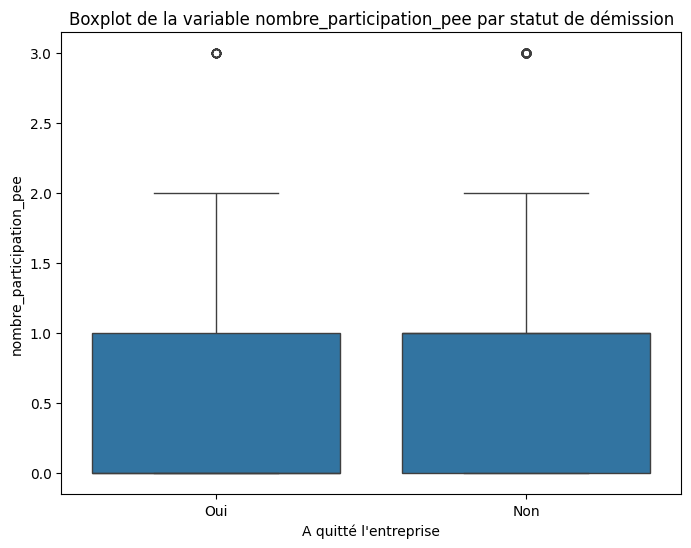

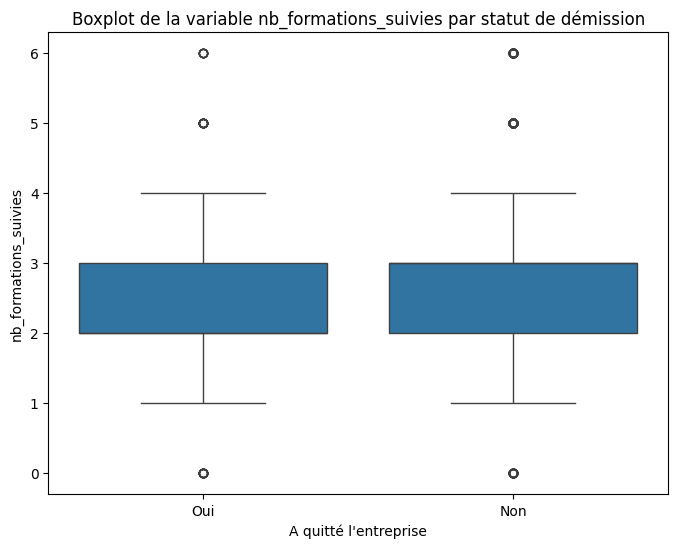

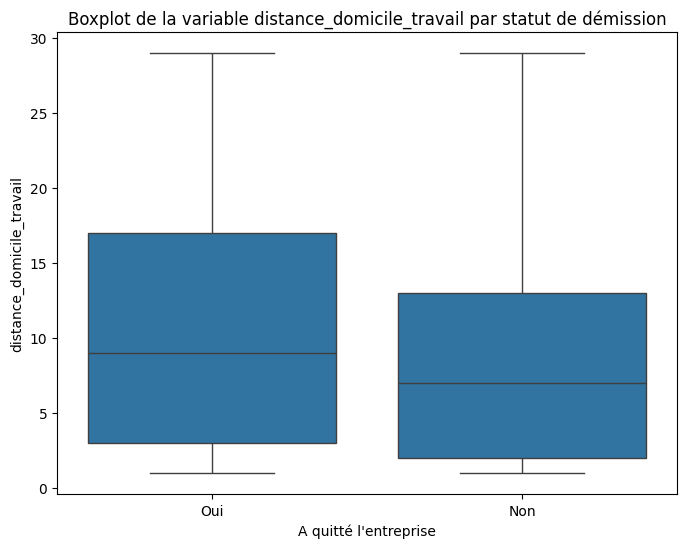

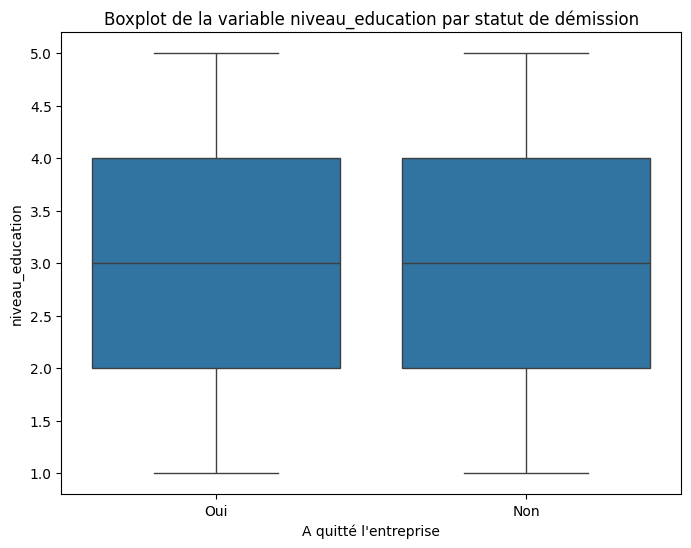

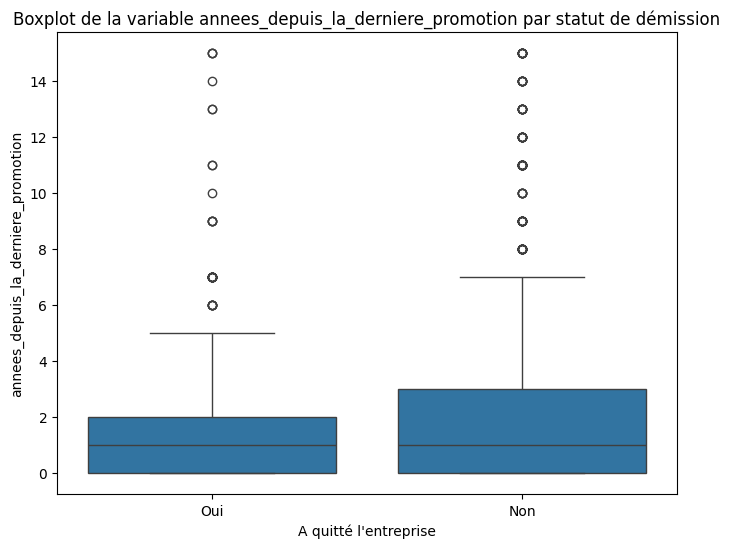

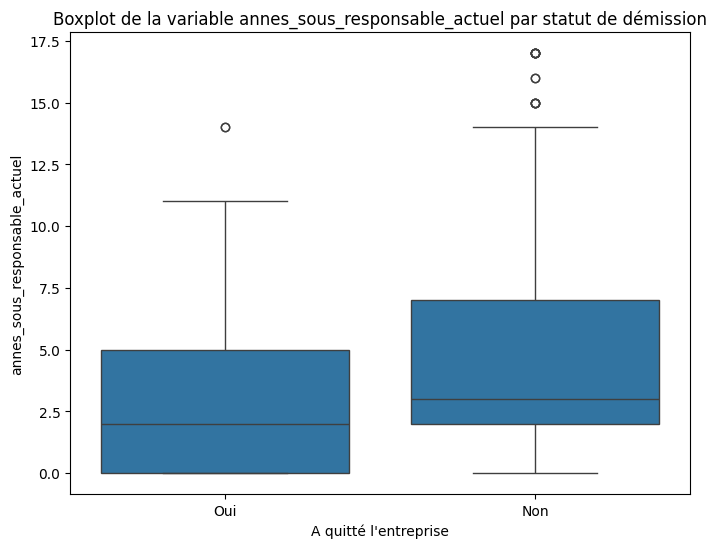

In [40]:
num_cols = df_sondage.select_dtypes(include=['number']).columns.drop(['code_sondage', 'nombre_employee_sous_responsabilite'])

for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='a_quitte_l_entreprise', y=col, data=df_sondage)
    plt.title(f'Boxplot de la variable {col} par statut de démission')
    plt.xlabel('A quitté l\'entreprise')
    plt.ylabel(col)
    plt.show()

In [41]:
df_songage_a_quitte = df_sondage[df_sondage['a_quitte_l_entreprise'] == 'Oui'].drop(['nombre_employee_sous_responsabilite','code_sondage'], axis=1)
df_songage_a_quitte.describe().round(2).T

count   mean   std  min  25%  50%   75%  \
nombre_participation_pee             237.0   0.53  0.86  0.0  0.0  0.0   1.0   
nb_formations_suivies                237.0   2.62  1.25  0.0  2.0  2.0   3.0   
distance_domicile_travail            237.0  10.63  8.45  1.0  3.0  9.0  17.0   
niveau_education                     237.0   2.84  1.01  1.0  2.0  3.0   4.0   
annees_depuis_la_derniere_promotion  237.0   1.95  3.15  0.0  0.0  1.0   2.0   
annes_sous_responsable_actuel        237.0   2.85  3.14  0.0  0.0  2.0   5.0   

                                      max  
nombre_participation_pee              3.0  
nb_formations_suivies                 6.0  
distance_domicile_travail            29.0  
niveau_education                      5.0  
annees_depuis_la_derniere_promotion  15.0  
annes_sous_responsable_actuel        14.0

In [42]:
df_sondage_reste = df_sondage[df_sondage['a_quitte_l_entreprise'] == 'Non'].drop(['nombre_employee_sous_responsabilite','code_sondage'], axis=1)
df_sondage_reste.describe().round(2).T

count  mean   std  min  25%  50%   75%  \
nombre_participation_pee             1233.0  0.85  0.84  0.0  0.0  1.0   1.0   
nb_formations_suivies                1233.0  2.83  1.29  0.0  2.0  3.0   3.0   
distance_domicile_travail            1233.0  8.92  8.01  1.0  2.0  7.0  13.0   
niveau_education                     1233.0  2.93  1.03  1.0  2.0  3.0   4.0   
annees_depuis_la_derniere_promotion  1233.0  2.23  3.23  0.0  0.0  1.0   3.0   
annes_sous_responsable_actuel        1233.0  4.37  3.59  0.0  2.0  3.0   7.0   

                                      max  
nombre_participation_pee              3.0  
nb_formations_suivies                 6.0  
distance_domicile_travail            29.0  
niveau_education                      5.0  
annees_depuis_la_derniere_promotion  15.0  
annes_sous_responsable_actuel        17.0

- `nombre_participation_pee` & `a_quitte_l_entreprise` : Les employés qui ne démissionnent pas ont une plus grande tendance à participer au Plan d'Épargne Entreprise que ceux qui partent. La participation au PEE est un indicateur de l'engagement des employés à long terme.

- `nb_formations_suivies` & `a_quitte_l_entreprise` : La médiane des employés qui sont restés (3.0) est supérieure à celle des démissionnaires (2.0). C'est un indicateur, même s'il est subtil, que la formation pourrait être un facteur de rétention. Les employés qui ont bénéficié de plus de formations ont une plus grande tendance à rester. Cette conclusion est très différente de celle que j'ai formulée précédemment.

- `distance_domicile_travail` & `a_quitte_l_entreprise` : Il y a une corrélation forte entre la distance domicile-travail et la démission. Les employés qui ont un long trajet pour se rendre au travail sont plus susceptibles de quitter l'entreprise.

- `niveau_education` & `a_quitte_l_entreprise` : Les distributions du niveau d'éducation pour les deux groupes sont pratiquement identiques. La moyenne et la médiane sont très proches, et les quartiles sont les mêmes. On peut donc conclure que le niveau d'éducation ne semble pas être un facteur prédictif de la démission.

- `annees_depuis_la_derniere_promotion` & `a_quitte_l_entreprise` : La similarité des médianes (1 an pour les deux groupes) est trompeuse. En revanche, l'analyse des autres statistiques révèle une nuance importante : La moyenne et le 75e percentile sont plus élevés pour les employés qui sont restés dans l'entreprise. Cela suggère que, bien que la médiane soit la même, les non-démissionnaires ont en moyenne attendu plus longtemps pour une promotion que leurs homologues qui sont partis.

- `annes_sous_responsable_actuel` & `a_quitte_l_entreprise` : Il existe une forte corrélation entre la durée passée sous la responsabilité du manager et le risque de démission. Les employés qui démissionnent ont passé en moyenne significativement moins de temps avec leur manager actuel que ceux qui restent. La différence de médiane (2 ans vs 3 ans) et la différence de moyenne (2.85 ans vs 4.37 ans) sont des indicateurs très solides.

In [43]:
df_sondage['a_quitte_l_entreprise_num'] = df_sondage['a_quitte_l_entreprise'].apply(lambda x: 1 if x == 'Oui' else 0)

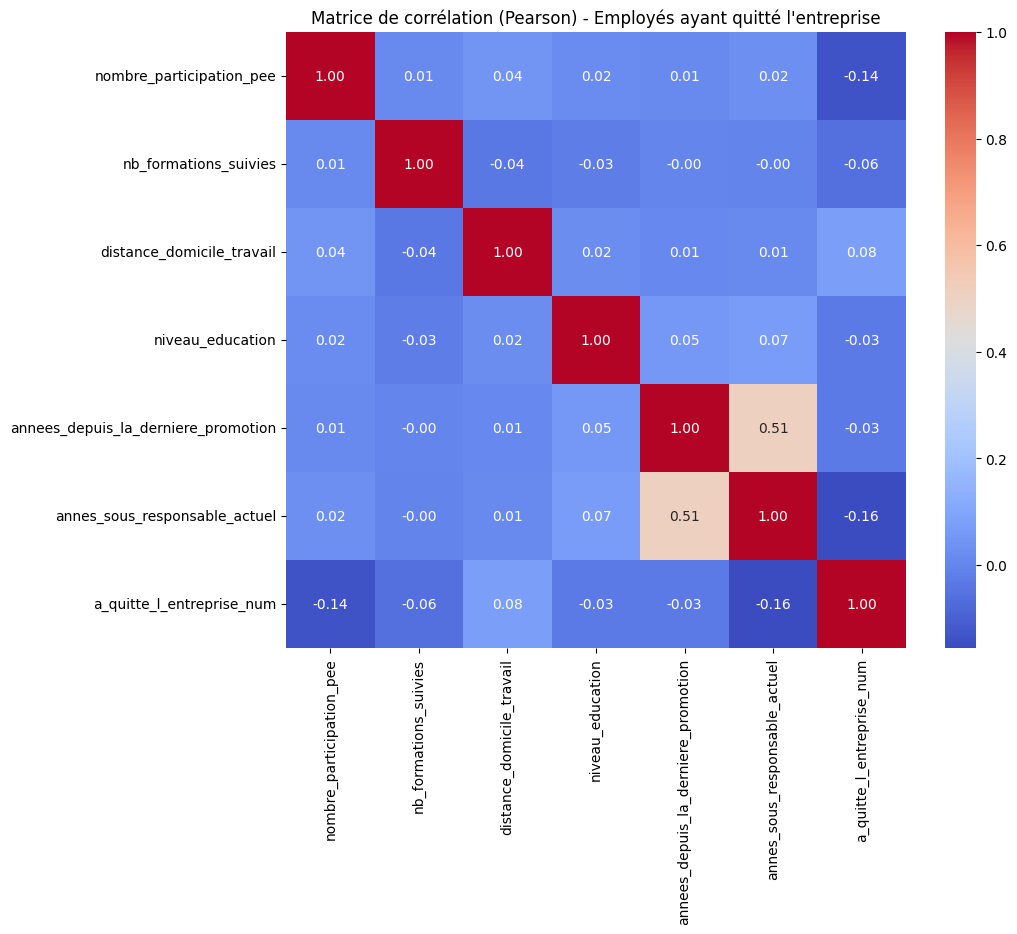

In [44]:
num_cols = df_sondage.select_dtypes(include=['number']).columns.drop(['code_sondage', 'nombre_employee_sous_responsabilite'])

# Matrice de corrélation pour les employés ayant quitté l'entreprise
pearson_corr_sondage = df_sondage[num_cols].corr('pearson')

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr_sondage, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation (Pearson) - Employés ayant quitté l\'entreprise')
plt.show()

In [45]:
# Afficher les corrélations avec la variable cible
print("\nCorrélation avec la variable 'a_quitte_l_entreprise' :")
print(pearson_corr_sondage['a_quitte_l_entreprise_num'].sort_values(ascending=False))


Corrélation avec la variable 'a_quitte_l_entreprise' :
a_quitte_l_entreprise_num              1.000000
distance_domicile_travail              0.077924
niveau_education                      -0.031373
annees_depuis_la_derniere_promotion   -0.033019
nb_formations_suivies                 -0.059478
nombre_participation_pee              -0.137145
annes_sous_responsable_actuel         -0.156199
Name: a_quitte_l_entreprise_num, dtype: float64


In [46]:
df_sondage['code_sondage'].duplicated().sum()

np.int64(0)

# 3. Jointure et EDA sur le fichier central

Les `id_employee`, `code_sondage` et `eval_number` vont me permettre de réaliser les jointures.

In [47]:
# Création des ensembles à partir des colonnes clés
set_sirh = set(df_sirh['id_employee'])
set_eval = set(df_eval['eval_number'])
set_sondage = set(df_sondage['code_sondage'])

# Vérification des tailles des ensembles
print("Taille de l'ensemble des IDs dans df_sirh :", len(set_sirh))
print("Taille de l'ensemble des IDs dans df_eval :", len(set_eval))
print("Taille de l'ensemble des IDs dans df_sondage :", len(set_sondage))

# Vérification si les ensembles sont identiques
if set_sirh == set_eval and set_eval == set_sondage:
    print("\n Les ensembles d'identifiants sont identiques dans les trois DataFrames.")
else:
    print("\n Les ensembles d'identifiants ne sont PAS identiques.")

    # Trouver les IDs manquants ou en trop pour un diagnostic plus précis
    print("\nDifférences :")
    print(f"IDs dans df_sirh mais pas dans df_eval : {set_sirh.difference(set_eval)}")
    print(f"IDs dans df_eval mais pas dans df_sirh : {set_eval.difference(set_sirh)}")
    print(f"IDs dans df_sondage mais pas dans les autres : {set_sondage.difference(set_sirh.union(set_eval))}")

Taille de l'ensemble des IDs dans df_sirh : 1470
Taille de l'ensemble des IDs dans df_eval : 1470
Taille de l'ensemble des IDs dans df_sondage : 1470

 Les ensembles d'identifiants sont identiques dans les trois DataFrames.


Les jointures (ou merge) sont les outils qui vous permettent de les fusionner en un seul tableau.

Les différents types de jointures :
1. **Inner Join (Jointure Interne)** : est la jointure la plus stricte. Elle ne conserve que les lignes qui ont une correspondance dans les deux DataFrames.
    - Analogie : Vous cherchez les étudiants qui sont à la fois sur la liste des inscrits au cours A et sur la liste du cours B. Seuls les étudiants qui sont sur les deux listes sont gardés. **(A ∩ B)**
2. **Left Join (Jointure Gauche)** : conserve toutes les lignes du DataFrame de gauche, et les lignes correspondantes du DataFrame de droite. Si une ligne du DataFrame de gauche n'a pas de correspondance dans celui de droite, les valeurs des colonnes du DataFrame de droite seront remplies de NaN (valeur manquante).
    - Analogie : Vous gardez tous les étudiants inscrits au cours A, et vous leur ajoutez les informations du cours B s'ils y sont aussi inscrits. **[(A ∪ B) - (B - A)]**
3. **Right Join (Jointure Droite)** : l'inverse de Left Join. Elle conserve toutes les lignes du DataFrame de droite, et les lignes correspondantes du DataFrame de gauche.
    - Analogie : Vous gardez tous les étudiants inscrits au cours B, et vous leur ajoutez les informations du cours A s'ils y sont aussi inscrits. **[(A ∪ B) - (A - B)]**
4. **Outer Join (Jointure Complète)** : est la jointure la plus permissive. Elle conserve toutes les lignes des deux DataFrames. Si une ligne n'a pas de correspondance dans l'autre DataFrame, les valeurs des colonnes correspondantes sont remplies de NaN.
    - Analogie : Vous gardez la liste complète de tous les étudiants qui sont inscrits soit au cours A, soit au cours B, soit aux deux. **(A ∪ B)**

## Jointure

Dans notre projet nous utiliserons **`Inner Join`** car :
- J'ai vérifé que les identifiants sont identiques dans les trois datasets.
- L'inner join permettra de s'assurer que chaque ligne de votre DataFrame final correspond bien à un employé qui est présent dans le SIRH, a passé une évaluation et a répondu au sondage. Cela garantit que le dataset final est complet et cohérent.

In [48]:
# 1. Fusionner df_sirh et df_eval sur les colonnes 'id_employee' et 'eval_number'
df_step_1 = pd.merge(df_sirh, df_eval, left_on='id_employee', right_on='eval_number', how='inner')

# Supprimer la colonne redondante 'eval_number'
df_step_1.drop('eval_number', axis=1, inplace=True)

# 2. Fusionner le résultat avec df_sondage sur les colonnes 'id_employee' et 'code_sondage'
df_final = pd.merge(df_step_1, df_sondage, left_on='id_employee', right_on='code_sondage', how='inner')

# Supprimer la colonne redondante 'code_sondage'
df_final.drop('code_sondage', axis=1, inplace=True)

Après la jointure nous avons un nouveau dataframe de 33 colonnes et 1470 lignes :
- 8 colonnes catégorielles : ['genre', 'statut_marital', 'departement', 'poste', 'a_quitte_l_entreprise', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']
- 24 colonnes numériques

In [49]:
df_final.head()

id_employee  age genre  revenu_mensuel statut_marital departement  \
0            1   41     F            5993    Célibataire  Commercial   
1            2   49     M            5130       Marié(e)  Consulting   
2            4   37     M            2090    Célibataire  Consulting   
3            5   33     F            2909       Marié(e)  Consulting   
4            7   27     M            3468       Marié(e)  Consulting   

                    poste  nombre_experiences_precedentes  \
0        Cadre Commercial                               8   
1  Assistant de Direction                               1   
2              Consultant                               6   
3  Assistant de Direction                               1   
4              Consultant                               9   

   nombre_heures_travailless  annee_experience_totale  \
0                         80                        8   
1                         80                       10   
2                         80                        7   
3                         80                        8   
4                         80                        6   

   annees_dans_l_entreprise  annees_dans_le_poste_actuel  \
0                         6                            4   
1                        10                            7   
2                         0                            0   
3                         8                            7   
4                         2                            2   

   satisfaction_employee_environnement  note_evaluation_precedente  \
0                                    2                           3   
1                                    3                           2   
2                                    4                           2   
3                                    4                           3   
4                                    1                           3   

   niveau_hierarchique_poste  satisfaction_employee_nature_travail  \
0                          2                                     4   
1                          2                                     2   
2                          1                                     3   
3                          1                                     3   
4                          1                                     2   

   satisfaction_employee_equipe  satisfaction_employee_equilibre_pro_perso  \
0                             1                                          1   
1                             4                                          3   
2                             2                                          3   
3                             3                                          3   
4                             4                                          3   

   note_evaluation_actuelle  heure_supplementaires  \
0                         3                      1   
1                         4                      0   
2                         3                      1   
3                         3                      1   
4                         3                      0   

   augementation_salaire_precedente a_quitte_l_entreprise  \
0                              0.11                   Oui   
1                              0.23                   Non   
2                              0.15                   Oui   
3                              0.11                   Non   
4                              0.12                   Non   

   nombre_participation_pee  nb_formations_suivies  \
0                         0                      0   
1                         1                      3   
2                         0                      3   
3                         0                      3   
4                         1                      3   

   nombre_employee_sous_responsabilite  distance_domicile_travail  \
0                                    1                          1   
1                                

In [50]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_employee                                1470 non-null   int64  
 1   age                                        1470 non-null   int64  
 2   genre                                      1470 non-null   object 
 3   revenu_mensuel                             1470 non-null   int64  
 4   statut_marital                             1470 non-null   object 
 5   departement                                1470 non-null   object 
 6   poste                                      1470 non-null   object 
 7   nombre_experiences_precedentes             1470 non-null   int64  
 8   nombre_heures_travailless                  1470 non-null   int64  
 9   annee_experience_totale                    1470 non-null   int64  
 10  annees_dans_l_entreprise

In [51]:
# Vérification des doublons dans la colonne 'id_employee'
df_final["id_employee"].duplicated().sum()

np.int64(0)

### Analyse colonnes numériques

In [52]:
# Statistiques descriptives des colonnes numériques
num_cols = df_final.select_dtypes(include=['number']).columns.drop('id_employee')
df_final[num_cols].describe().T

count         mean          std  \
age                                        1470.0    36.923810     9.135373   
revenu_mensuel                             1470.0  6502.931293  4707.956783   
nombre_experiences_precedentes             1470.0     2.693197     2.498009   
nombre_heures_travailless                  1470.0    80.000000     0.000000   
annee_experience_totale                    1470.0    11.279592     7.780782   
annees_dans_l_entreprise                   1470.0     7.008163     6.126525   
annees_dans_le_poste_actuel                1470.0     4.229252     3.623137   
satisfaction_employee_environnement        1470.0     2.721769     1.093082   
note_evaluation_precedente                 1470.0     2.729932     0.711561   
niveau_hierarchique_poste                  1470.0     2.063946     1.106940   
satisfaction_employee_nature_travail       1470.0     2.728571     1.102846   
satisfaction_employee_equipe               1470.0     2.712245     1.081209   
satisfaction_employee_equilibre_pro_perso  1470.0     2.761224     0.706476   
note_evaluation_actuelle                   1470.0     3.153741     0.360824   
heure_supplementaires                      1470.0     0.282993     0.450606   
augementation_salaire_precedente           1470.0     0.152095     0.036599   
nombre_participation_pee                   1470.0     0.793878     0.852077   
nb_formations_suivies                      1470.0     2.799320     1.289271   
nombre_employee_sous_responsabilite        1470.0     1.000000     0.000000   
distance_domicile_travail                  1470.0     9.192517     8.106864   
niveau_education                           1470.0     2.912925     1.024165   
annees_depuis_la_derniere_promotion        1470.0     2.187755     3.222430   
annes_sous_responsable_actuel              1470.0     4.123129     3.568136   
a_quitte_l_entreprise_num                  1470.0     0.161224     0.367863   

                                               min      25%      50%      75%  \
age                                          18.00    30.00    36.00    43.00   
revenu_mensuel                             1009.00  2911.00  4919.00  8379.00   
nombre_experiences_precedentes                0.00     1.00     2.00     4.00   
nombre_heures_travailless                    80.00    80.00    80.00    80.00   
annee_experience_totale                       0.00     6.00    10.00    15.00   
annees_dans_l_entreprise                      0.00     3.00     5.00     9.00   
annees_dans_le_poste_actuel                   0.00     2.00     3.00     7.00   
satisfaction_employee_environnement           1.00     2.00     3.00     4.00   
note_evaluation_precedente                    1.00     2.00     3.00     3.00   
niveau_hierarchique_poste                     1.00     1.00     2.00     3.00   
satisfaction_employee_nature_travail          1.00     2.00     3.00     4.00   
satisfaction_employee_equipe                  1.00     2.00     3.00     4.00   
satisfaction_employee_equilibre_pro_perso     1.00     2.00     3.00     3.00   
note_evaluation_actuelle                      3.00     3.00     3.00     3.00   
heure_supplementaires                         0.00     0.00     0.00     1.00   
augementation_salaire_precedente              0.11     0.12     0.14     0.18   
nombre_participation_pee                      0.00     0.00     1.00     1.00   
nb_formations_suivies                         0.00     2.00     3.00     3.00   
nombre_employee_sous_responsabilite           1.00     1.00     1.00     1.00   
distance_domicile_travail                     1.00     2.00     7.00    14.00   
niveau_education                              1.00     2.00     3.00     4.00   
annees_depuis_la_derniere_promotion           0.00     0.00     1.00     3.00   
annes_sous_responsable_actuel                 0.00     2.00     3.00     7.00   
a_quitte_l_entreprise_num                     0.00     0.00     0.00     0.00   

                                          

In [53]:
categorial_cols = df_final.select_dtypes(include=['object']).columns
for col in categorial_cols:
    print(f"Colonne '{col}' :")
    print(df_final[col].value_counts())
    print("\n")

Colonne 'genre' :
genre
M    882
F    588
Name: count, dtype: int64


Colonne 'statut_marital' :
statut_marital
Marié(e)       673
Célibataire    470
Divorcé(e)     327
Name: count, dtype: int64


Colonne 'departement' :
departement
Consulting             961
Commercial             446
Ressources Humaines     63
Name: count, dtype: int64


Colonne 'poste' :
poste
Cadre Commercial           326
Assistant de Direction     292
Consultant                 259
Tech Lead                  145
Manager                    131
Senior Manager             102
Représentant Commercial     83
Directeur Technique         80
Ressources Humaines         52
Name: count, dtype: int64


Colonne 'a_quitte_l_entreprise' :
a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64


Colonne 'domaine_etude' :
domaine_etude
Infra & Cloud              606
Transformation Digitale    464
Marketing                  159
Entrepreunariat            132
Autre                       82
Ressources Humaines     

- Colonne `id_employee` : les statistiques pas pertinent
- Colonne `age` : range (18 ; 60) ans, moyenne proche de la médiane (36,92 VS 36) -> quasi-symétrie
- Colonne `revenu_mensuel` : range (1009 ; 19999), moyenne plus élevé que la médiane (6502 VS 4919) -> asymétrie
- Colonne `nombre_experiences_precedentes` : range (0 ; 9), moyenne et médiane prochent -> quasi-symétrie. Du débutant au Senior
- Colonne `annee_experience_totale` : range (0 ; 40), moyenne proche de la médiane -> quasi-symétrie. Du débutant au Senior
- Colonne `annees_dans_l_entreprise` : range (0 ; 40), asymétrie, du nouveau au senior
- Colonne `annees_dans_le_poste_actuel` : range (0 ; 18), asymétrie, de débutant à l'expert
- Colonne `genre` : il y a plus d'homme (60%) que de femme (40%)
- Colonne `statut_marital` : 45,78% des employés sont mariés, les autres sont soit célibataires (31,97%), soit divorcés (22,25%)
- Colonne `departement` : Conslting (65,37%), Commercial (30,35) et RH (4,28%)
- Colonne `poste` : 9 postes : Cadre Commercial (22,18%), Assistant de Direction (19,86%), Consultant (17,62%), Tech Lead (9,86%), Manager (8,91%), Senior Manager (6,94%), Représentant Commercial (5,65%), Directeur Technique (5,44%) et Ressources Humaines (3,54%)
- `satisfaction_employee_environnement` & `satisfaction_employee_nature_travail` :
    - Les moyennes sont similaires, environ 2.72. Cela nous dit que la satisfaction générale des employés pour leur environnement et la nature de leur travail est plutôt "neutre" à "satisfaite" sur une échelle qui semble aller de 1 à 4

    - L'écart-type est d'environ 1.09 et 1.10. C'est relativement élevé comparé à la moyenne, ce qui suggère qu'il y a une bonne diversité de réponses. Les employés ne sont pas tous d'accord, certains sont très insatisfaits et d'autres très satisfaits.

    - La médiane est de 3.00, ce qui est légèrement supérieur à la moyenne. Cela peut indiquer que les données sont légèrement asymétriques, tirant vers les valeurs plus élevées (satisfaction). Cela signifie que la moitié des employés ont donné une note de 3 ou plus.

- `note_evaluation_precedente` & `note_evaluation_actuelle` : 
    - note_evaluation_precedente : La moyenne est de 2.73 et l'écart-type de 0.71. C'est une plus faible dispersion que les variables de satisfaction. La plupart des notes précédentes sont regroupées entre 2.00 et 3.00 (quartiles). La médiane est 3.00.

    - note_evaluation_actuelle : La moyenne est de 3.15, et l'écart-type est de 0.36, ce qui est très faible ! De plus, la note minimale est de 3.00 et le 75ème percentile est aussi de 3.00.

    - Interprétation clé : La plupart des employés ont reçu une note de 3.00 lors de leur évaluation actuelle. La distribution des notes est très concentrée, presque toutes les notes sont à 3.00. Il n'y a pas beaucoup de notes à 4.00 (seulement 226 (15,37%)), et aucune note en dessous de 3.00. Cela pourrait indiquer un biais, par exemple, que le manager n'ose pas donner de mauvaises notes ou qu'il y a une politique qui ne permet pas les notes en dessous d'un certain seuil.

- `niveau_hierarchique_poste` :
    - La moyenne est de 2.06, ce qui est légèrement supérieur à 2. Si l'échelle va de 1 à 5, cela indique que la majorité des employés se trouvent dans les niveaux hiérarchiques les plus bas.
    
    - La médiande de 2.00 confirme que 50% des employés ont un niveau hiérarchique de 2 ou mois.

- `satisfaction_employee_equipe` :
    - La moyenne de 2.71 est très similaire aux autres variables de satisfaction.
    
    - L'écart-type est de 1.08, ce qui montre une bonne dispersion des réponses. Il y a des employés très satisfaits de leur équipe et d'autres qui ne le sont pas du tout.
    
    - La médiane est de 3.00, indique une légère asymétrie vers les valeurs plus élevées.

- `satisfaction_employee_equilibre_pro_perso` :
    - La moyenne la plus élevée, 2.76, cela suggère que c'est le domaine où les employés se sentent globalement le plus satisfaits.
    
    - L'écart-type est de 0.70. C'est le plus faible des écarts-types pour les variables de satisfaction, ce qui indique que les opinions sont plus homogènes sur ce sujet. Les employés ont une opinion assez cohérente sur l'équilibre vie pro/perso.
    
- `augementation_salaire_precedente` : La moyenne est de 0.152, soit environ 15.2%. L'écart-type est très faible, 0.036. Cela signifie que les augmentations de salaire sont très regroupées autour de la moyenne. Il n'y a pas d'énormes variations d'une augmentation à l'autre. L'essentiel des augmentations de salaire se situe entre 12% et 18% (l'écart interquartile).

- `heure_supplementaires` & `eval_number` : l'application des statistiques descriptives n'a aucune sens sur ces variables.

- `nombre_participation_pee` : Nombre de participations à un Plan d'Épargne Entreprise. Les employés qui s'investissent dans ces programmes d'entreprise sont probablement plus engagés et fidèles. Je m'attendrais à ce que le nombre de participations soit plus élevé chez les employés qui ne sont pas partis. 50% des employés ont participé au moins une fois.

- `nb_formations_suivies` : La plupart des employés ont suivi entre 2 et 3 formations, ce qui est une bonne nouvelle pour l'entreprise. De manière similaire au PEE, suivre des formations est un signe d'investissement personnel. Un employé qui se forme pour son poste est sans doute moins susceptible de le quitter.

- `code_sondage` : Comme id_employee, cette colonne est une clé d'identification, mais n'a aucun pouvoir prédictif sur la démission.

- `distance_domicile_travail` : Les employés avec une longue distance de trajet peuvent être plus enclins à démissionner. Je m'attendrais à voir une distance moyenne plus élevée pour le groupe des démissionnaires.

- `niveau_education` : Le niveau d'éducation pourrait être lié à la démission, car un niveau plus élevé pourrait correspondre à des employés qui ont plus d'opportunités de carrière. Il est important de visualiser cela pour voir si une tendance se dégage.

- `annees_depuis_la_derniere_promotion` : C'est une variable très importante. On peut supposer qu'un long délai depuis la dernière promotion est un facteur de démission. La moyenne (2.18) est plus de deux fois plus grande que la médiane (1.0). Cela montre une forte asymétrie vers la droite : beaucoup d'employés ont eu une promotion récemment, mais certains attendent depuis très longtemps (jusqu'à 15 ans, le maximum).

- `annes_sous_responsable_actuel` : La moyenne (4.12) est supérieure à la médiane (3.0), ce qui indique aussi une asymétrie. Le temps passé sous le même manager soit un facteur, que ce soit très court (signe d'un désaccord) ou très long (signe de stagnation).

- Colonne `a_quitte_l_entreprise` : Les employés qui ont démissionné sont minoritaires. Il faudra en tenir compte lors de la modélisation. Un modèle pourrait être tenté de prédire "Non" pour tout le monde, car c'est la réponse la plus fréquente.

- Colonne `domaine_etude` : On voit que les domaines "Infra & Cloud" et "Transformation Digitale" sont les plus représentés, ce qui est logique pour une entreprise de Consulting et Commercial

- Colonne `ayant_enfants` : cette colonne ne contienne qu'une seule valeur (Y), c'est une constante, et on peut l'éliminer du dataset final, car elle ne sert à rien.

- Colonne `frequence_deplacement` : La majorité des employés (Occasionnel) est une information pertinente. Il sera intéressant de voir si la fréquence des déplacements est plus élevée chez les démissionnaires.

- Les employés issus des domaines `Ressources Humaines` (25,93 %), `Entrepreneuriat` (24,24 %) et `Marketing` (22,01 %) ont les taux de démission les plus élevés. Cela est particulièrement intéressant pour les Ressources Humaines, car leur faible effectif rend ce taux de démission proportionnellement très important.

- Les domaines `Transformation Digitale` (13,58 %) et `Infra & Cloud` (14,69 %) ont les taux de démission les plus bas. Cela pourrait indiquer que ces départements offrent un environnement de travail plus stable ou que les compétences y sont plus demandées.

- Les employés qui se déplacent fréquement ont un taux de démission de 24,91%.

- Colonne `nombre_heures_travailless` : tout le monde travail 80 heures par semaines. C'est une constate
- Colonne `nombre_employee_sous_responsabilite` est une constante, n'approte rien dans la prédiction / classification

### Analyse bivarié : colonnes numériques et 'a_quitte_l_entreprise'

Nous cherchons a prédire si un employé est susceptible de quitter son emploi ou pas, ainsi notre target sera **`a_quitte_l_entreprise_num`**

Ici je vais comparer mes features avec `a_quitte_l_entreprise_num`

In [54]:
col_to_drop = ['nombre_heures_travailless', 'nombre_employee_sous_responsabilite']

df = df_final.drop(col_to_drop, axis=1)

In [55]:
# Séparation des colonnes numériques et catégorielles
numerical_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("Colonnes numériques :", numerical_cols.tolist())
print("Colonnes catégorielles :", categorical_cols.tolist())

Colonnes numériques : ['id_employee', 'age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'a_quitte_l_entreprise_num']
Colonnes catégorielles : ['genre', 'statut_marital', 'departement', 'poste', 'a_quitte_l_entreprise', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']


In [56]:
features_num_to_analyse = numerical_cols.drop('id_employee')

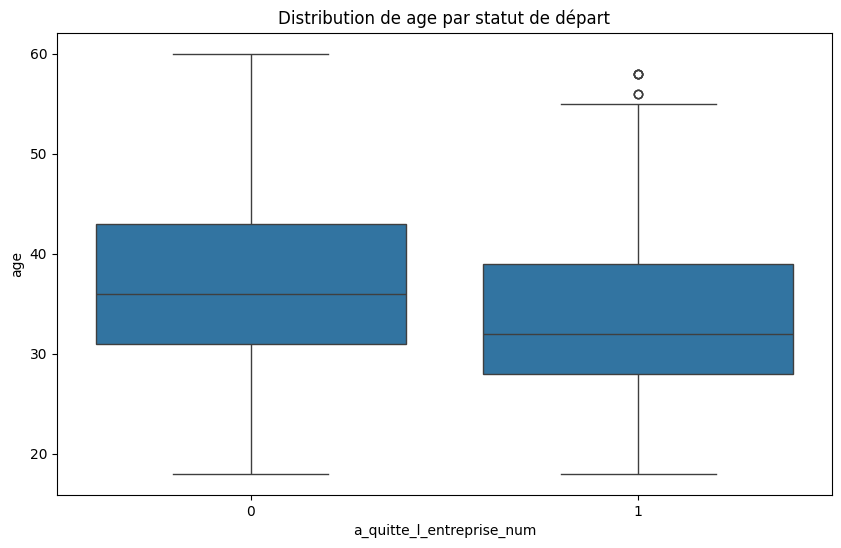

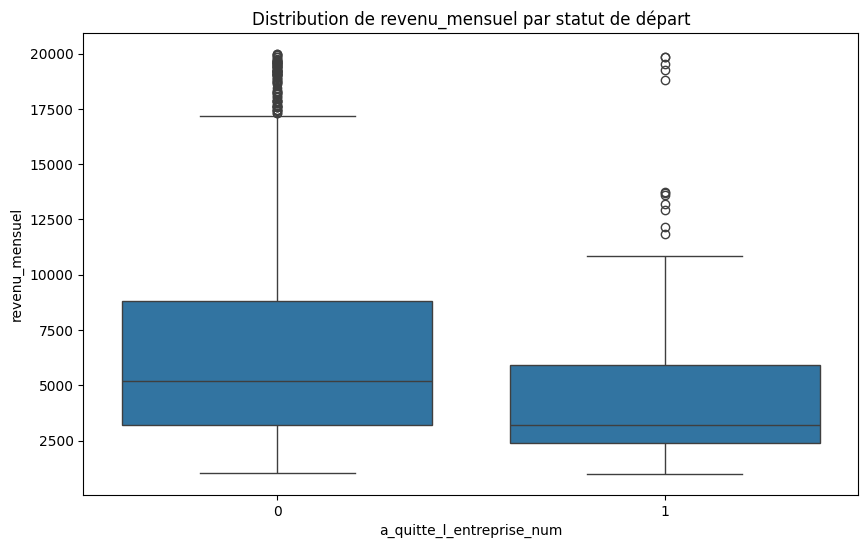

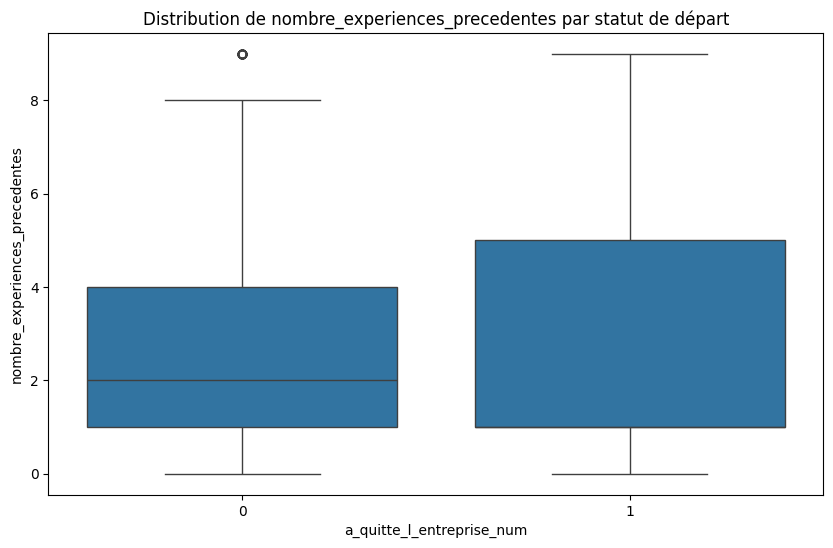

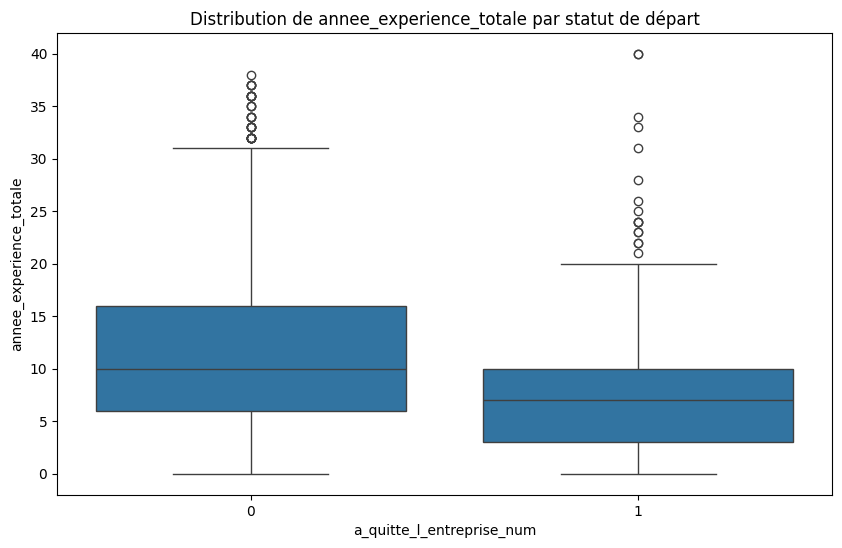

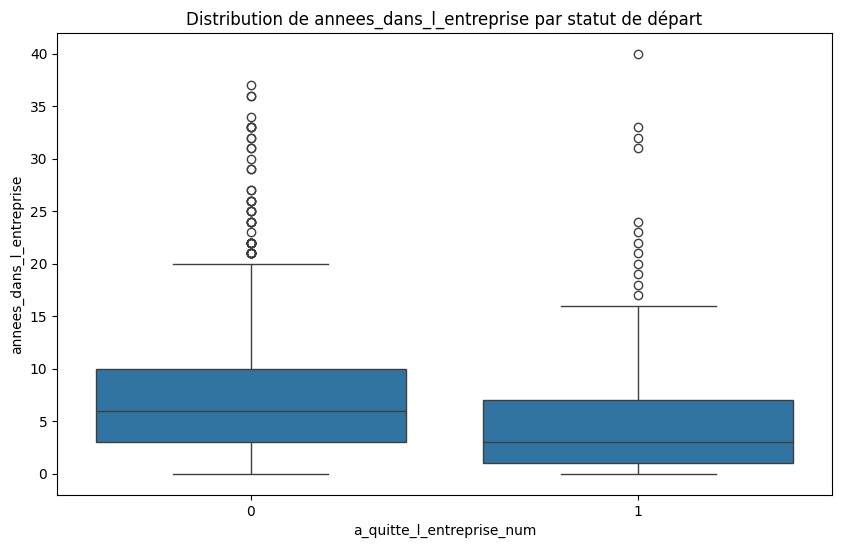

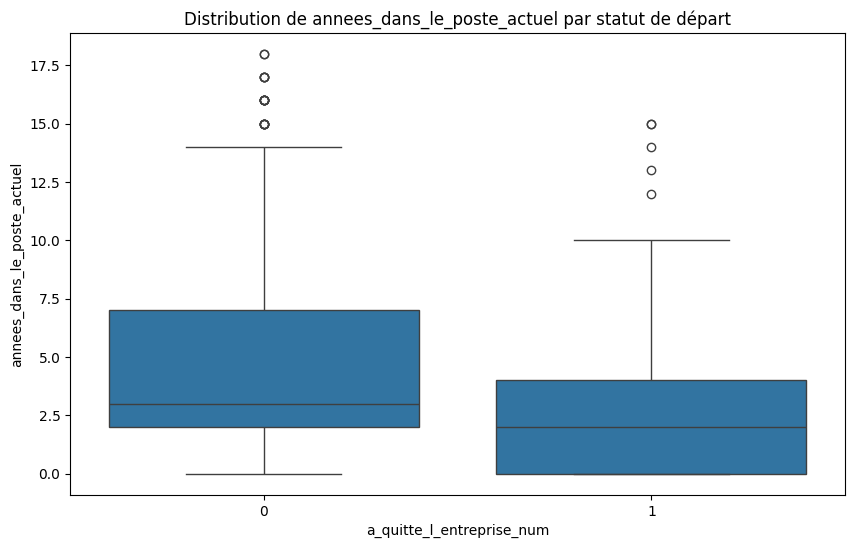

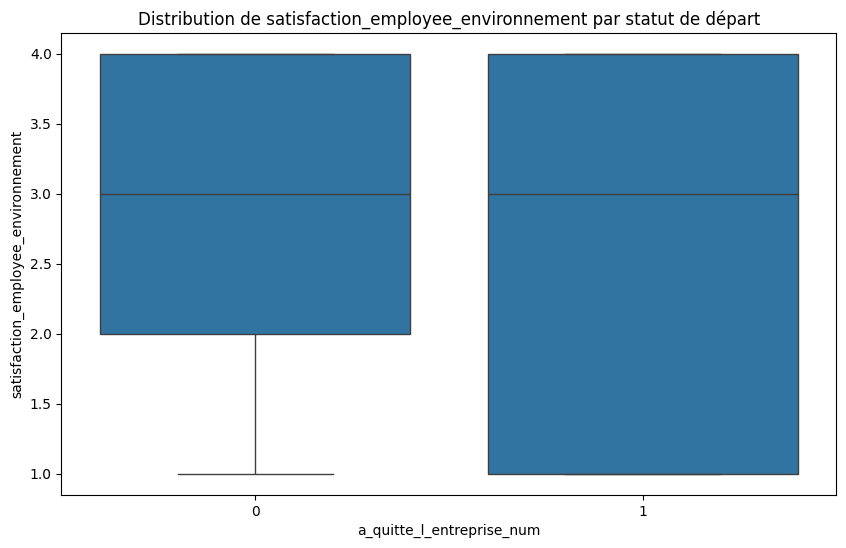

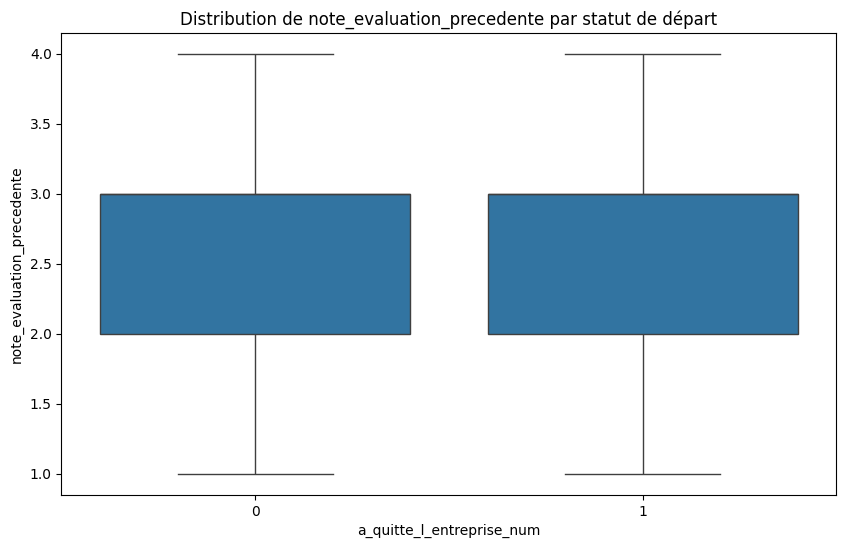

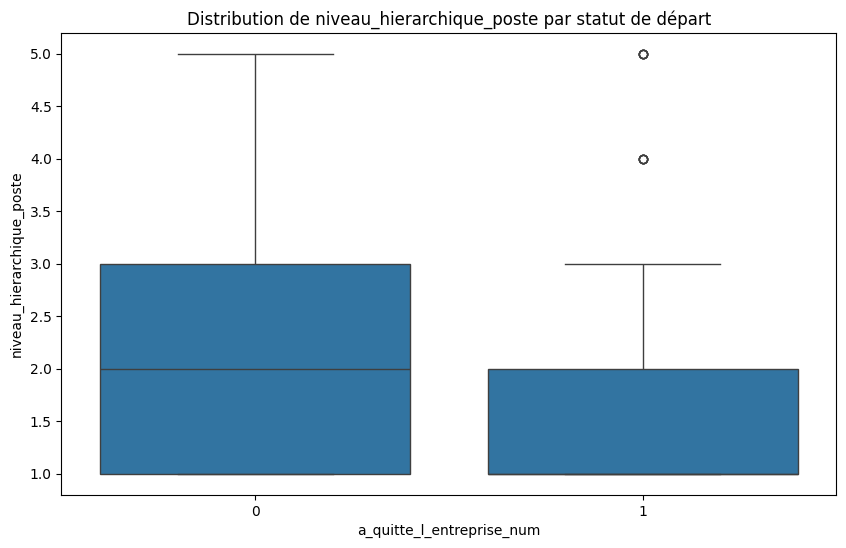

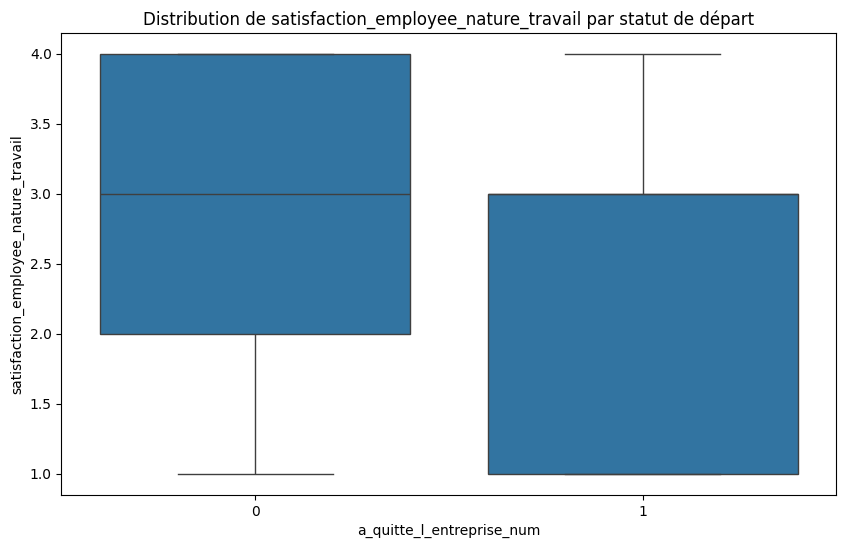

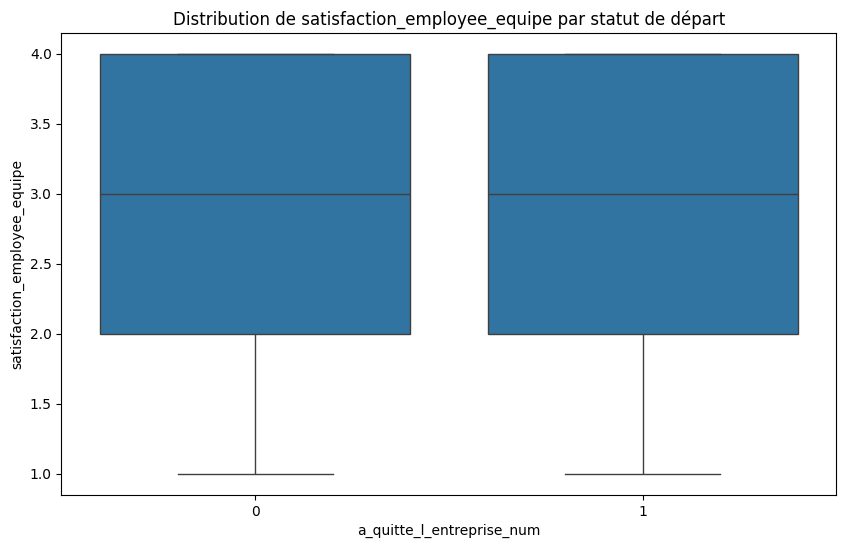

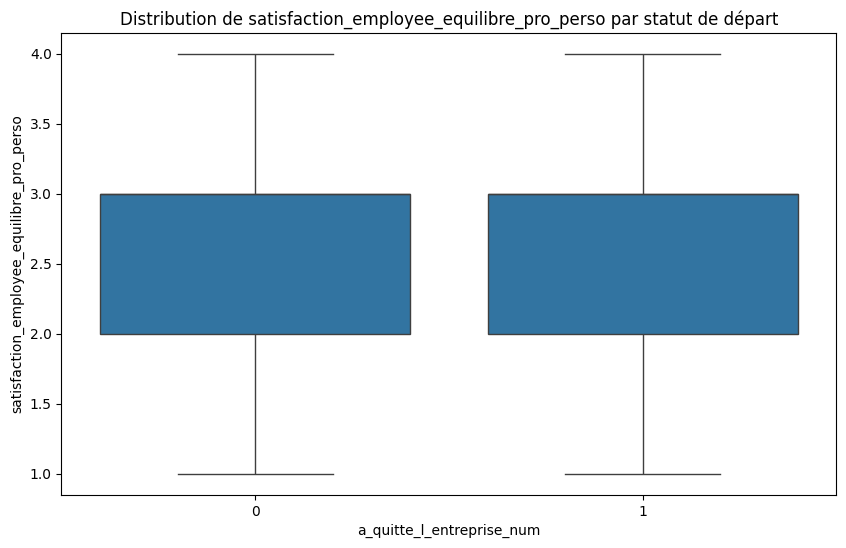

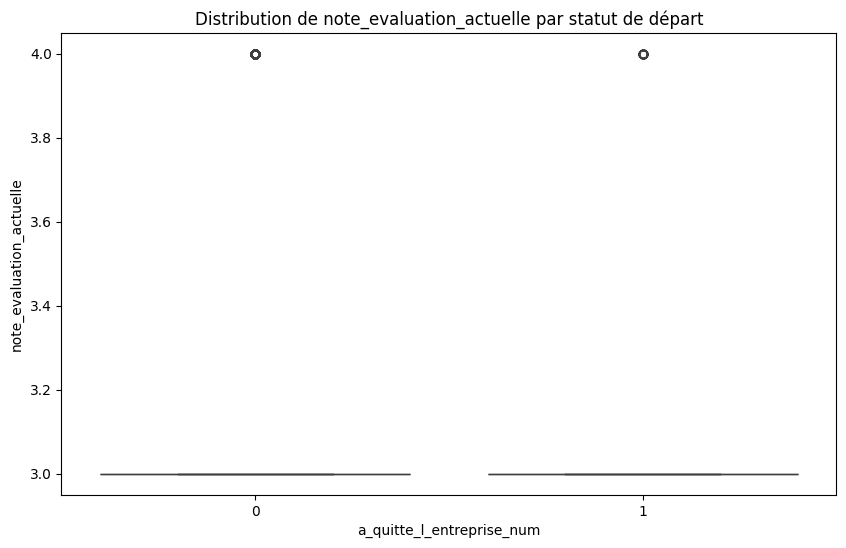

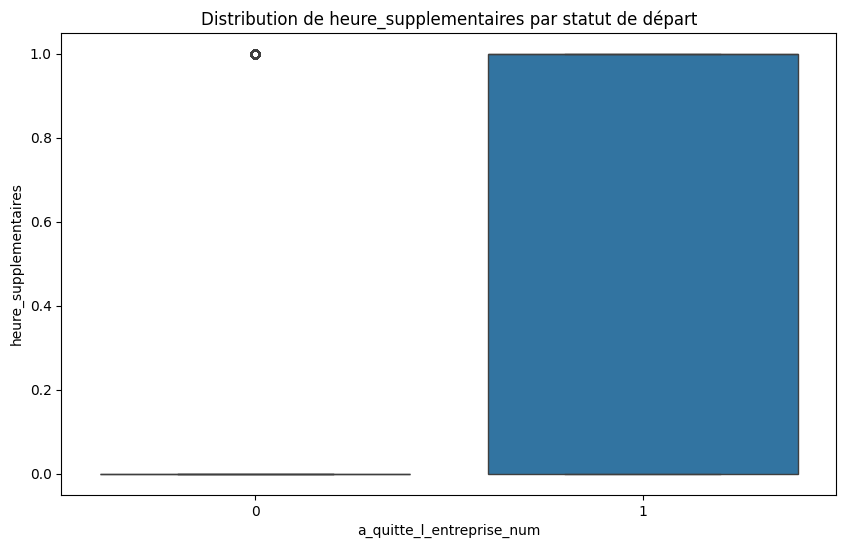

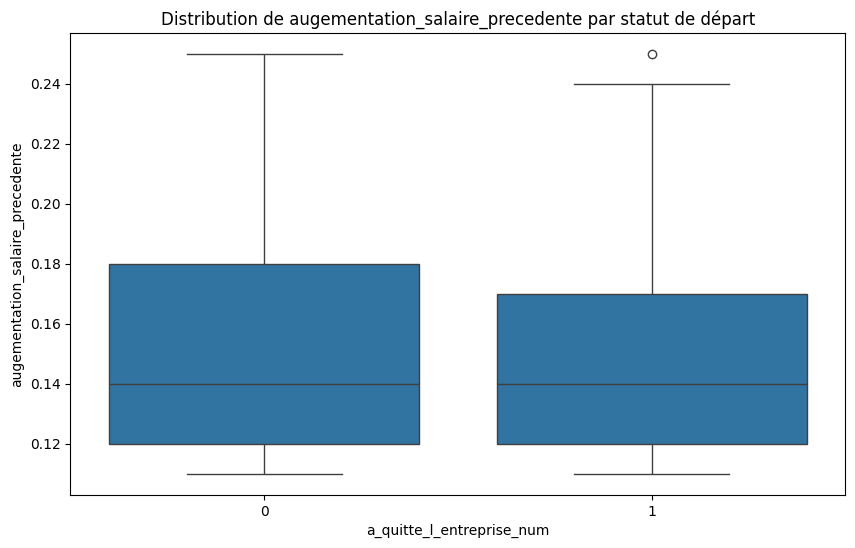

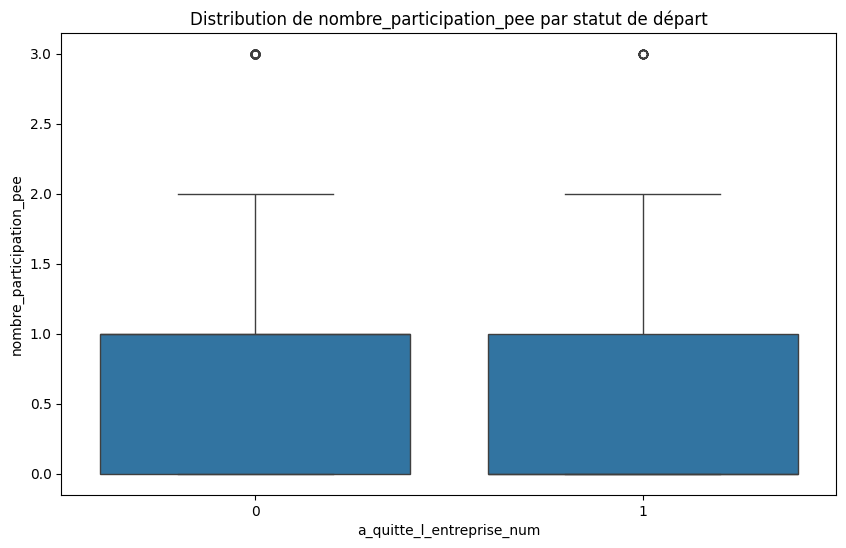

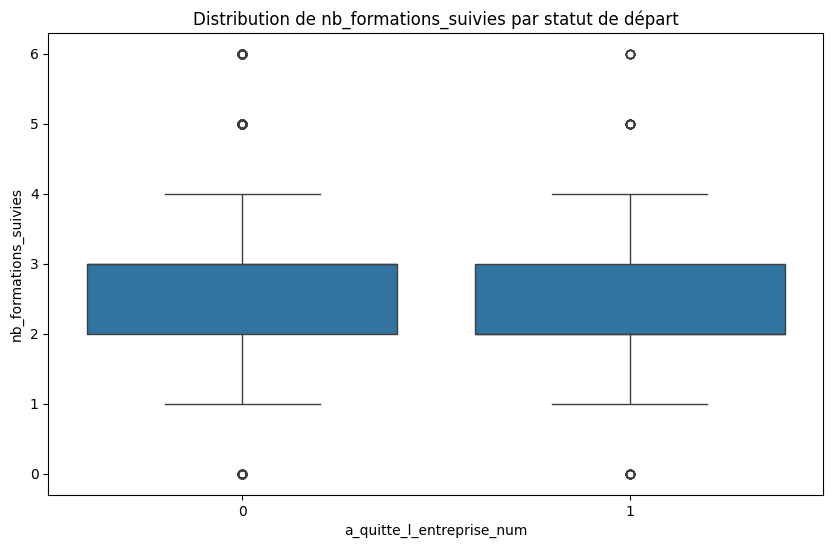

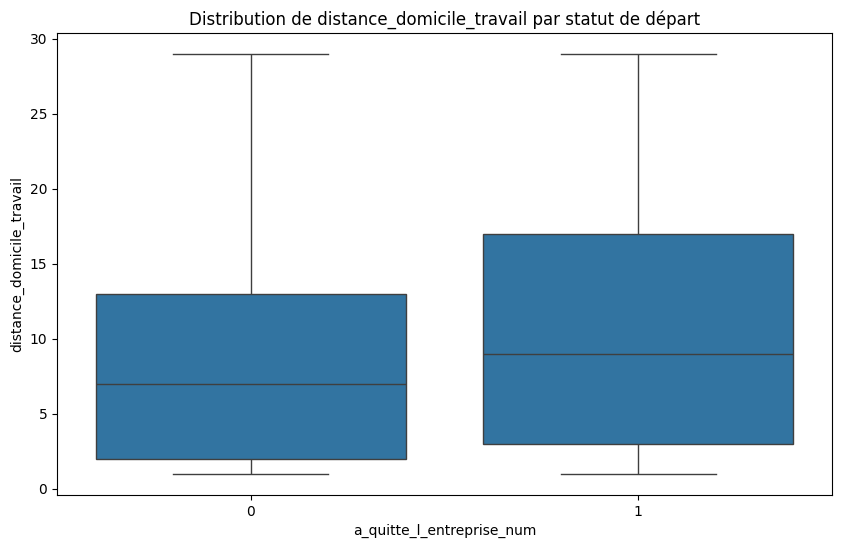

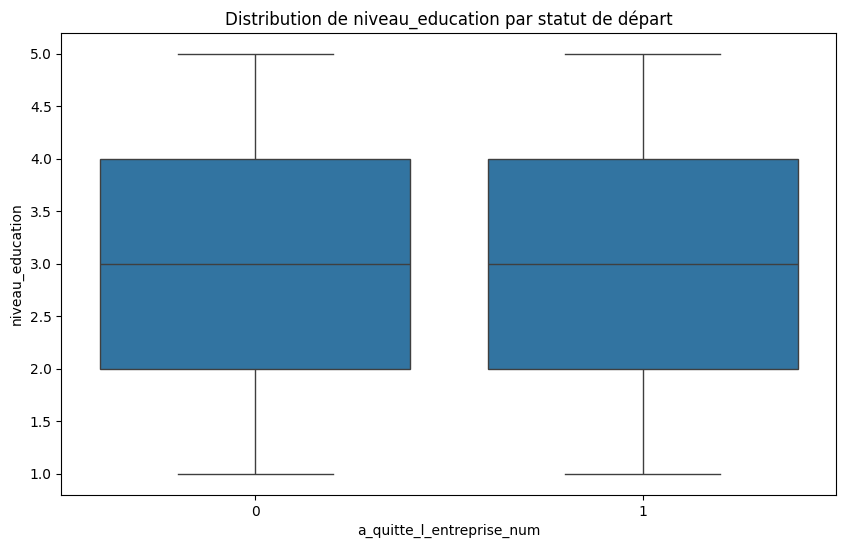

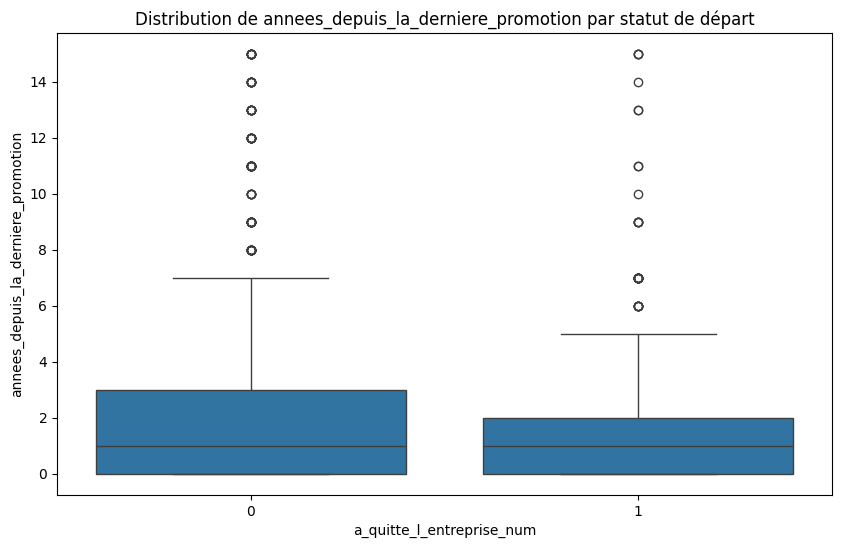

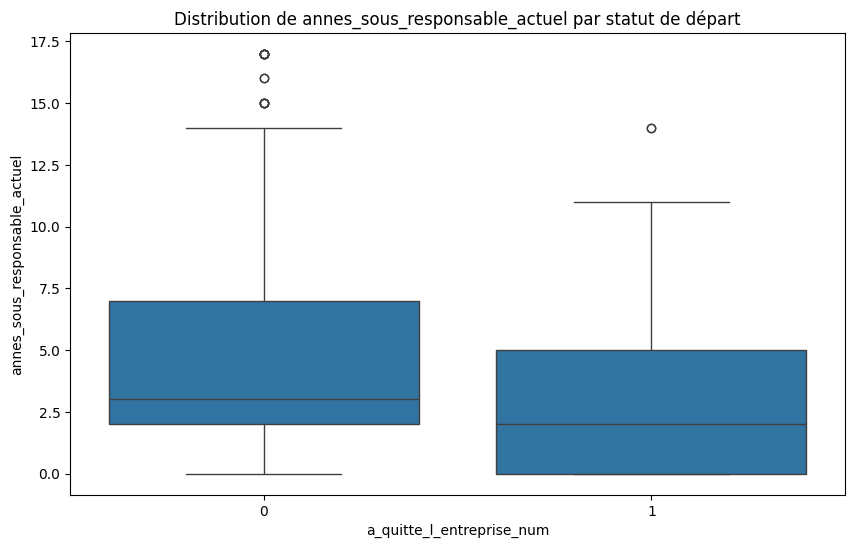

In [57]:
# Visualisation
for feature in features_num_to_analyse.drop('a_quitte_l_entreprise_num'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='a_quitte_l_entreprise_num', y=feature, data=df)
    plt.title(f'Distribution de {feature} par statut de départ')
    plt.show()

- **`a_quitte_l_entreprise_num` & `age`** : une différence significative dans la distribution de l'âge entre les deux groupes. Les employés qui quittent l'entreprise sont généralement plus jeunes que ceux qui restent

- **`a_quitte_l_entreprise_num` & `revenu_mensuel`** : les employés qui démissionnent ont tendance à être dans des tranches de revenus plus basses que leurs collègues qui restent.

- **`a_quitte_l_entreprise_num` & `nombre_experiences_precedentes`** : les employés qui quittent l'entreprise ont généralement plus d'expériences professionnelles que ceux qui restent.

- **`a_quitte_l_entreprise_num` & `annee_experience_totale`** : les employés qui ont moins d'années d'expérience totale ont plus tendance à démissionner.

- **`a_quitte_l_entreprise_num` & `annees_dans_l_entreprise`** : la majorité des départs se produisent dans les premières années d'ancienneté. Cela suggère que la période la plus critique pour la rétention est le début de carrière de l'employé au sein de votre entreprise.

- **`a_quitte_l_entreprise_num` & `annees_dans_le_poste_actuel`** : les démissions ont tendance à se produire chez les employés qui sont dans leur poste actuel depuis une période relativement courte. C'est un indicateur fort du fait que le manque d'évolution ou de changement de poste peut être un facteur de départ.

- **`a_quitte_l_entreprise_num` & `satisfaction_employee_environnement`** : Les employés qui démissionnent ont tendance à être moins satisfaits de leur environnement que ceux qui restent.

- **`a_quitte_l_entreprise_num` & `note_evaluation_precedente`** : la note d'évaluation précédente n'est pas un facteur discriminant pour la démission. Cela signifie que la démission n'est pas liée à une mauvaise performance perçue par l'entreprise. C'est le signe que le problème de démission est probablement lié à d'autres facteurs comme l'environnement de travail, le revenu, l'ancienneté ou la satisfaction professionnelle.

- **`a_quitte_l_entreprise_num` & `niveau_hierarchique_poste`** : les employés partis ont un niveau hiérarchique médian légèrement inférieur à ceux restés. Les postes moins élevés pourraient être associés à un turnover plus important.

- **`a_quitte_l_entreprise_num` & `satisfaction_employee_nature_travail`** : employés qui démissionnent ont tendance à être moins satisfaits de la nature de leur travail que ceux qui restent. Elle confirme que le contenu du poste lui-même est un facteur clé de la rétention des employés.

- **`a_quitte_l_entreprise_num` & `satisfaction_employee_equipe`** : la satisfaction envers l'équipe ne semble pas être un facteur déterminant dans la décision de quitter l'entreprise. Les employés partis et restés ont des niveaux de satisfaction similaires envers leur équipe.

- **`a_quitte_l_entreprise_num` & `satisfaction_employee_equilibre_pro_perso`** : employés qui démissionnent ont tendance à être moins satisfaits de cet équilibre que ceux qui restent.

- **`a_quitte_l_entreprise_num` & `note_evaluation_actuelle`** : la note d'évaluation actuelle n'est pas un facteur discriminant pour la démission. Cela renforce l'idée que les départs ne sont pas le résultat d'une performance jugée insuffisante. Les employés qui partent peuvent être de bons éléments, dont la décision est motivée par d'autres facteurs comme la satisfaction au travail, l'ancienneté ou le salaire.

- **`a_quitte_l_entreprise_num` & `heure_supplementaires`** : les employés qui font des heures supplémentaires ont plus tendance à quitter l'entreprise.

- **`a_quitte_l_entreprise_num` & `augmentation_salaire_precedente`** : les employés qui démissionnent ont tendance à recevoir des augmentations plus faibles que ceux qui restent. Les facteurs financiers et la reconnaissance sont des moteurs clés pour la rétention des employés.

- **`a_quitte_l_entreprise_num` & `nombre_participation_pee`** : les employés qui démissionnent ont tendance à ne pas participer au PEE, ce qui est un signe de désengagement ou d'un manque de projection à long terme dans l'entreprise.

- **`a_quitte_l_entreprise_num` & `nb_formations_suivies`** : la différence dans le nombre de formations suivies entre les employés partis et restés est très faible. La principale différence se situe au niveau de la médiane (3 vs 2), suggérant une très légère tendance où les employés restés ont un nombre de formations légèrement plus élevé. Cependant, les quartiles et l'étendue étant presque identiques, on ne peut pas conclure que suivre beaucoup de formations retient un employé, ni que ne pas en suivre le fait partir. Le nombre de formations suivies ne semble pas être un facteur déterminant ou fortement prédictif du départ d'un employé.

- **`a_quitte_l_entreprise_num` & `distance_domicile_travail`** : la distance domicile-travail est un facteur de risque de démission. Les employés qui ont un trajet plus long ont tendance à démissionner davantage que ceux qui habitent près de leur lieu de travail.

- **`a_quitte_l_entreprise_num` & `niveau_education`** : le niveau d'éducation ne semble pas être un facteur lié à la démission. Contrairement au revenu, à l'ancienneté ou à la satisfaction, la formation initiale des employés n'influence pas leur décision de quitter l'entreprise.

- **`a_quitte_l_entreprise_num` & `annee_depuis_la_derniere_promotion`** : les employés qui partent ont tendance à avoir été promus plus récemment.

- **`a_quitte_l_entreprise_num` & `annes_sous_responsable_actuel`** : les employés qui ont quitté l'entreprise ont passé significativement moins de temps avec leur manager actuel que ceux qui sont restés.

**Synthèse des facteurs de turnover : Analyse bivariée**

**Facteurs clés influençant les démissions**
Les employés qui quittent l'entreprise partagent des **profils types** et des **motivations communes**, principalement liées à :
- **L'âge et l'expérience** : Plus jeunes, avec plus d'expériences précédentes mais moins d'ancienneté dans l'entreprise.
- **La rémunération et la reconnaissance** : Revenus plus bas, augmentations salariales plus faibles, et manque de perspectives d'évolution.
- **La satisfaction au travail** : Insatisfaction vis-à-vis de la nature du travail, de l'environnement, et de l'équilibre vie pro/perso.
- **Les conditions de travail** : Heures supplémentaires fréquentes, trajets domicile-travail longs, et manque d'engagement à long terme (ex. : non-participation au PEE).

---

**Facteurs significatifs (à prioriser pour réduire le turnover)**
   **Variable**                          | **Insight**                                                                                     | **Action recommandée**                                                                                     |
 |---------------------------------------|------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------|
 | **Âge**                               | Employés partis sont **plus jeunes**.                                                          | Cibler les **jeunes talents** avec des programmes de mentorat et des parcours de carrière clairs.          |
 | **Revenu mensuel**                    | Salaire **plus bas** chez les partis.                                                          | Revoir la **grille salariale** et les **augmentations** pour les postes juniors.                           |
 | **Années dans l'entreprise**          | Départs concentrés dans les **premières années** (période critique : 0–3 ans).                | Renforcer l’**onboarding** et les **opportunités d’évolution rapide** pour les nouveaux embauchés.         |
 | **Ancienneté dans le poste actuel**   | Turnover élevé chez les employés **récemment arrivés dans leur poste**.                        | **Rotations internes** et **évolutions fréquentes** pour éviter la stagnation.                              |
 | **Satisfaction (nature du travail, équilibre pro/perso, environnement)** | **Moins satisfaits** sur ces 3 dimensions.                                                     | Améliorer les **conditions de travail**, la **flexibilité**, et l’**ergonomie des postes**.                |
 | **Niveau hiérarchique**               | Postes **moins élevés** plus touchés par le turnover.                                          | Offrir des **perspectives de promotion** et des **responsabilités accrues** aux postes juniors.            |
 | **Heures supplémentaires**           | Les employés faisant des **heures sup** quittent plus.                                        | Limiter les heures sup, promouvoir l’**équilibre vie pro/perso**, et compenser financièrement.             |
 | **Augmentations salariales**          | Augmentations **plus faibles** chez les partis.                                                | **Réviser la politique de rémunération** et lier les augmentations à la performance et à l’ancienneté.     |
 | **Participation au PEE**              | **Non-participation** au PEE = signe de désengagement.                                         | **Sensibiliser aux avantages du PEE** et simplifier l’adhésion.                                            |
 | **Distance domicile-travail**         | Trajets **plus longs** chez les partis (médiane : 9 km vs 7 km).                                | Étendre le **télétravail**, rembourser les frais de transport, ou ouvrir des bureaux satellites.           |
 | **Années sous le même responsable**   | Moins de temps avec leur **manager actuel** (relation récente ou instable ?).                 | **Former les managers** à la rétention et évaluer la qualité du management.                                |

---

**Facteurs non discriminants (peu ou pas liés au turnover)**
 | **Variable**                          | **Insight**                                                                                     |
 |---------------------------------------|------------------------------------------------------------------------------------------------|
 | **Notes d'évaluation**                | Aucune différence entre partis et restés → Les démissions ne sont **pas liées à la performance**. |
 | **Satisfaction envers l'équipe**      | Niveaux similaires → L’équipe n’est **pas un facteur clé** de départ.                          |
 | **Niveau d'éducation**                | Aucun lien → Le turnover ne dépend **pas du diplôme**.                                          |
 | **Nombre de formations suivies**      | Différence minime (médiane : 3 vs 2) → **Peu impactant**.                                       |
 | **Délai depuis la dernière promotion**| Les partis ont été promus **plus récemment** (contre-intuitif, à creuser).                     |

---

In [58]:
stats_par_groupe = df_final.groupby('a_quitte_l_entreprise_num')[['nombre_participation_pee']].describe().T

# Afficher le tableau de statistiques
print("Statistiques descriptives par groupe (0=resté, 1=parti):")
print(stats_par_groupe)

Statistiques descriptives par groupe (0=resté, 1=parti):
a_quitte_l_entreprise_num                 0           1
nombre_participation_pee count  1233.000000  237.000000
                         mean      0.845093    0.527426
                         std       0.841985    0.856361
                         min       0.000000    0.000000
                         25%       0.000000    0.000000
                         50%       1.000000    0.000000
                         75%       1.000000    1.000000
                         max       3.000000    3.000000


In [59]:
stats_par_groupe = df_final.groupby('a_quitte_l_entreprise_num')[['nb_formations_suivies']].describe().T

# Afficher le tableau de statistiques
print("Statistiques descriptives par groupe (0=resté, 1=parti):")
print(stats_par_groupe)

Statistiques descriptives par groupe (0=resté, 1=parti):
a_quitte_l_entreprise_num              0           1
nb_formations_suivies count  1233.000000  237.000000
                      mean      2.832928    2.624473
                      std       1.293585    1.254784
                      min       0.000000    0.000000
                      25%       2.000000    2.000000
                      50%       3.000000    2.000000
                      75%       3.000000    3.000000
                      max       6.000000    6.000000


In [60]:
stats_par_groupe = df_final.groupby('a_quitte_l_entreprise_num')[['annes_sous_responsable_actuel']].describe().T

# Afficher le tableau de statistiques
display(stats_par_groupe)

a_quitte_l_entreprise_num                      0           1
annes_sous_responsable_actuel count  1233.000000  237.000000
                              mean      4.367397    2.852321
                              std       3.594116    3.143349
                              min       0.000000    0.000000
                              25%       2.000000    0.000000
                              50%       3.000000    2.000000
                              75%       7.000000    5.000000
                              max      17.000000   14.000000

### Analyse bivarié : colonnes catégorielles et 'a_quitte_l_entreprise'

In [61]:
# Taux de démission global
taux_demission_global = df_final['a_quitte_l_entreprise'].value_counts(normalize=True).loc['Oui'] * 100
print(f"Taux de démission global de l'entreprise : {taux_demission_global:.2f}%\n")

Taux de démission global de l'entreprise : 16.12%



Analyse de la variable 'genre' :

a_quitte_l_entreprise       Non       Oui
genre                                    
F                      0.852041  0.147959
M                      0.829932  0.170068




C:\Users\artur\AppData\Local\Temp\ipykernel_26452\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


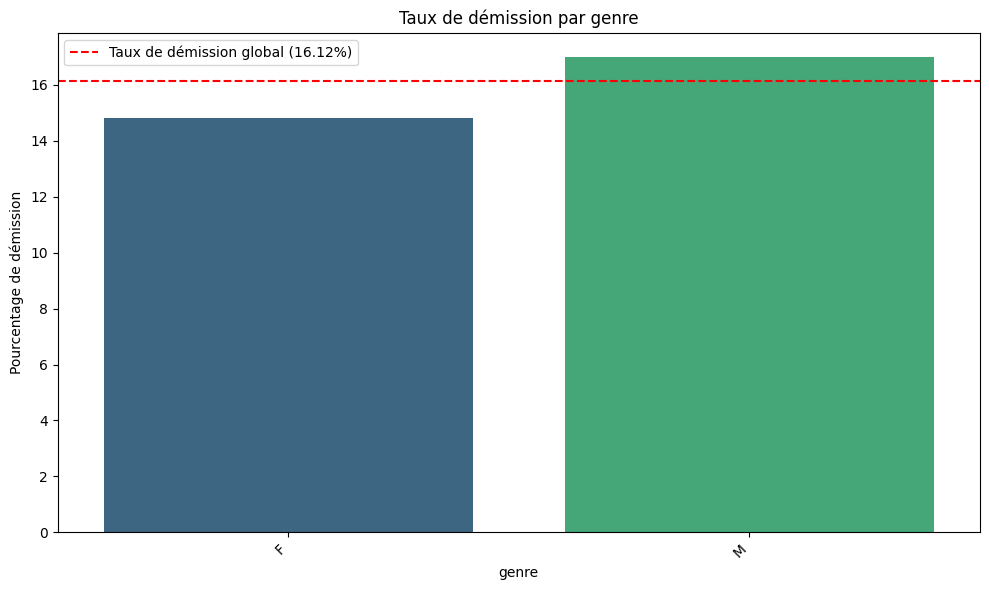

Analyse de la variable 'statut_marital' :

a_quitte_l_entreprise       Non       Oui
statut_marital                           
Célibataire            0.744681  0.255319
Divorcé(e)             0.899083  0.100917
Marié(e)               0.875186  0.124814




C:\Users\artur\AppData\Local\Temp\ipykernel_26452\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


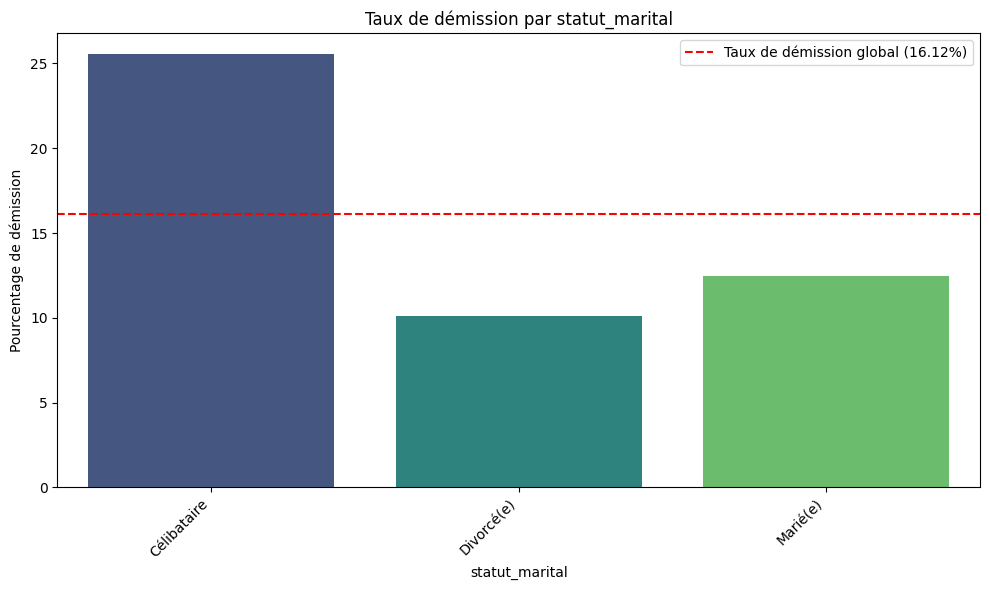

Analyse de la variable 'departement' :

a_quitte_l_entreprise       Non       Oui
departement                              
Commercial             0.793722  0.206278
Consulting             0.861602  0.138398
Ressources Humaines    0.809524  0.190476




C:\Users\artur\AppData\Local\Temp\ipykernel_26452\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


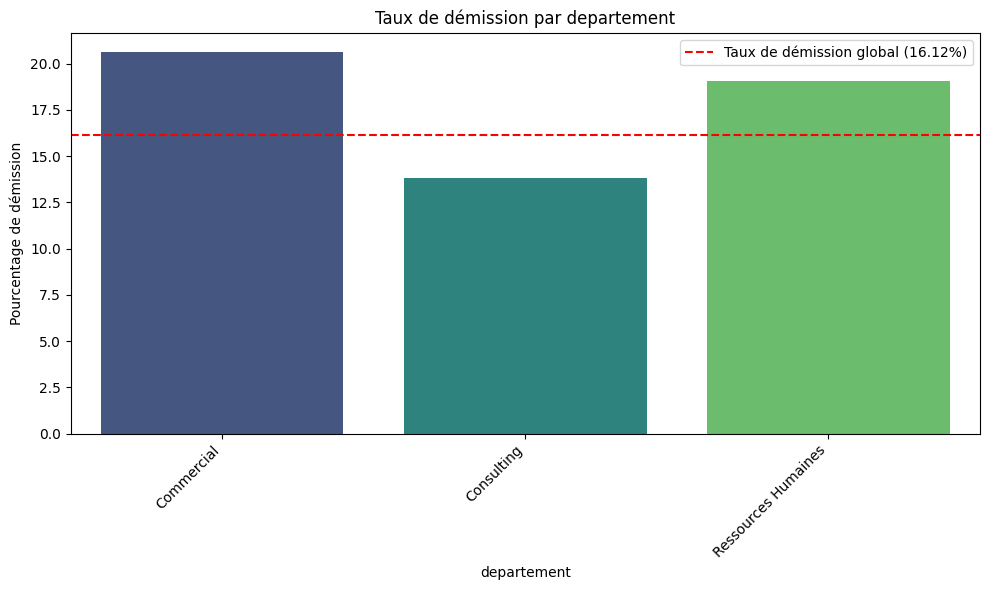

C:\Users\artur\AppData\Local\Temp\ipykernel_26452\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


Analyse de la variable 'poste' :

a_quitte_l_entreprise         Non       Oui
poste                                      
Assistant de Direction   0.839041  0.160959
Cadre Commercial         0.825153  0.174847
Consultant               0.760618  0.239382
Directeur Technique      0.975000  0.025000
Manager                  0.931298  0.068702
Représentant Commercial  0.602410  0.397590
Ressources Humaines      0.769231  0.230769
Senior Manager           0.950980  0.049020
Tech Lead                0.931034  0.068966




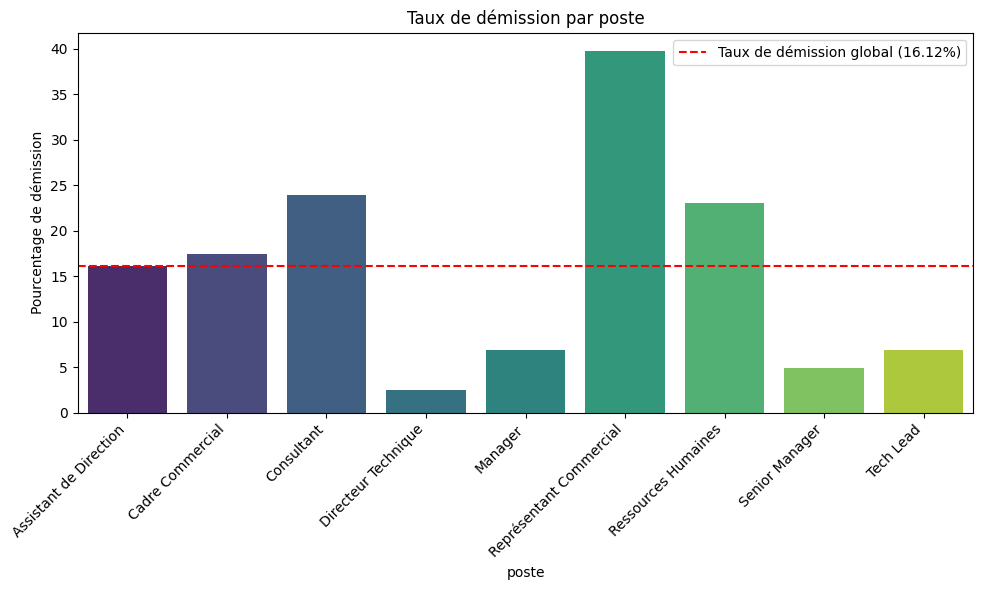

Analyse de la variable 'domaine_etude' :

a_quitte_l_entreprise         Non       Oui
domaine_etude                              
Autre                    0.865854  0.134146
Entrepreunariat          0.757576  0.242424
Infra & Cloud            0.853135  0.146865
Marketing                0.779874  0.220126
Ressources Humaines      0.740741  0.259259
Transformation Digitale  0.864224  0.135776




C:\Users\artur\AppData\Local\Temp\ipykernel_26452\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


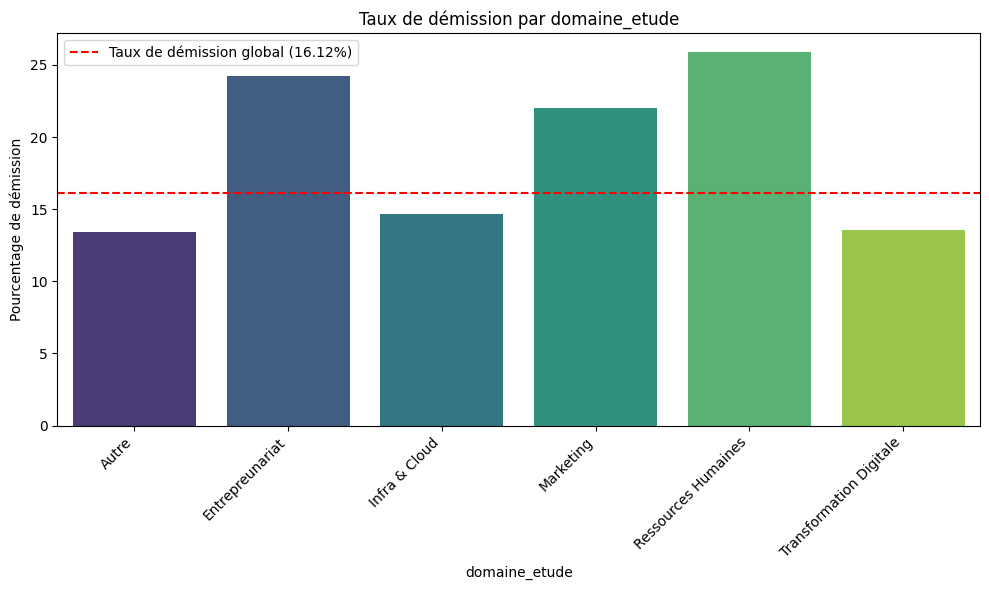

Analyse de la variable 'ayant_enfants' :

a_quitte_l_entreprise       Non       Oui
ayant_enfants                            
Y                      0.838776  0.161224




C:\Users\artur\AppData\Local\Temp\ipykernel_26452\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


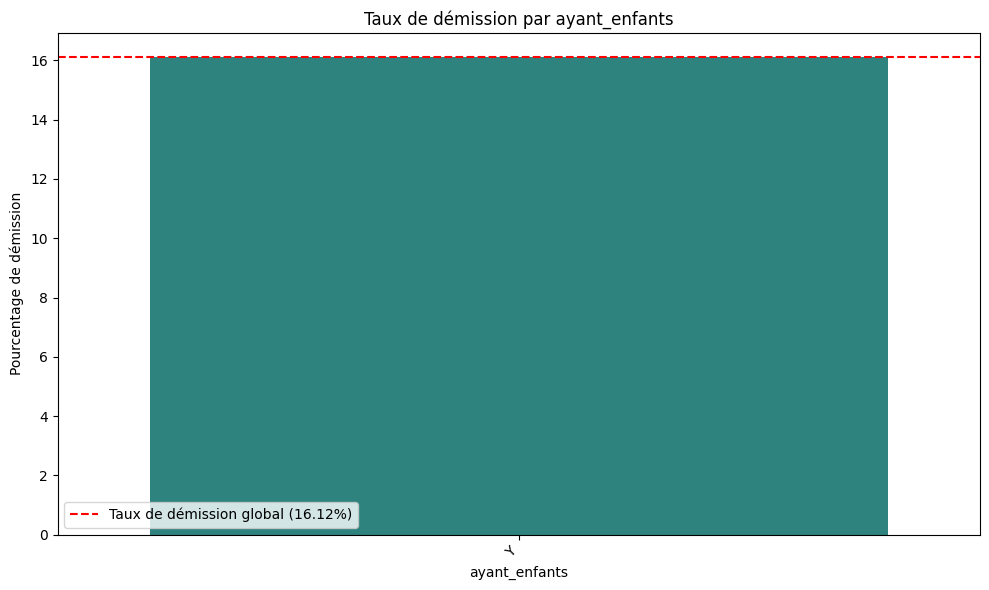

Analyse de la variable 'frequence_deplacement' :

a_quitte_l_entreprise       Non       Oui
frequence_deplacement                    
Aucun                  0.920000  0.080000
Frequent               0.750903  0.249097
Occasionnel            0.850431  0.149569




C:\Users\artur\AppData\Local\Temp\ipykernel_26452\1754207288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')


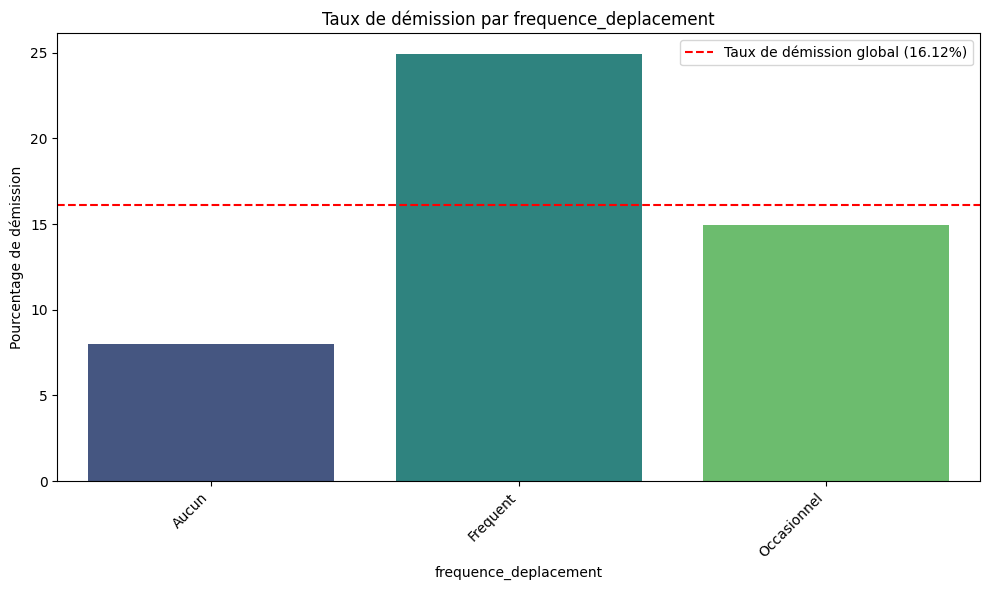

In [62]:
for col in categorical_cols:
    if col != 'a_quitte_l_entreprise':
        # Calculer les pourcentages de démission par catégorie
        df_group = (df_final.groupby([col, 'a_quitte_l_entreprise']).size().unstack(fill_value=0)
                    .apply(lambda x: x / x.sum(), axis=1))

        # Afficher la table des pourcentages
        print(f"Analyse de la variable '{col}' :\n")
        print(df_group.to_string())
        print("\n" + "="*50 + "\n")

        # Créer le diagramme en barres
        plt.figure(figsize=(10, 6))
        sns.barplot(x=df_group.index, y=df_group['Oui'] * 100, palette='viridis')
        
        # Ajouter une ligne pour le taux de démission global
        plt.axhline(y=taux_demission_global, color='red', linestyle='--', label=f'Taux de démission global ({taux_demission_global:.2f}%)')
        
        plt.title(f'Taux de démission par {col}')
        plt.xlabel(col)
        plt.ylabel('Pourcentage de démission')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

- `a_quitte_l_entreprise` & `genre` : Le taux de démission est plus élevé chez les hommes que chez les femmes dans votre entreprise. Toutefois, la différence entre les deux pourcentages est relativement faible (17.01%−14.79%=2.22%). Cela suggère que le genre n'est pas le facteur le plus déterminant pour expliquer le turnover, mais il existe une légère tendance.

- `a_quitte_l_entreprise` & `statut_marital` : Les célibataires sont beaucoup plus enclins à quitter l'entreprise que les employés mariés ou divorcés. Le taux de démission chez les célibataires est presque deux fois supérieur à celui des employés mariés, et deux fois et demie supérieur à celui des divorcés.

- `a_quitte_l_entreprise` & `departement` : Le département est clairement un facteur discriminant dans le turnover des employés. (Commercial > RH > Consulting)

- `a_quitte_l_entreprise` & `poste` :
     - Postes à risque élevé :
        - Représentant Commercial (39.76%) : Taux 2.5 fois supérieur à la moyenne.
        - Consultant (23.94%)
        - Ressources Humaines (23.08%)
    
    - Poste dans la moyenne :
        - Cadre Commercial (17.45%)
        - Assistant de Direction (16.10%)

    - Postes stables :
        - Tech Lead (6.89%)
        - Manager (6.87%)
        - Senior Manager (4.92%)
        - Directeur Technique (2.50%)

- `a_quitte_l_entreprise` & `domaine_etude` : Les diplômés en RH, Entrepreneuriat et Marketing quittent significativement plus l'entreprise

- `a_quitte_l_entreprise` & `ayant_enfants` : **ayant_enfants** est une constante, une étude statistique n'a pas de sense.

- `a_quitte_l_entreprise` & `frequence_deplacement` : Les employés qui se déplacent fréquemment quittent 1.55 fois plus que la moyenne.

# Etape 2 : préparation des données pour la modélisation

In [63]:
df_model = df_final.drop(['a_quitte_l_entreprise'], axis=1)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_employee                                1470 non-null   int64  
 1   age                                        1470 non-null   int64  
 2   genre                                      1470 non-null   object 
 3   revenu_mensuel                             1470 non-null   int64  
 4   statut_marital                             1470 non-null   object 
 5   departement                                1470 non-null   object 
 6   poste                                      1470 non-null   object 
 7   nombre_experiences_precedentes             1470 non-null   int64  
 8   nombre_heures_travailless                  1470 non-null   int64  
 9   annee_experience_totale                    1470 non-null   int64  
 10  annees_dans_l_entreprise

## Séparation des données en X et y

In [64]:
# Fonction pour préparer les données pour le modèle
def prepare_data_for_modeling(df, target_column):
    """
    Sépare les features (X) et la variable cible (y) du DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données brutes.

    Returns:
        tuple: Un tuple (X, y) où X est le DataFrame des features et y est la série de la cible.
    """
    # S'assurer que la colonne cible est présente
    if target_column not in df.columns:
        print(f"Erreur: La colonne '{target_column}' n'est pas présente dans le DataFrame.")
        return None, None

    # Séparer les features et la cible
    X = df.drop(columns=[target_column])
    y = df[target_column]

    print("Données séparées avec succès !")
    print(f"Dimension de X (features): {X.shape}")
    print(f"Dimension de y (cible): {y.shape}")
    
    return X, y

In [65]:
# Définir la colonne cible
target_column = 'a_quitte_l_entreprise_num'

X, y = prepare_data_for_modeling(df_model, target_column)

Données séparées avec succès !
Dimension de X (features): (1470, 31)
Dimension de y (cible): (1470,)


In [66]:
# Identification des features qualitatives et quantitatives
qualitative_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
quantitative_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Features qualitatives:", qualitative_features)
print("Features quantitatives:", quantitative_features)

Features qualitatives: ['genre', 'statut_marital', 'departement', 'poste', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']
Features quantitatives: ['id_employee', 'age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']


Les colonnes suivantes n'ont aucun impact sur la prédication :
- **'nombre_heures_travailless'** est une constante '80'
- **'ayant_enfants'** est également une constante, uniquement 'Y'

In [67]:
# Colonnes à supprimer car elles n'apportent pas d'information pertinente
columns_to_drop = ['nombre_heures_travailless', 'ayant_enfants']

df_final = df_final.drop(columns=columns_to_drop)
print("Données nettoyées avec succès !")
print(f"Dimension de df_final: {df_final.shape}")

X = X.drop(columns=columns_to_drop)
print("\nDonnées séparées et nettoyées avec succès !")
print(f"Dimension de X (features): {X.shape}")
print(f"Dimension de y (cible): {y.shape}")


Données nettoyées avec succès !
Dimension de df_final: (1470, 31)

Données séparées et nettoyées avec succès !
Dimension de X (features): (1470, 29)
Dimension de y (cible): (1470,)


## Encodage des variables

In [68]:
from sklearn.preprocessing import OneHotEncoder

# Initialiser l'encodeur
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# Identifier les colonnes de type 'object' ou 'category'
categorical_features = df_final.select_dtypes(include=['object', 'category']).columns.tolist()

# Ajuster et transformer les données catégorielles
encoded_features = ohe.fit_transform(df[categorical_features])

In [69]:
# Créer un DataFrame avec les nouvelles colonnes encodées
encoded_feature_names = ohe.get_feature_names_out(categorical_features)
df_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X.index)

# Concaténer le DataFrame des features numériques et le DataFrame encodé
df_processed = pd.concat([df_final.drop(columns=categorical_features), df_encoded], axis=1)

print("\nEncodage One-Hot des variables catégorielles terminé.")
print(f"Nouvelle dimension de df_processed (après encodage): {df_processed.shape}")


Encodage One-Hot des variables catégorielles terminé.
Nouvelle dimension de df_processed (après encodage): (1470, 45)


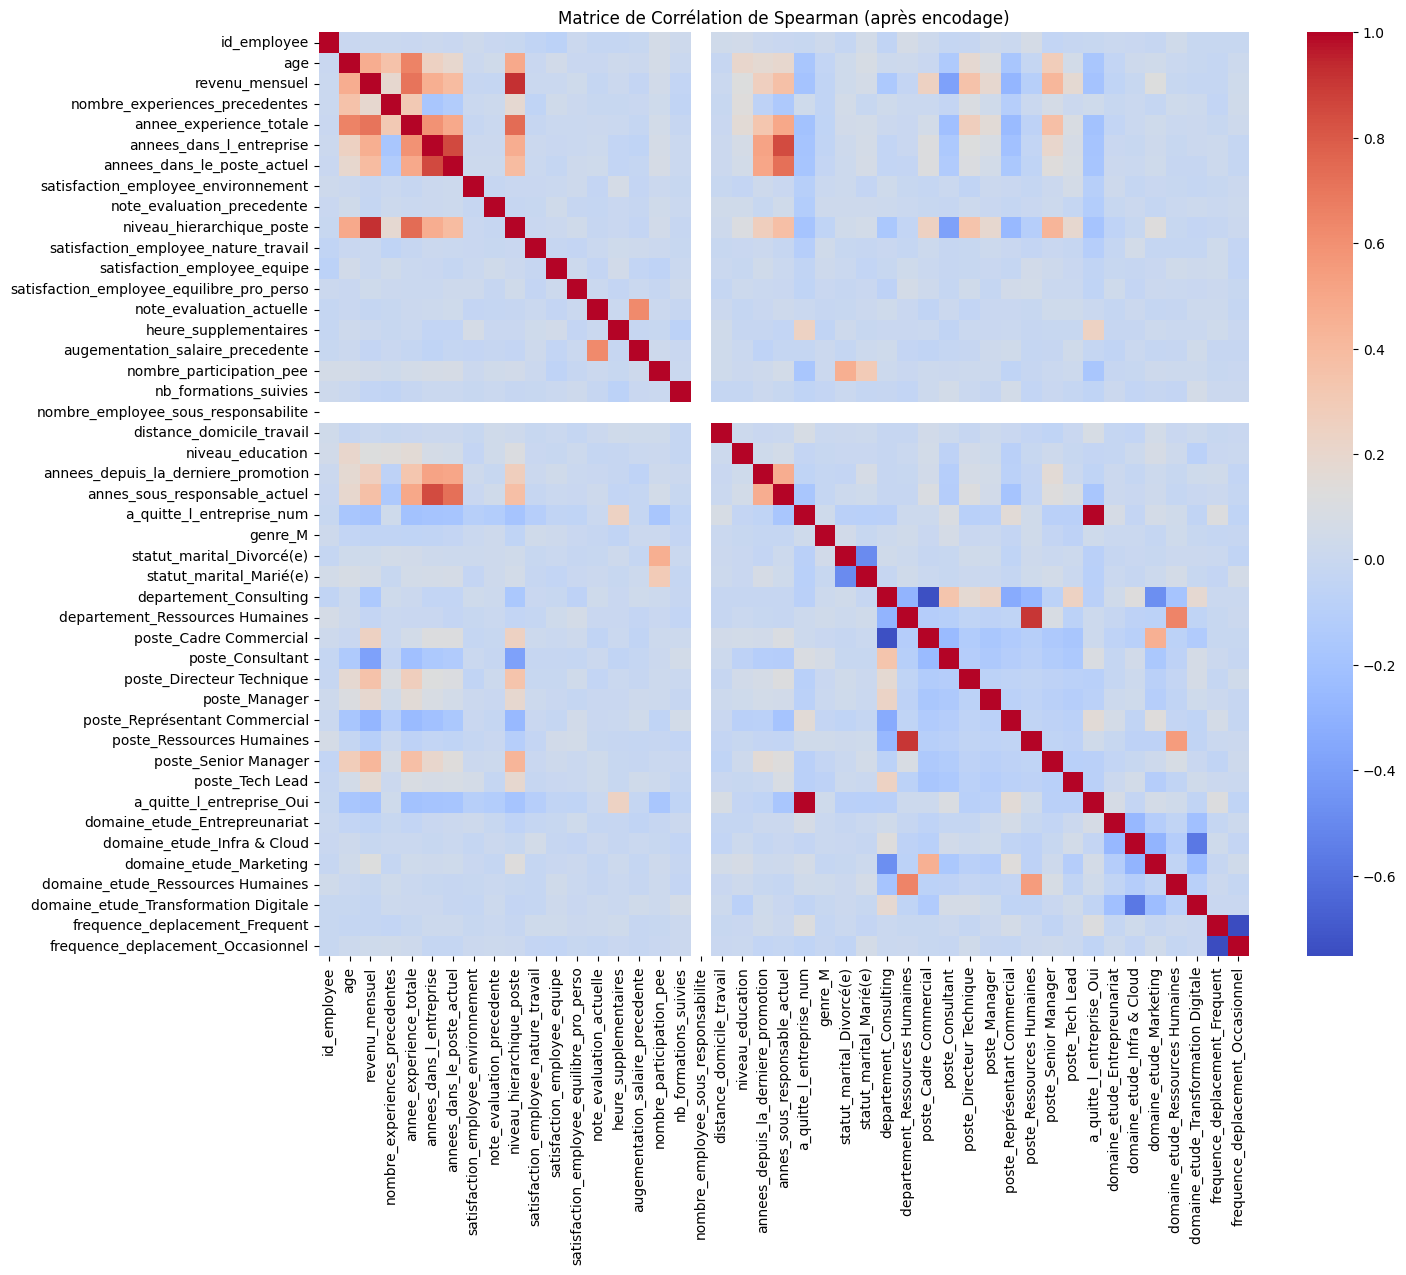

In [70]:
# Afficher la matrice de corrélation pour les features traitées
plt.figure(figsize=(15, 12))
correlation_matrix = df_processed.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Matrice de Corrélation de Spearman (après encodage)")
plt.show()

In [71]:
# Trouver les paires de features avec une forte corrélation
# Créer une matrice de corrélation de Pearson
corr_matrix = df_processed.corr(method='spearman').abs()

# Isoler le triangle supérieur de la matrice pour éviter les doublons
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les colonnes avec une corrélation supérieure à 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Afficher les paires de colonnes fortement corrélées
print("\nPaires de features fortement corrélées (> 0.70) :")
for i in range(len(upper.columns)):
    for j in range(i + 1, len(upper.columns)):
        if upper.iloc[i, j] > 0.70:
            print(f"- '{upper.columns[i]}' et '{upper.columns[j]}' : {upper.iloc[i, j]:.2f}")

# Si des colonnes sont à supprimer, cela sera listé ici
if to_drop:
    print(f"\nColonnes à considérer pour la suppression : {to_drop}")
    print(f"Nombre total de colonnes à supprimer : {len(to_drop)}")
    print(f"Dimension de X avant suppression : {df_processed.shape[1]}")
    print(f"Dimension de X après suppression : {df_processed.shape[1] - len(to_drop)}")
else:
    print("\nAucune forte corrélation identifiée (seuil de 0.70).")


Paires de features fortement corrélées (> 0.70) :
- 'revenu_mensuel' et 'annee_experience_totale' : 0.71
- 'revenu_mensuel' et 'niveau_hierarchique_poste' : 0.92
- 'annee_experience_totale' et 'niveau_hierarchique_poste' : 0.73
- 'annees_dans_l_entreprise' et 'annees_dans_le_poste_actuel' : 0.85
- 'annees_dans_l_entreprise' et 'annes_sous_responsable_actuel' : 0.84
- 'annees_dans_le_poste_actuel' et 'annes_sous_responsable_actuel' : 0.72
- 'a_quitte_l_entreprise_num' et 'a_quitte_l_entreprise_Oui' : 1.00
- 'departement_Consulting' et 'poste_Cadre Commercial' : 0.73
- 'departement_Ressources Humaines' et 'poste_Ressources Humaines' : 0.90
- 'frequence_deplacement_Frequent' et 'frequence_deplacement_Occasionnel' : 0.75

Colonnes à considérer pour la suppression : ['annee_experience_totale', 'annees_dans_le_poste_actuel', 'niveau_hierarchique_poste', 'annes_sous_responsable_actuel', 'poste_Cadre Commercial', 'poste_Ressources Humaines', 'a_quitte_l_entreprise_Oui', 'frequence_deplacement

In [72]:
df_processed = df_processed.drop(columns=to_drop)

In [73]:
# Trouver les paires de features avec une forte corrélation
# Créer une matrice de corrélation de Pearson
corr_matrix = df_processed.corr(method='spearman').abs()

# Isoler le triangle supérieur de la matrice pour éviter les doublons
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Trouver les colonnes avec une corrélation supérieure à 0.70
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Afficher les paires de colonnes fortement corrélées
print("\nPaires de features fortement corrélées (> 0.70) :")
for i in range(len(upper.columns)):
    for j in range(i + 1, len(upper.columns)):
        if upper.iloc[i, j] > 0.70:
            print(f"- '{upper.columns[i]}' et '{upper.columns[j]}' : {upper.iloc[i, j]:.2f}")

# Si des colonnes sont à supprimer, cela sera listé ici
if to_drop:
    print(f"\nColonnes à considérer pour la suppression : {to_drop}")
else:
    print("\nAucune forte corrélation identifiée (seuil de 0.70).")


Paires de features fortement corrélées (> 0.70) :

Aucune forte corrélation identifiée (seuil de 0.70).


In [74]:
df_processed.shape

(1470, 37)

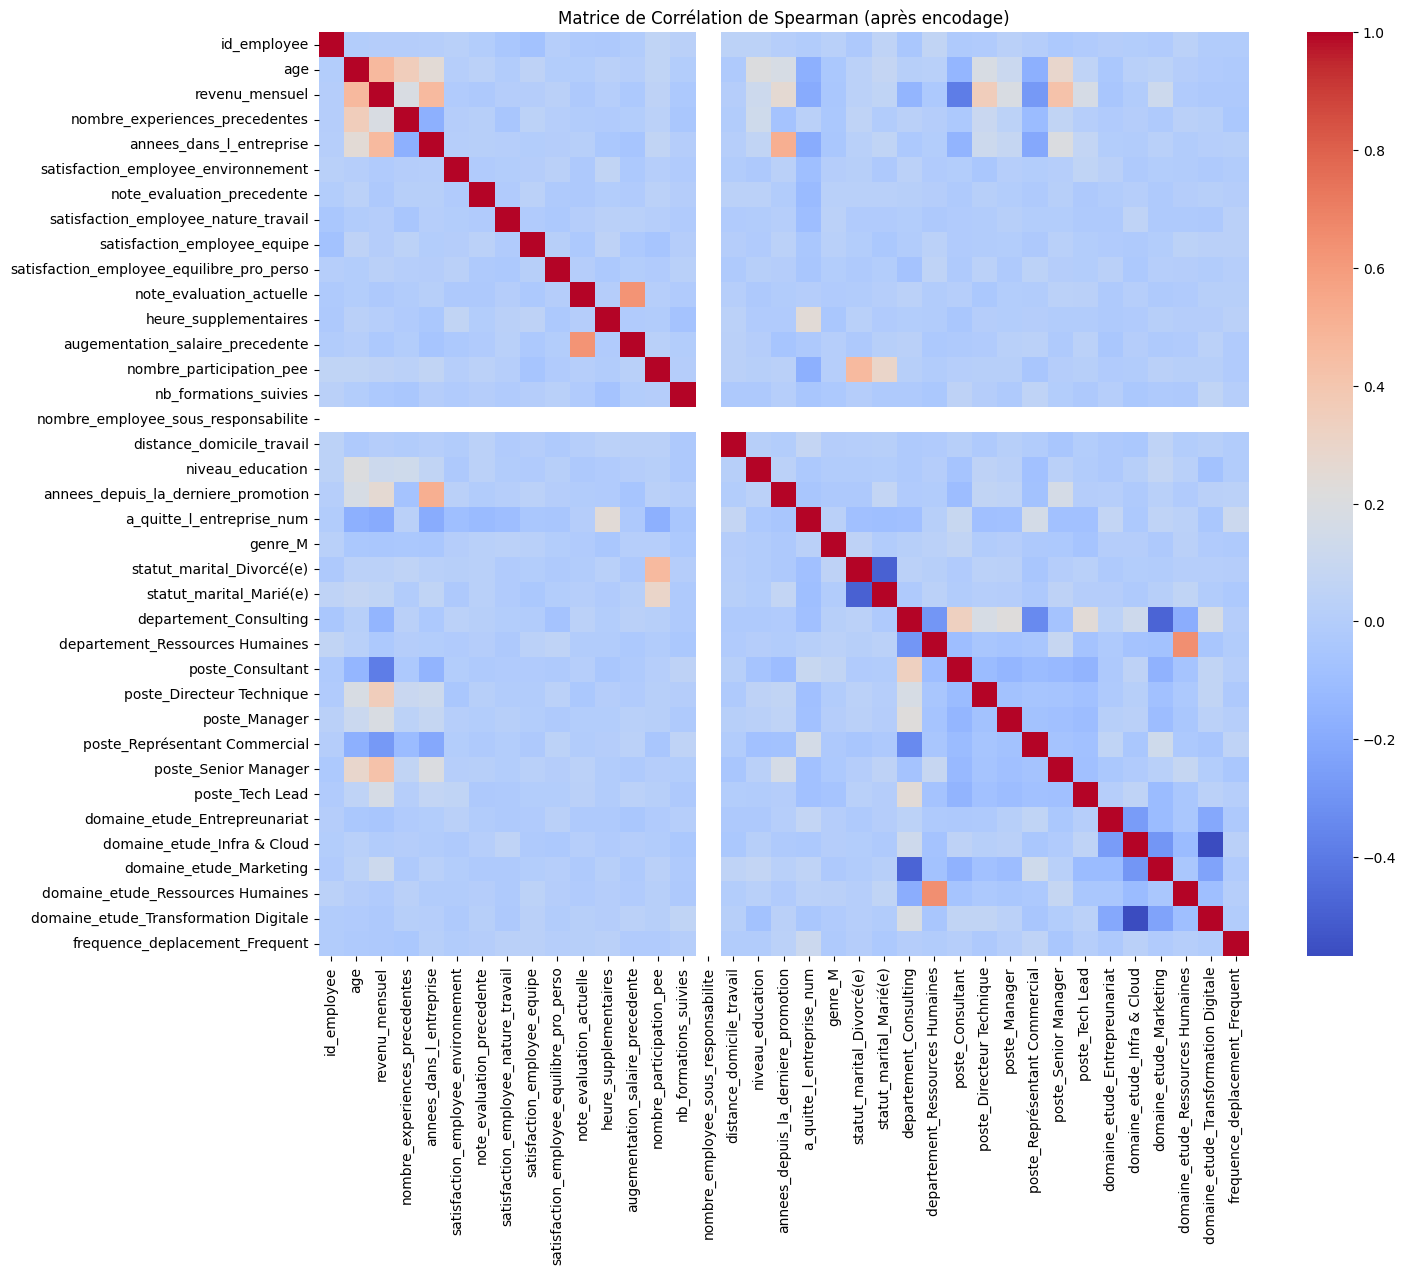

In [75]:
# Afficher la matrice de corrélation pour les features traitées
plt.figure(figsize=(15, 12))
correlation_matrix = df_processed.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Matrice de Corrélation de Spearman (après encodage)")
plt.show()

In [76]:
df_final = df_processed
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id_employee                                1470 non-null   int64  
 1   age                                        1470 non-null   int64  
 2   revenu_mensuel                             1470 non-null   int64  
 3   nombre_experiences_precedentes             1470 non-null   int64  
 4   annees_dans_l_entreprise                   1470 non-null   int64  
 5   satisfaction_employee_environnement        1470 non-null   int64  
 6   note_evaluation_precedente                 1470 non-null   int64  
 7   satisfaction_employee_nature_travail       1470 non-null   int64  
 8   satisfaction_employee_equipe               1470 non-null   int64  
 9   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64  
 10  note_evaluation_actuelle

# Etape 3 : réalisation d'un premier modèle de classification

- Modèles :
    - Dummy
    - Linéaire : LogisticRegression
    - Non-Linéaire : RandomForest, XGBoost ou CatBoost

In [77]:
X, y = prepare_data_for_modeling(df_final, target_column)

Données séparées avec succès !
Dimension de X (features): (1470, 36)
Dimension de y (cible): (1470,)


In [78]:
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Sépare les données en ensembles d'apprentissage et de test.

    Args:
        X (pd.DataFrame): Le DataFrame des features.
        y (pd.Series): La série de la variable cible.
        test_size (float): La proportion de l'ensemble de données à inclure dans le test split.
        random_state (int): Le nombre aléatoire pour la reproductibilité.

    Returns:
        tuple: Un tuple contenant (X_train, X_test, y_train, y_test).
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print("Données séparées avec succès !")
    print(f"Dimension de X_train : {X_train.shape}")
    print(f"Dimension de X_test : {X_test.shape}")
    print(f"Dimension de y_train : {y_train.shape}")
    print(f"Dimension de y_test : {y_test.shape}")

    return X_train, X_test, y_train, y_test

# Application de la fonction pour diviser les données
X_train, X_test, y_train, y_test = split_data(X, y)

Données séparées avec succès !
Dimension de X_train : (1176, 36)
Dimension de X_test : (294, 36)
Dimension de y_train : (1176,)
Dimension de y_test : (294,)


## Entraînement des modèles

Puisque nous sommes dans un contexte de prédiction de départ, les métriques essentielles sont la `la matrice de confusion`, le `Recall`, la `Precision`, `F1-score` et l'`AUC`.

- `Matrice de confusion` : un tableau qui résume les performances du modèle sur les prédictions qu'il a faites par rapport à la réalité. C'est une photographie des erreurs et des bonnes prédictions du modèle (TP, FN, FP, TN).

    - **true positives**  : Le modèle a prédit "Positif", et c'était la bonne prédiction
    - **true negatives**  : Le modèle a prédit "Négatif", et c'était la bonne prédiction
    - **false positives** : Le modèle a prédit "Positif", mais c'était faux
    - **false negatives** : Le modèle a prédit "Négatif", mais c'était faux

- `Recall` : mesure la capacité du modèle à identifier tous les cas positifs. Ex : un Recall de 90% signifie que le modèle a trouvé 90% des candidats qui allaient réellement réussir.

- `Precision` : mesure la capacité de votre modèle à ne pas faire de **Faux Positifs**. Exemple : une Precision de 90% signifie que lorsque le modèle prédit qu'un candidat va réussir, il a raison 90% du temps.

- `F1-score` : la moyenne harmonique de la Precision et du Recall. Le F1-score est une valeur entre 0 et 1. Plus il est proche de 1, meilleur est votre modèle. 


- `AUC` : une métrique qui évalue la capacité du modèle à distinguer les classes. Elle mesure la performance du modèle à différents seuils de classification.
    - Une valeur **AUC de 1** signifie que votre **modèle est parfait** et qu'il n'a fait aucune erreur de classement.
    - Une valeur **AUC de 0,5** signifie que le **modèle ne fait pas mieux que le hasard** (lancer une pièce de monnaie).
    - Une valeur **inférieure à 0,5** indique que le modèle est **pire que le hasard**, et qu'il y a probablement un problème.

Dans notre cas interpréter `Accuracy` ne sert à rien car nos données sont déséquilibrées 

**L'objectif de l'ESN TechNova Partners est double**

1. Identifier les causes potentielles (package `SHAP`) ainsi que les leviers actionnables -> extraire des causes potentielles de démission.
2. Scorer la probabilité de démission de chaque employé

**Voici les métriques clés à privilégier**
Le but est de mettre en place des actions de rétention pour remédier au "au taux de démission élevé", la stratégie est de **ne rater aucun employé à risque" pour intervenir à temps. -> L'erreur la plus coûteuse est le Faux Négatif (FN) : l'employé quitte l'entreprise alors que notre modèle ne l'avait pas détecté.

On va donc chercher à optimiser le **Recall de la classe "Quitte"** car maximiser le Recall revient à minimiser le nombre de FN.

In [79]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Entraîne et évalue trois modèles de classification en se concentrant sur les métriques clés 
    (Recall, Precision, F1-score, et AUC) pour le jeu d'ENTRAINEMENT et le jeu de TEST.

    Args:
        X_train (pd.DataFrame): Jeu d'entraînement des features.
        X_test (pd.DataFrame): Jeu de test des features.
        y_train (pd.Series): Jeu d'entraînement de la cible.
        y_test (pd.Series): Jeu de test de la cible.
    """
    
    # Liste des modèles à tester. class_weight='balanced' pour gérer le déséquilibre.
    models = {
        "DummyClassifier": DummyClassifier(strategy="most_frequent", random_state=42),
        "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', solver='liblinear'),
        "RandomForestClassifier": RandomForestClassifier(random_state=42, class_weight='balanced')
    }

    # Définition des jeux de données à évaluer (pour boucler sur Train et Test)
    datasets = {
        "ENTRAINEMENT": (X_train, y_train),
        "TEST": (X_test, y_test)
    }

    # Classe positive (celle qui va quitter)
    positive_class_index = 1 
    
    # Entraînement et évaluation pour chaque modèle
    for name, model in models.items():
        print(f"--- Entraînement et évaluation du modèle : {name} ---")
        
        # 1. Entraînement du modèle
        model.fit(X_train, y_train)
        
        # 2. Évaluation sur les deux jeux de données
        for set_name, (X, y_true) in datasets.items():
            
            # Prédiction des classes
            y_pred = model.predict(X)
            
            # Calcul de l'AUC (nécessite les probabilités)
            auc_score = "N/A"
            try:
                # Probabilités pour la classe positive (index 1)
                y_proba = model.predict_proba(X)[:, positive_class_index]
                auc_score = roc_auc_score(y_true, y_proba)
            except (AttributeError, ValueError):
                # Certains classifieurs comme DummyClassifier('most_frequent') n'ont pas predict_proba
                pass

            
            # Affichage des résultats
            print(f"\n[Performance sur le jeu de {set_name}]")

            # Affichage de la Matrice de Confusion
            print("\nMatrice de confusion :")
            cm = confusion_matrix(y_true, y_pred)
            # Rappel de la structure de la Matrice (VP pour la classe 1)
            print(f"[[VN, FP]\n [FN, VP]]") 
            print(cm)
            
            # Rapport de classification (Precision, Recall, F1-score)
            print(classification_report(y_true, y_pred, target_names=['Reste (0)', 'Quitte (1)']))
            
            # Affichage de l'AUC
            print(f"Area Under Curve (AUC) : {auc_score:.4f}" if isinstance(auc_score, float) else f"Area Under Curve (AUC) : {auc_score}")
        
        print("=" * 70) # Séparateur clair entre les modèles

In [80]:
# Application de la fonction pour entraîner et évaluer les modèles
train_and_evaluate_models(X_train, X_test, y_train, y_test)

--- Entraînement et évaluation du modèle : DummyClassifier ---

[Performance sur le jeu de ENTRAINEMENT]

Matrice de confusion :
[[VN, FP]
 [FN, VP]]
[[986   0]
 [190   0]]
              precision    recall  f1-score   support

   Reste (0)       0.84      1.00      0.91       986
  Quitte (1)       0.00      0.00      0.00       190

    accuracy                           0.84      1176
   macro avg       0.42      0.50      0.46      1176
weighted avg       0.70      0.84      0.76      1176

Area Under Curve (AUC) : 0.5000

[Performance sur le jeu de TEST]

Matrice de confusion :
[[VN, FP]
 [FN, VP]]
[[247   0]
 [ 47   0]]
              precision    recall  f1-score   support

   Reste (0)       0.84      1.00      0.91       247
  Quitte (1)       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294

Area Under Curve (AUC) : 0.5000
--- Ent

c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl


[Performance sur le jeu de ENTRAINEMENT]

Matrice de confusion :
[[VN, FP]
 [FN, VP]]
[[986   0]
 [  0 190]]
              precision    recall  f1-score   support

   Reste (0)       1.00      1.00      1.00       986
  Quitte (1)       1.00      1.00      1.00       190

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

Area Under Curve (AUC) : 1.0000

[Performance sur le jeu de TEST]

Matrice de confusion :
[[VN, FP]
 [FN, VP]]
[[245   2]
 [ 43   4]]
              precision    recall  f1-score   support

   Reste (0)       0.85      0.99      0.92       247
  Quitte (1)       0.67      0.09      0.15        47

    accuracy                           0.85       294
   macro avg       0.76      0.54      0.53       294
weighted avg       0.82      0.85      0.79       294

Area Under Curve (AUC) : 0.8029


### Interprétations

#### Modèle Dummy
Un modèle Dummy est un modèle de base qui ne fait pas vraiment d'apprentissage. Il suit une stratégie simple, comme prédire toujours la classe majoritaire. Dans ce cas, la stratégie utilisée est **most_frequent**, ce qui signifie que le modèle prédit toujours la classe la plus fréquente dans les données d'entraînement.

On a un problème de déséquilibre de classes, la classe la plus fréquente est **Reste(0)**. Le modèle se contente donc de dire : "Tout le monde va rester".

1. Résultats sur le jeu d'entraînement
    - Classe 'Reste(0)' -> Recall = 1 : le modèle a trouvé 100% des gens qui restent. Normal, il prédit que tout le monde restait.
    - Classe 'Quitte(1)' -> Recall = 0 : le modèle a trouvé 0 départ. Il n'a jamais prédit la classe 1. C'est le signe d'un modèle inutile pour notre objectif.
    - Classe 'Quitte(1)' -> Precision & F1-score = 0 : les scores sont à zéro, car le modèle n'a jamais fait de prédiction positive, ce qui est attendu

    - AUC = 0.50 : le modèle ne fait pas mieux que le hasard pour distinguer les classes, car il n'essaie même pas.

2. Résultats sur le jeu de test
    Ils sont pratiquement identiques au jeu d'entraînement. C'est normal, car le DummyClassifier n'apprend rien et se contente de la distribution des classes.

#### Modèle linéaire : Logistic Regression
La régression logistique est un modèle linéaire utilisé pour la classification binaire. Contrairement au modèle Dummy, elle apprend à partir des données pour prédire les classes. Voici une interprétation détaillée des résultats obtenus.

1. Résultats sur le jeu d'entraînement
    - Recall 'Quitte (1)' (0.81 ou 81%) : Sur les 190 départs réels, le modèle en a détecté 153. C'est un très bon Recall.

    - Precision 'Quitte (1)' (0.42 ou 42%) : Par contre, sur toutes ses prédictions de départ, seulement 42% sont correctes. Cela signifie qu'il y a beaucoup de Faux Positifs (FP = 213).

    - Matrice de Confusion : [[773 213] [37 153]] : Les 213 Faux Positifs indiquent que pour chaque Vrai Positif (153) on a environ 1.4 Faux Positifs.

2. Résultats sur le jeu de test
    - Recall 'Quitte (1)' (0.68 ou 68%) : Sur les 47 départs réels du jeu de test, le modèle en détecte 32 (VP), manquant 15 départs (FN). C'est un Recall nettement inférieur au train (81%→68%).

    - Precision 'Quitte (1)' (0.40 ou 40%) : Très faible. Sur les 81 prédictions de départ (49+32), 49 sont des Faux Positifs.

    - AUC (0.8009) : C'est un excellent score d'AUC. Il indique que, même si le seuil de classification actuel est mal ajusté, le modèle a une forte capacité à distinguer les employés "à risque" de ceux qui ne le sont pas.

#### Modèle non-linéaire : Random Forest Classifier
Le Random Forest Classifier est un modèle non-linéaire basé sur des arbres de décision. Il est connu pour sa capacité à capturer des relations complexes dans les données et à gérer les déséquilibres de classes. Voici une interprétation détaillée des résultats obtenus.

1. Résultats sur le jeu d'entraînement

    Tous les scores sont à 1. Le modèle a 0 Faux Positif (FP) et 0 Faux Négatif (FN). Ce résultat indique un surapprentissage total (overfitting).

2. Résultats sur le jeu de test

    - Recall (0.09 ou 9%) : sur les 47 employés qui vont réellement quitter, le modèle n'en a détecté que 4. Il a manqué 43 départs (Faux Négatifs).
    - Precision (0.67 ou 67%) : le modèle prédit qu'un employé va quitter (6 prédictions au total : 4 Vrais Positifs + 2 Faux Positifs), il a raison 67% du temps. C'est une bonne Precision (les plans de rétention ciblent des cas majoritairement réels), mais elle est obtenue au prix d'un Recall catastrophique.
    - F1-score (0.15) : score est très faible, confirmant que le modèle est mal équilibré et sous-performant pour la classe minoritaire.

# Etape 4 : améliorer l'approche de classification

### Plan d'attaque

1. Analyse du Risque Métier et Définition de la Métrique Prioritaire

2. Préparation du Jeu de Données et Feature Engineering (avec Stratification).

3. Modélisation Non-Linéaire (avec gestion initiale du déséquilibre via class_weight).

4. Évaluation Robuste (Validation Croisée, Moyenne± Ecart−Type des métriques).

5. Optimisation du Seuil de Décision (Courbe Précision-Rappel).

6. Stratégie Anti-Déséquilibre Avancée (imblearn) si nécessaire

 - Faux Positif (FP) : Vous prédisez que l'employé va partir (Positive), mais il reste (Négative).

    Conséquence métier : L'entreprise gaspille des ressources à essayer de retenir un employé qui n'avait pas l'intention de partir (e.g., offre de rétention, entretien de suivi inutile). C'est un coût en temps et argent.

- Faux Négatif (FN) : Vous prédisez que l'employé va rester (Négative), mais il part (Positive).

    Conséquence métier : L'entreprise subit la perte effective de l'employé, entraînant des coûts de recrutement, de formation, et de perte de productivité. C'est un coût souvent beaucoup plus élevé.

On doit minimiser les Faux Négatifs (FN) (les employés qui partent mais que nous n'avons pas vus), car le coût d'un départ est plus lourd que le coût d'une rétention inutile. Métrique à optimiser **`Recall`**.

### Feature engineering

In [81]:
def create_features(data):
    """
    Crée des features supplémentaires pour l'étape 4.
    """
    df_new = data.copy()
    
    # 1. Ratio Surcharge par An (Simulé par heures sup)
    # Protection contre les divisions par zéro: (annees_dans_l_entreprise + 1)
    df_new['ratio_surcharge_anciennete'] = (
        df_new['heure_supplementaires'] / 
        (df_new['annees_dans_l_entreprise'] + 1)
    )
    
    # 2. Score de Satisfaction Globale (Moyenne des 4)
    satisfaction_cols = [col for col in df_new.columns if col.startswith('satisfaction_employee_')]
    df_new['satisfaction_globale_moyenne'] = df_new[satisfaction_cols].mean(axis=1)

    # 3. Delta de Performance (Évolution de l'évaluation)
    df_new['delta_evaluation'] = df_new['note_evaluation_actuelle'] - df_new['note_evaluation_precedente']
    
    # 4. Tension Salaire (Indice de frustration potentiel)
    # Plus le score est élevé, plus l'employé pourrait considérer sa performance
    # comme sous-récompensée par l'augmentation et le salaire.
    # Ajout d'une petite constante au revenu pour éviter les erreurs de calcul.
    df_new['tension_salaire'] = (
        (df_new['note_evaluation_actuelle'] - (df_new['augementation_salaire_precedente'] * 10)) / 
        (df_new['revenu_mensuel'] + 1)
    )
    
    return df_new

df_fe = create_features(df_final)

In [82]:
# satisfaction_cols = [col for col in df_fe.columns if col.startswith('satisfaction_employee_')]
# colonnes_a_afficher = satisfaction_cols + ['satisfaction_globale_moyenne']
# print(df_fe[colonnes_a_afficher].head())

In [83]:
# Afficher les nouvelles colonnes
print("\nNouvelles Features créées:")
df_fe[[col for col in df_fe.columns if col.startswith(('ratio_surcharge', 'satisfaction_globale', 'delta_evaluation', 'tension_salaire'))]].head()


Nouvelles Features créées:


ratio_surcharge_anciennete  satisfaction_globale_moyenne  delta_evaluation  \
0                    0.142857                          2.00                 0   
1                    0.000000                          3.00                 2   
2                    1.000000                          3.00                 1   
3                    0.111111                          3.25                 0   
4                    0.000000                          2.50                 0   

   tension_salaire  
0         0.000317  
1         0.000331  
2         0.000717  
3         0.000653  
4         0.000519

Faut-il supprimer les colonnes qui ont permis de créer les nouvelles features ?

- Les modèles d'arbres de décision n'ont pas besoin que ces colonnes soient supprimées, car ils gèrent bien les features corrélées.

- Le Dummy Classifier n'est pas concerné par cette problématique.

- Les modèles linéaires sont sensibles à la multicollinéarité ; il faut donc supprimer ces colonnes. La suppression des colonnes permet une réduction de dimension afin de simplifier le modèle et d'éviter le overfitting.

Pour cela, je crée deux dataframes : le premier contiendra le dataset original ainsi que les nouvelles features, tandis que le second supprimera les colonnes qui ont permis la création des nouvelles features.

col_to_drop = ['heure_supplementaires', 'annees_dans_l_entreprise', 'satisfaction_employee_environnement', 'satisfaction_employee_environnement', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso'
, 'note_evaluation_actuelle', 'note_evaluation_precedente', 'augementation_salaire_precedente','revenu_mensuel']

In [84]:
def prepare_final_features(data, keep_original=False):
    """
    Prépare le dataset final avec option de garder ou supprimer les features originales
    """
    df_final = data.copy()
        
    if keep_original:
        # Garder toutes les features
        return df_final
    else:
        # Supprimer les features originales utilisées
        colonnes_a_supprimer = [
            'heure_supplementaires', 'annees_dans_l_entreprise',
            'satisfaction_employee_environnement', 'satisfaction_employee_nature_travail',
            'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso',
            'note_evaluation_actuelle', 'note_evaluation_precedente',
            'augementation_salaire_precedente', 'revenu_mensuel'
        ]
        
        # Garder seulement les nouvelles features + autres colonnes importantes
        colonnes_finales = [col for col in df_final.columns 
                           if col not in colonnes_a_supprimer]
        
        return df_final[colonnes_finales]

# Création de deux dataframes
df_avec_original = prepare_final_features(df_fe, keep_original=True)
df_sans_original = prepare_final_features(df_fe, keep_original=False)

print(f"Version avec original: {df_avec_original.shape}")
print(f"Version sans original: {df_sans_original.shape}")

Version avec original: (1470, 41)
Version sans original: (1470, 31)


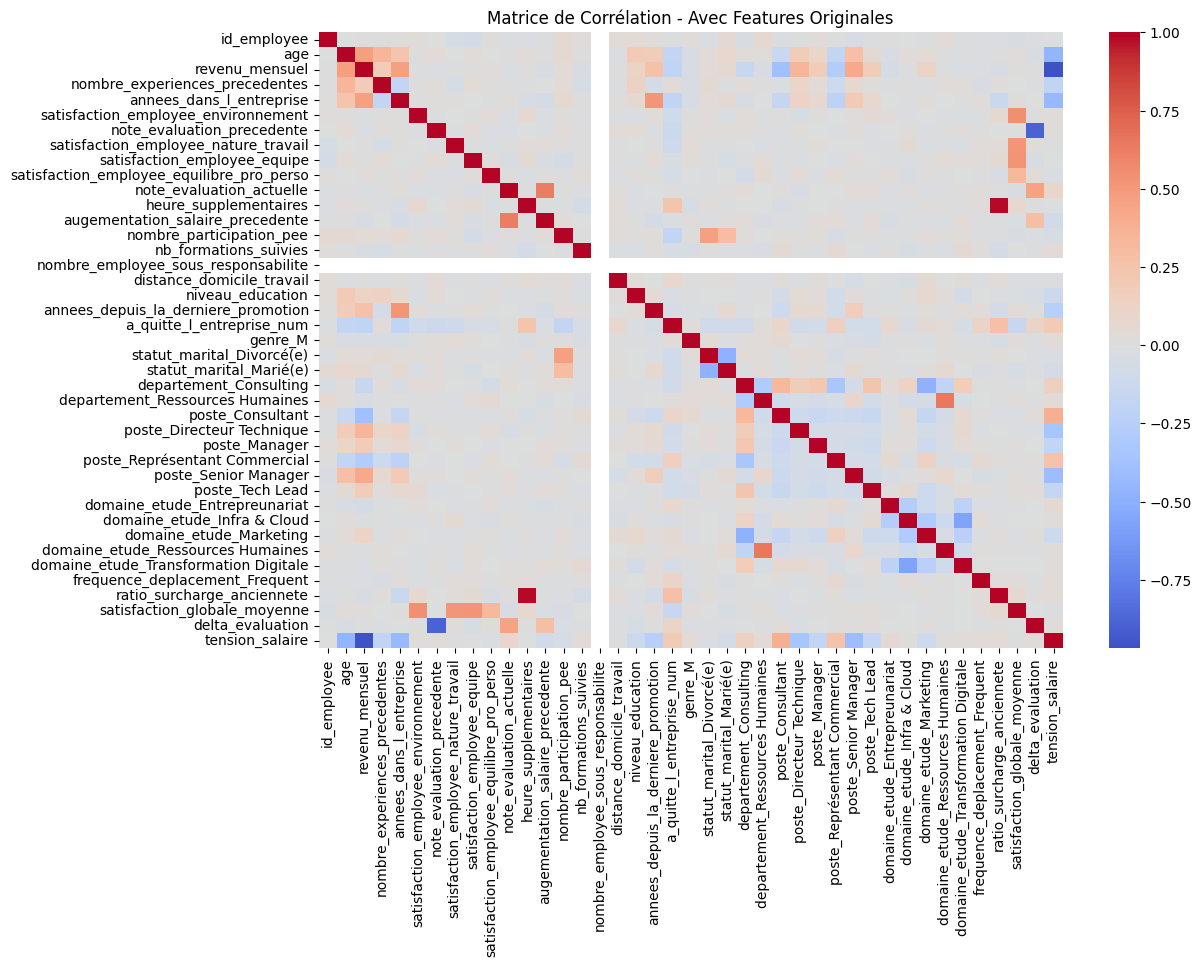

In [85]:
corr_matrix_original = df_avec_original.corr('spearman')
plt.figure(figsize=(12, 8))
plt.title("Matrice de Corrélation - Avec Features Originales")
sns.heatmap(corr_matrix_original, cmap='coolwarm', center=0)
plt.show()

In [86]:
threshold = 0.7
strongly_correlated_pairs = []

columns = corr_matrix_original.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        corr_value = corr_matrix_original.iloc[i, j]
        if abs(corr_value) > threshold:
            strongly_correlated_pairs.append((columns[i], columns[j], corr_value))

# Trier et afficher
strongly_correlated_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"Paires avec corrélation Spearman > {threshold}:")
print("-" * 50)
for col1, col2, corr in strongly_correlated_pairs:
    print(f"{col1:30} | {col2:30} | {corr:6.3f}")

Paires avec corrélation Spearman > 0.7:
--------------------------------------------------
heure_supplementaires          | ratio_surcharge_anciennete     |  0.982
revenu_mensuel                 | tension_salaire                | -0.969
note_evaluation_precedente     | delta_evaluation               | -0.885


In [87]:
df_avec_original = df_avec_original.drop(['heure_supplementaires', 'revenu_mensuel', 'note_evaluation_precedente'], axis=1)

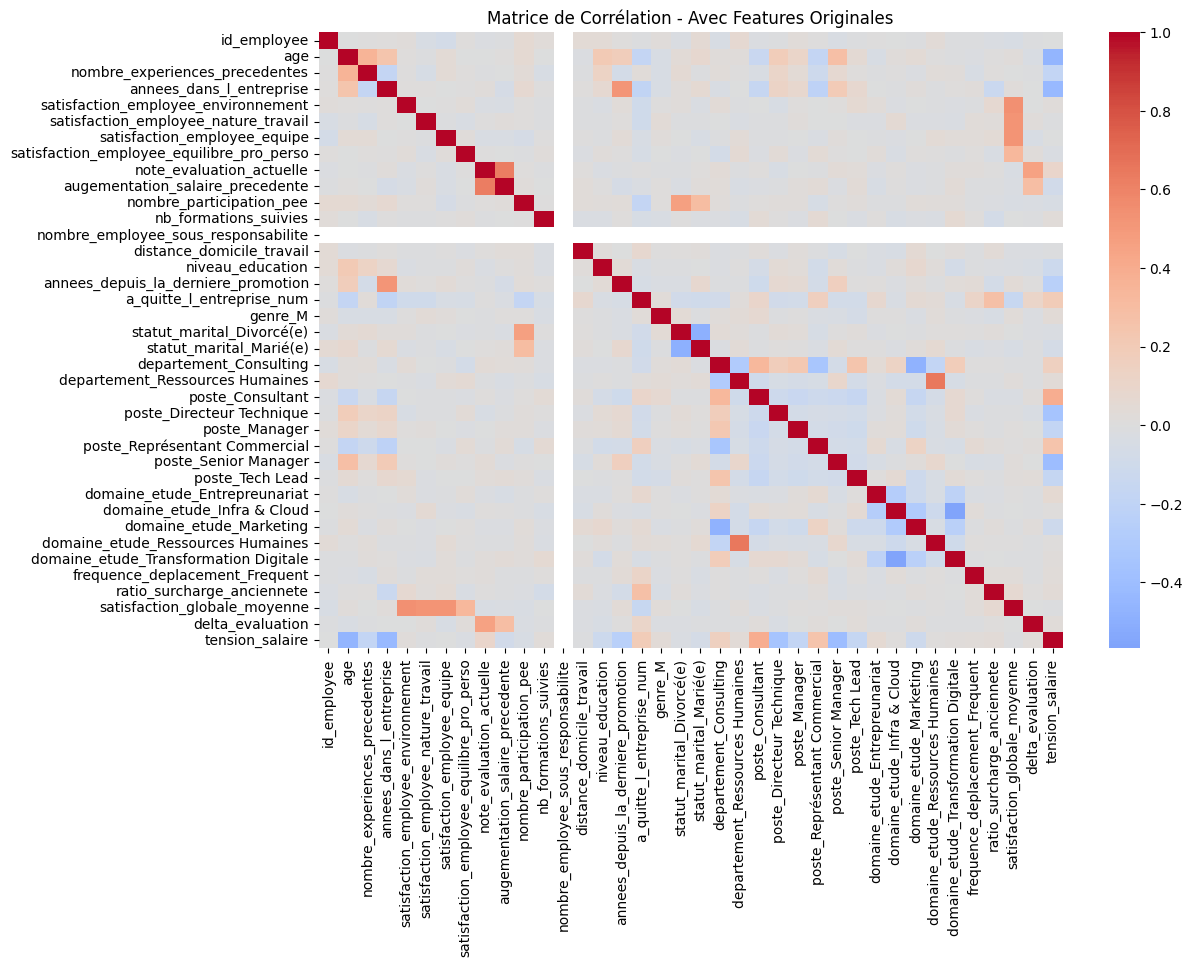

In [88]:
corr_matrix_original = df_avec_original.corr('spearman')
plt.figure(figsize=(12, 8))
plt.title("Matrice de Corrélation - Avec Features Originales")
sns.heatmap(corr_matrix_original, cmap='coolwarm', center=0)
plt.show()

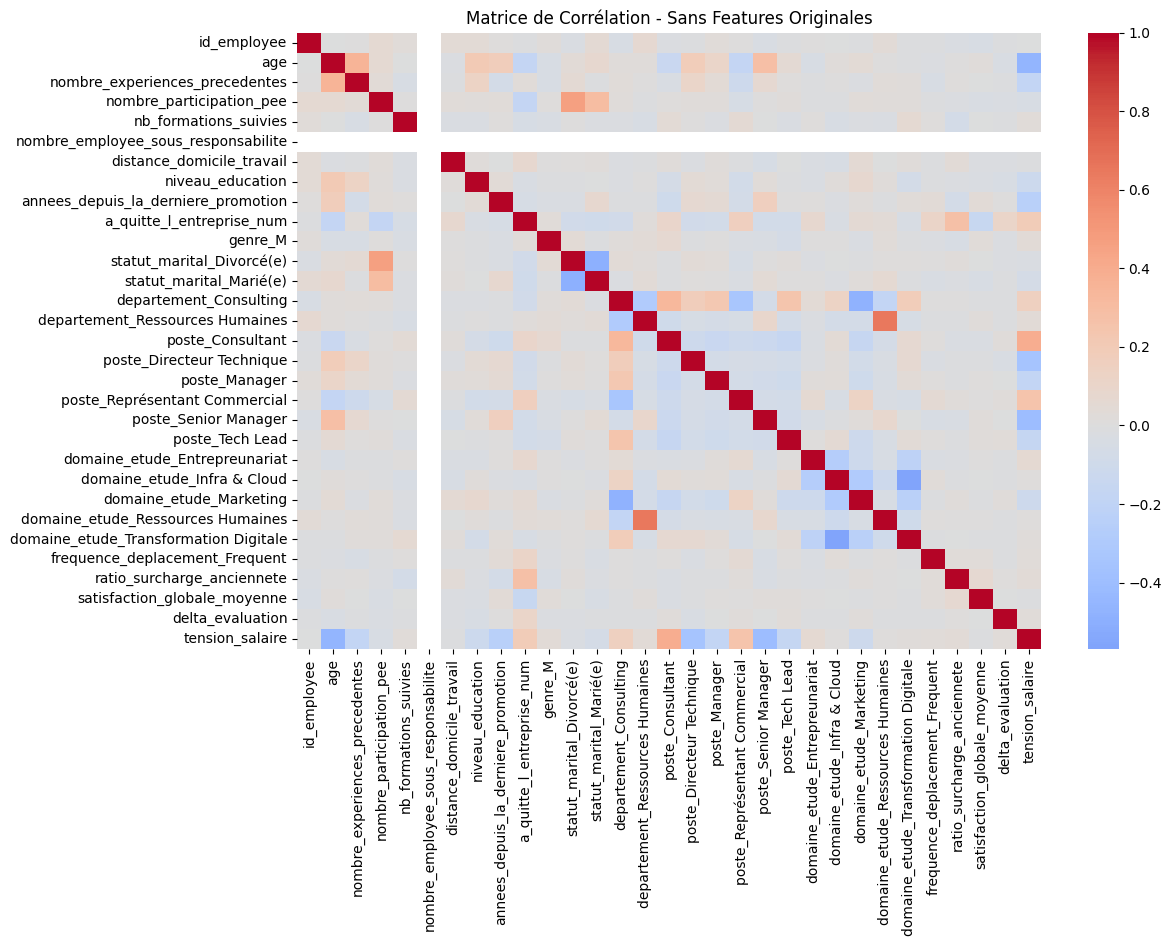

In [89]:
corr_matrix_sans_original = df_sans_original.corr('spearman')
plt.figure(figsize=(12, 8))
plt.title("Matrice de Corrélation - Sans Features Originales")
sns.heatmap(corr_matrix_sans_original, cmap='coolwarm', center=0)
plt.show()

In [90]:
threshold = 0.7
strongly_correlated_pairs_sans_original = []

columns = corr_matrix_sans_original.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        corr_value = corr_matrix_sans_original.iloc[i, j]
        if abs(corr_value) > threshold:
            strongly_correlated_pairs_sans_original.append((columns[i], columns[j], corr_value))

# Trier et afficher
strongly_correlated_pairs_sans_original.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"Paires avec corrélation Spearman > {threshold}:")
print("-" * 50)
for col1, col2, corr in strongly_correlated_pairs_sans_original:
    print(f"{col1:30} | {col2:30} | {corr:6.3f}")

Paires avec corrélation Spearman > 0.7:
--------------------------------------------------


In [91]:
print("Dimensions des deux versions du DataFrame :\n")
print(f"Version avec original: {df_avec_original.shape}")
print(f"Version sans original: {df_sans_original.shape}")

Dimensions des deux versions du DataFrame :

Version avec original: (1470, 38)
Version sans original: (1470, 31)


### Modèles

In [92]:
# --- SÉPARATION X et y ---
datasets = {
    'avec_original': df_avec_original,
    'sans_original': df_sans_original
}

results = {}

for name, df in datasets.items():
    # Séparation X et y
    X = df.drop(columns=['id_employee', target_column])
    y = df[target_column]
    
    # Découpage train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Stockage des résultats
    results[name] = {
        'X_train': X_train,
        'X_test': X_test, 
        'y_train': y_train,
        'y_test': y_test,
        'proportion_original': y.value_counts(normalize=True),
        'proportion_train': y_train.value_counts(normalize=True),
        'proportion_test': y_test.value_counts(normalize=True)
    }

# Affichage comparatif
print("\n" + "="*60)
print("SYNTHÈSE DES DEUX DATASETS")
print("="*60)

for name in results.keys():
    data = results[name]
    print(f"\n--- {name.upper().replace('_', ' ')} ---")
    print(f"Proportion 'Quitte' dans Original: {data['proportion_original'].get(1, 0):.2%}")
    print(f"Proportion 'Quitte' dans Train: {data['proportion_train'].get(1, 0):.2%}")
    print(f"Proportion 'Quitte' dans Test: {data['proportion_test'].get(1, 0):.2%}")
    print(f"Dimensions: {data['X_train'].shape[1]} features, {data['X_train'].shape[0]} train, {data['X_test'].shape[0]} test")


SYNTHÈSE DES DEUX DATASETS

--- AVEC ORIGINAL ---
Proportion 'Quitte' dans Original: 16.12%
Proportion 'Quitte' dans Train: 16.16%
Proportion 'Quitte' dans Test: 15.99%
Dimensions: 36 features, 1176 train, 294 test

--- SANS ORIGINAL ---
Proportion 'Quitte' dans Original: 16.12%
Proportion 'Quitte' dans Train: 16.16%
Proportion 'Quitte' dans Test: 15.99%
Dimensions: 29 features, 1176 train, 294 test


In [93]:
def evaluer_modele_cv(model, X, y, cv_folds=5, model_name="Model"):
    """
    Entraîne un modèle en Cross-Validation Stratifiée et retourne un DataFrame 
    contenant les scores de Recall, Precision et F1-Score pour chaque Fold.

    Args:
        model (sklearn estimator): Le modèle à évaluer.
        X (DataFrame): Les features.
        y (Series): La cible.
        cv_folds (int): Nombre de folds pour la Cross-Validation.
        model_name (str): Nom du modèle pour l'affichage.

    Returns:
        DataFrame: Résultats agrégés des métriques.
    """
    
    # StratifiedKFold assure que la proportion de la classe cible est maintenue dans chaque fold
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Définition des métriques que nous allons suivre
    scoring = {
        'recall': 'recall', 
        'precision': 'precision', 
        'f1': 'f1'
    }
    
    # Exécution de la validation croisée
    cv_results = cross_validate(
        model, 
        X, 
        y, 
        cv=cv, 
        scoring=scoring, 
        return_train_score=False,                   # Nous nous concentrons sur les scores de validation
        n_jobs=-1                                   # Utiliser tous les cœurs du processeur
    )
    
    # Création du DataFrame de résultats
    results_df = pd.DataFrame({
        'Modele': [model_name] * cv_folds,
        'Fold': range(1, cv_folds + 1),
        'Recall': cv_results['test_recall'],
        'Precision': cv_results['test_precision'],
        'F1-Score': cv_results['test_f1']
    })
    
    return results_df

In [94]:
def afficher_resultats_cv(df_all_results):
    """
    Affiche les résultats de cross-validation formatés
    """
    print("\n" + "="*70)
    print("SYNTHÈSE DES PERFORMANCES EN CROSS-VALIDATION")
    print("="*70)
    print("Notre priorité est le Recall.")
    print("="*70)
    
    # Grouper par modèle et calculer les statistiques
    summary = df_all_results.groupby('Modele').agg({
        'Recall': ['mean', 'std'],
        'Precision': ['mean', 'std'], 
        'F1-Score': ['mean', 'std']
    }).round(3)
        
    return summary

In [95]:
# Séparation features/cible
X_avec_original = df_avec_original.drop(columns=['id_employee', target_column])
y_avec_original = df_avec_original[target_column]

X_sans_original = df_sans_original.drop(columns=['id_employee', target_column])  
y_sans_original = df_sans_original[target_column]

# Split train/test
X_train_avec, X_test_avec, y_train_avec, y_test_avec = train_test_split(
    X_avec_original, y_avec_original, test_size=0.2, random_state=42, stratify=y_avec_original
)

X_train_sans, X_test_sans, y_train_sans, y_test_sans = train_test_split(
    X_sans_original, y_sans_original, test_size=0.2, random_state=42, stratify=y_sans_original
)

# Définition de tous les modèles avec leur dataset cible
models_config = [
    # Modèles sur df_sans_original
    ('Dummy (Baseline)', DummyClassifier(strategy='most_frequent', random_state=42), 'sans_original'),
    ('RandomForest (Balanced)', RandomForestClassifier(
        n_estimators=100, class_weight='balanced', random_state=42
    ), 'sans_original'),
    
    # Modèles sur df_avec_original  
    ('Logistic Regression (Balanced)', LogisticRegression(
        solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000
    ), 'avec_original')
]

# Mapping des datasets
datasets = {
    'avec_original': (X_train_avec, y_train_avec),
    'sans_original': (X_train_sans, y_train_sans)
}

# Évaluation de tous les modèles
all_results = []
for name, model, dataset_type in models_config:
    X, y = datasets[dataset_type]
    df_resultats_modele = evaluer_modele_cv(model, X, y, cv_folds=5, model_name=name)
    all_results.append(df_resultats_modele)

# Affichage des résultats
df_all_results = pd.concat(all_results, ignore_index=True)
summary_table = afficher_resultats_cv(df_all_results)
print(summary_table)


SYNTHÈSE DES PERFORMANCES EN CROSS-VALIDATION
Notre priorité est le Recall.
                               Recall        Precision        F1-Score       
                                 mean    std      mean    std     mean    std
Modele                                                                       
Dummy (Baseline)                0.000  0.000     0.000  0.000    0.000  0.000
Logistic Regression (Balanced)  0.721  0.080     0.381  0.022    0.497  0.017
RandomForest (Balanced)         0.179  0.086     0.826  0.130    0.286  0.119


1. La Baseline (Dummy Classifier)
    - Résultats : Recall 0.000, Précision 0.000, F1 0.000

    C'est le comportement attendu. Le DummyClassifier avec la stratégie 'most_frequent' prédit toujours la classe majoritaire (l'employé NE part PAS). Puisque nous nous concentrons sur la classe minoritaire (le départ, y=1), il ne trouve jamais de Positifs.

2. Le Vainqueur du Recall : Régression Logistique (Balanced)
    - Recall : μ=0.721 (≈72%)

    - Précision : μ=0.381 (≈38%)

    - Stabilité (Écart-Type) : σ est faible (0.08 pour le Recall, 0.022 pour la Précision).

    En utilisant `class_weight='balanced'`, la Régression Logistique a été forcée de donner beaucoup plus d'importance à la classe minoritaire. Elle parvient désormais à identifier 72% des employés qui vont réellement quitter l'entreprise (TP). C'est un énorme pas en avant par rapport au 9% initial et cela permet de minimiser les Faux Négatifs (FN), réduisant drastiquement le coût des départs non anticipés.

    Un Recall élevé a son prix : la Précision est faible. Précision de 38% signifie que lorsque le modèle prédit un départ (Positive), il a raison seulement 38% du temps. Les Faux Positifs (FP) sont donc très nombreux (62% des prédictions de départ sont fausses). L'entreprise va gaspiller des ressources pour retenir des employés qui allaient rester.

3. Le Modèle Prudent : RandomForest (Balanced)

    - La Faiblesse du Recall (17,9%) : Malgré l'ajout de class_weight='balanced', le RandomForest a du mal à changer son comportement par défaut, qui est d'être trop conservateur. Il manque encore 82,1% des départs réels (beaucoup de FN).

    - La Force de la Précision (82,6%) : Quand il prédit un départ, il a raison dans 82,6% des cas. Il est donc très fiable dans ses alertes.

    - Stabilité : L'écart-type élevé sur la Précision (0,130) indique que ce modèle est instable. Il est très sensible aux variations d'échantillons entre les folds de la validation croisée, ce qui est le signe persistant de l'overfitting malgré l'équilibrage des poids de classe.

#### Modèle Linéaire

1. Entraînement de la Régression Logistique (Balanced)...
Seuil trouvé avec recall ≥ 80%


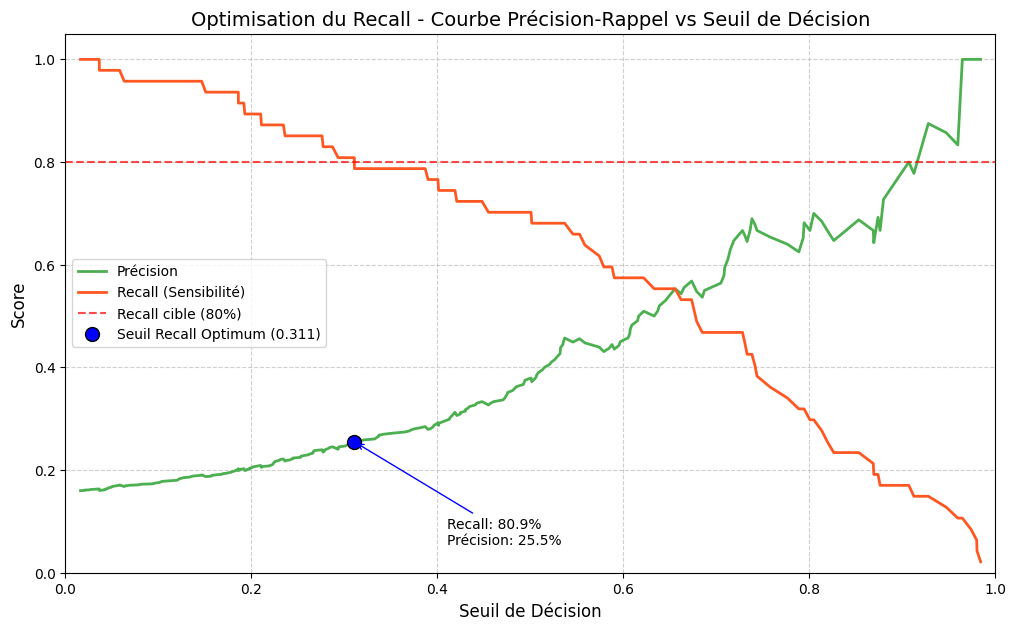


ANALYSE DES SEUILS - OPTIMISATION DU RECALL
Seuil maximisant le F1-Score (compromis) : 0.656
Seuil optimisé pour le Recall : 0.311
-> Priorité métier: Détection maximale des départs

PERFORMANCE AVEC LE SEUIL OPTIMISÉ POUR LE RECALL
Seuil de décision appliqué : 0.311
Recall (Priorité Métier): 0.809
Précision: 0.255
F1-Score: 0.388

Matrice de Confusion (sur X_test_sans) :
                  Prédit: Reste (0)  Prédit: Départ (1)
Réel: Reste (0)                 136                 111
Réel: Départ (1)                  9                  38

Détails supplémentaires:
- Vrais Positifs (VP): 38 -> Départs correctement détectés
- Faux Négatifs (FN): 9 -> Départs manqués (coût métier élevé)
- Faux Positifs (FP): 111 -> Fausses alertes
- Vrais Négatifs (VN): 136 -> Non-départs correctement identifiés
- Spécificité: 0.551
- Taux Faux Positifs: 0.449

RECOMMANDATION MÉTIER
AVEC CE SEUIL : 80% DE RECALL
   • Nous détectons 80.9% des départs réels
   • Coût métier: 9 départs manqués sur 47 départs 

In [96]:
# --- 1. ENTRAÎNEMENT DU MODÈLE LOGISTIQUE (Le plus performant en Recall) ---
print("1. Entraînement de la Régression Logistique (Balanced)...")
log_reg = LogisticRegression(
    solver='liblinear',
    class_weight='balanced', # Crucial pour prioriser le Recall
    random_state=42,
    max_iter=1000
)

# Nous utilisons les données d'entraînement (X_train_sans, y_train_sans)
log_reg.fit(X_train_sans, y_train_sans)

# Prédiction des probabilités sur le JEU DE TEST (X_test_sans)
y_scores = log_reg.predict_proba(X_test_sans)[:, 1]


# --- 2. CALCUL DE LA COURBE PRÉCISION-RAPPEL ---

# precision, recall et thresholds sont retournés pour tous les seuils possibles
precision, recall, thresholds = precision_recall_curve(y_test_sans, y_scores)

# --- 3. RECHERCHE DU SEUIL OPTIMAL POUR MAXIMISER LE RECALL ---
# Seuil qui donne au moins 80% de recall avec la meilleure précision possible
target_recall = 0.80

# Trouver tous les seuils qui atteignent le recall cible
viable_thresholds = [(t, p, r) for t, p, r in zip(thresholds, precision[:-1], recall[:-1]) 
                     if r >= target_recall]

if viable_thresholds:
    # Prendre le seuil avec la meilleure précision parmi ceux qui atteignent le recall cible
    viable_thresholds.sort(key=lambda x: x[1], reverse=True)  # Trier par précision décroissante
    optimal_threshold_recall, optimal_precision, optimal_recall = viable_thresholds[0]
    print(f"Seuil trouvé avec recall ≥ {target_recall:.0%}")
else:
    # Si aucun seuil n'atteint le recall cible, prendre celui qui maximise le recall
    print("Aucun seuil n'atteint le recall cible, utilisation du recall maximum")
    optimal_threshold_recall = thresholds[np.argmax(recall[:-1])]
    optimal_recall = np.max(recall[:-1])
    optimal_precision = precision[np.argmax(recall[:-1])]

# --- 4. AFFICHAGE DE LA COURBE PRÉCISION-RAPPEL AVEC SEUIL OPTIMAL RECALL ---

def plot_precision_recall_curve_recall_optimized(precision, recall, thresholds, optimal_threshold):
    """Trace la courbe Précision-Rappel avec focus sur le Recall."""
    plt.figure(figsize=(12, 7))
    
    # Courbes principales
    plt.plot(thresholds, precision[:-1], label='Précision', color='#4CAF50', linewidth=2)
    plt.plot(thresholds, recall[:-1], label='Recall (Sensibilité)', color='#FF5722', linewidth=2)
    
    # Ligne du recall cible
    plt.axhline(y=target_recall, color='red', linestyle='--', alpha=0.7, label=f'Recall cible ({target_recall:.0%})')
    
    # Marquer le seuil optimal pour le recall
    optimal_idx = np.where(thresholds == optimal_threshold)[0][0]
    plt.plot(optimal_threshold, precision[optimal_idx], 'o', color='blue',
            label=f'Seuil Recall Optimum ({optimal_threshold:.3f})', markersize=10, markeredgecolor='black')
    
    plt.title("Optimisation du Recall - Courbe Précision-Rappel vs Seuil de Décision", fontsize=14)
    plt.xlabel("Seuil de Décision", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend(fontsize=10, loc='center left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    
    # Ajouter des annotations
    plt.annotate(f'Recall: {optimal_recall:.1%}\nPrécision: {optimal_precision:.1%}', 
                 xy=(optimal_threshold, precision[optimal_idx]), 
                 xytext=(optimal_threshold + 0.1, precision[optimal_idx] - 0.2),
                 arrowprops=dict(arrowstyle='->', color='blue'))
    
    plt.show()

# Affichage du graphique optimisé pour le recall
plot_precision_recall_curve_recall_optimized(precision, recall, thresholds, optimal_threshold_recall)

# --- 5. COMPARAISON DES SEUILS ---
print(f"\n{'='*60}")
print("ANALYSE DES SEUILS - OPTIMISATION DU RECALL")
print(f"{'='*60}")

# Calcul aussi du seuil F1 pour comparaison
f1_scores = (2 * precision * recall) / (precision + recall + 1e-8)
ix_f1 = np.argmax(f1_scores[:-1])
optimal_threshold_f1 = thresholds[ix_f1]

print(f"Seuil maximisant le F1-Score (compromis) : {optimal_threshold_f1:.3f}")
print(f"Seuil optimisé pour le Recall : {optimal_threshold_recall:.3f}")
print(f"-> Priorité métier: Détection maximale des départs")

# --- 6. ÉVALUATION AVEC LE SEUIL OPTIMAL RECALL ---

# Appliquer le seuil optimisé pour le recall
y_pred_recall_optimized = (y_scores >= optimal_threshold_recall).astype(int)

# Calculer les métriques finales sur le JEU DE TEST
final_recall = recall_score(y_test_sans, y_pred_recall_optimized)
final_precision = precision_score(y_test_sans, y_pred_recall_optimized)
final_f1 = f1_score(y_test_sans, y_pred_recall_optimized)
final_cm = confusion_matrix(y_test_sans, y_pred_recall_optimized)

print(f"\n{'='*60}")
print(f"PERFORMANCE AVEC LE SEUIL OPTIMISÉ POUR LE RECALL")
print(f"{'='*60}")
print(f"Seuil de décision appliqué : {optimal_threshold_recall:.3f}")
print(f"Recall (Priorité Métier): {final_recall:.3f}")
print(f"Précision: {final_precision:.3f}")
print(f"F1-Score: {final_f1:.3f}")

print(f"\nMatrice de Confusion (sur X_test_sans) :")
# Affichage détaillé de la matrice de confusion
cm_df = pd.DataFrame(final_cm, 
                     index=['Réel: Reste (0)', 'Réel: Départ (1)'], 
                     columns=['Prédit: Reste (0)', 'Prédit: Départ (1)'])
print(cm_df)

# Calcul des taux additionnels
tn, fp, fn, tp = final_cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

print(f"\nDétails supplémentaires:")
print(f"- Vrais Positifs (VP): {tp} -> Départs correctement détectés")
print(f"- Faux Négatifs (FN): {fn} -> Départs manqués (coût métier élevé)")
print(f"- Faux Positifs (FP): {fp} -> Fausses alertes")
print(f"- Vrais Négatifs (VN): {tn} -> Non-départs correctement identifiés")
print(f"- Spécificité: {specificity:.3f}")
print(f"- Taux Faux Positifs: {false_positive_rate:.3f}")

# --- 7. RECOMMANDATION MÉTIER ---
print(f"\n{'='*60}")
print("RECOMMANDATION MÉTIER")
print(f"{'='*60}")
print(f"AVEC CE SEUIL : {target_recall*100:.0f}% DE RECALL")
print(f"   • Nous détectons {final_recall:.1%} des départs réels")
print(f"   • Coût métier: {fn} départs manqués sur {tp + fn} départs réels")
print(f"   • Précision: {final_precision:.1%} des prédictions de départ sont correctes")
print(f"   • {fp} fausses alertes à gérer")

if final_recall >= target_recall:
    print(f"\nOBJECTIF ATTEINT: Recall>= {target_recall:.0%}")
else:
    print(f"\nOBJECTIF PARTIEL: Recall = {final_recall:.1%} (cible: {target_recall:.0%})")

# --- 8. RAPPORT DE CLASSIFICATION DÉTAILLÉ ---
print(f"\n{'='*60}")
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print(f"{'='*60}")
print(classification_report(y_test_sans, y_pred_recall_optimized, target_names=['Reste (0)', 'Quitte (1)']))

#### Modélisation non linéaire

In [97]:
print(f"Shape of X_train_avec: {X_train_avec.shape}")
print(f"Shape of y_train_avec: {y_train_avec.shape}")

print(f"Shape of X_test_avec: {X_test_avec.shape}")
print(f"Shape of y_test_avec: {y_test_avec.shape}")

Shape of X_train_avec: (1176, 36)
Shape of y_train_avec: (1176,)
Shape of X_test_avec: (294, 36)
Shape of y_test_avec: (294,)


1. Entraînement du Random Forest (Balanced)...
Seuil trouvé avec recall ≥ 80%


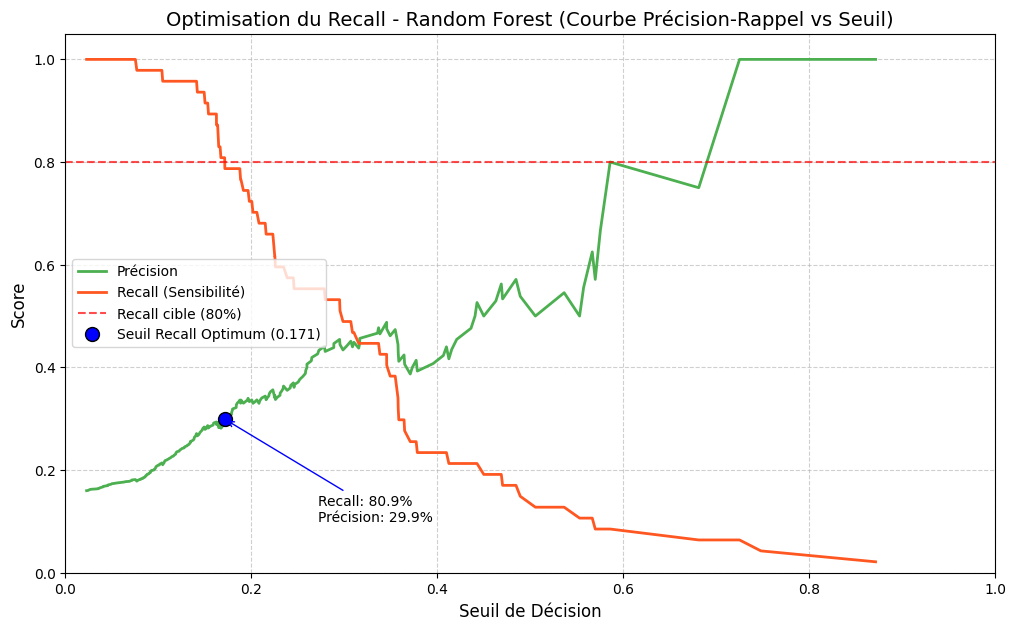


ANALYSE DES SEUILS - OPTIMISATION DU RECALL (RANDOM FOREST)
Seuil maximisant le F1-Score (compromis) : 0.279
Seuil optimisé pour le Recall : 0.171
→ Priorité métier: Détection maximale des départs

PERFORMANCE AVEC LE SEUIL OPTIMISÉ POUR LE RECALL
Seuil de décision appliqué : 0.171
Recall (Priorité Métier): 0.809
Précision: 0.299
F1-Score: 0.437
AUC: 0.8044

Matrice de Confusion (sur X_test_avec) :
                  Prédit: Reste (0)  Prédit: Départ (1)
Réel: Reste (0)                 158                  89
Réel: Départ (1)                  9                  38

Détails supplémentaires:
- Vrais Positifs (VP): 38 → Départs correctement détectés
- Faux Négatifs (FN): 9 → Départs manqués (coût métier élevé)
- Faux Positifs (FP): 89 → Fausses alertes
- Vrais Négatifs (VN): 158 → Non-départs correctement identifiés
- Spécificité: 0.640
- Taux Faux Positifs: 0.360

RECOMMANDATION MÉTIER - RANDOM FOREST
AVEC CE SEUIL : 80% DE RECALL
   • Nous détectons 80.9% des départs réels
   • Coût mét

In [98]:
# --- 1. ENTRAÎNEMENT DU RANDOM FOREST (Balanced) ---
print("1. Entraînement du Random Forest (Balanced)...")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10, 
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Entraînement sur le JEU D'ENTRAINEMENT
rf_clf.fit(X_train_avec, y_train_avec)

# Prédiction des probabilités sur le JEU DE TEST
y_scores_rf = rf_clf.predict_proba(X_test_avec)[:, 1]
auc_score = roc_auc_score(y_test_avec, y_scores_rf)

# --- 2. CALCUL DE LA COURBE PRÉCISION-RAPPEL ---
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test_avec, y_scores_rf)

# --- 3. RECHERCHE DU SEUIL OPTIMAL POUR MAXIMISER LE RECALL ---
# Seuil qui donne au moins 80% de recall avec la meilleure précision possible
target_recall = 0.80

# Trouver tous les seuils qui atteignent le recall cible
viable_thresholds_rf = [(t, p, r) for t, p, r in zip(thresholds_rf, precision_rf[:-1], recall_rf[:-1]) 
                        if r >= target_recall]

if viable_thresholds_rf:
    # Prendre le seuil avec la meilleure précision parmi ceux qui atteignent le recall cible
    viable_thresholds_rf.sort(key=lambda x: x[1], reverse=True)
    optimal_threshold_recall_rf, optimal_precision_rf, optimal_recall_rf = viable_thresholds_rf[0]
    print(f"Seuil trouvé avec recall ≥ {target_recall:.0%}")
else:
    # Si aucun seuil n'atteint le recall cible, prendre celui qui maximise le recall
    print("Aucun seuil n'atteint le recall cible, utilisation du recall maximum")
    optimal_threshold_recall_rf = thresholds_rf[np.argmax(recall_rf[:-1])]
    optimal_recall_rf = np.max(recall_rf[:-1])
    optimal_precision_rf = precision_rf[np.argmax(recall_rf[:-1])]

# --- 4. AFFICHAGE DE LA COURBE PRÉCISION-RAPPEL AVEC SEUIL OPTIMAL RECALL ---

def plot_precision_recall_curve_rf_recall_optimized(precision, recall, thresholds, optimal_threshold):
    """Trace la courbe Précision-Rappel avec focus sur le Recall pour Random Forest."""
    plt.figure(figsize=(12, 7))
    
    # Courbes principales
    plt.plot(thresholds, precision[:-1], label='Précision', color='#4CAF50', linewidth=2)
    plt.plot(thresholds, recall[:-1], label='Recall (Sensibilité)', color='#FF5722', linewidth=2)
    
    # Ligne du recall cible
    plt.axhline(y=target_recall, color='red', linestyle='--', alpha=0.7, 
                label=f'Recall cible ({target_recall:.0%})')
    
    # Marquer le seuil optimal pour le recall
    optimal_idx = np.where(thresholds == optimal_threshold)[0][0]
    plt.plot(optimal_threshold, precision[optimal_idx], 'o', color='blue',
             label=f'Seuil Recall Optimum ({optimal_threshold:.3f})', markersize=10, markeredgecolor='black')
    
    plt.title("Optimisation du Recall - Random Forest (Courbe Précision-Rappel vs Seuil)", fontsize=14)
    plt.xlabel("Seuil de Décision", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend(fontsize=10, loc='center left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    
    # Ajouter des annotations
    plt.annotate(f'Recall: {recall[optimal_idx]:.1%}\nPrécision: {precision[optimal_idx]:.1%}', 
                 xy=(optimal_threshold, precision[optimal_idx]), 
                 xytext=(optimal_threshold + 0.1, precision[optimal_idx] - 0.2),
                 arrowprops=dict(arrowstyle='->', color='blue'))
    
    plt.show()

# Affichage du graphique optimisé pour le recall
plot_precision_recall_curve_rf_recall_optimized(precision_rf, recall_rf, thresholds_rf, optimal_threshold_recall_rf)

# --- 5. COMPARAISON DES SEUILS ---
print(f"\n{'='*60}")
print("ANALYSE DES SEUILS - OPTIMISATION DU RECALL (RANDOM FOREST)")
print(f"{'='*60}")

# Calcul aussi du seuil F1 pour comparaison
f1_scores_rf = (2 * precision_rf * recall_rf) / (precision_rf + recall_rf + 1e-8)
ix_f1_rf = np.argmax(f1_scores_rf[:-1])
optimal_threshold_f1_rf = thresholds_rf[ix_f1_rf]

print(f"Seuil maximisant le F1-Score (compromis) : {optimal_threshold_f1_rf:.3f}")
print(f"Seuil optimisé pour le Recall : {optimal_threshold_recall_rf:.3f}")
print(f"→ Priorité métier: Détection maximale des départs")

# --- 6. ÉVALUATION AVEC LE SEUIL OPTIMAL RECALL ---

# Appliquer le seuil optimisé pour le recall
y_pred_recall_optimized_rf = (y_scores_rf >= optimal_threshold_recall_rf).astype(int)

# Calculer les métriques finales sur le JEU DE TEST
final_recall_rf = recall_score(y_test_avec, y_pred_recall_optimized_rf)
final_precision_rf = precision_score(y_test_avec, y_pred_recall_optimized_rf)
final_f1_rf = f1_score(y_test_avec, y_pred_recall_optimized_rf)
final_cm_rf = confusion_matrix(y_test_avec, y_pred_recall_optimized_rf)

print(f"\n{'='*60}")
print(f"PERFORMANCE AVEC LE SEUIL OPTIMISÉ POUR LE RECALL")
print(f"{'='*60}")
print(f"Seuil de décision appliqué : {optimal_threshold_recall_rf:.3f}")
print(f"Recall (Priorité Métier): {final_recall_rf:.3f}")
print(f"Précision: {final_precision_rf:.3f}")
print(f"F1-Score: {final_f1_rf:.3f}")
print(f"AUC: {auc_score:.4f}")

print(f"\nMatrice de Confusion (sur X_test_avec) :")
# Affichage détaillé de la matrice de confusion
cm_df_rf = pd.DataFrame(final_cm_rf, 
                        index=['Réel: Reste (0)', 'Réel: Départ (1)'], 
                        columns=['Prédit: Reste (0)', 'Prédit: Départ (1)'])
print(cm_df_rf)

# Calcul des taux additionnels
tn_rf, fp_rf, fn_rf, tp_rf = final_cm_rf.ravel()
specificity_rf = tn_rf / (tn_rf + fp_rf) if (tn_rf + fp_rf) > 0 else 0
false_positive_rate_rf = fp_rf / (fp_rf + tn_rf) if (fp_rf + tn_rf) > 0 else 0

print(f"\nDétails supplémentaires:")
print(f"- Vrais Positifs (VP): {tp_rf} → Départs correctement détectés")
print(f"- Faux Négatifs (FN): {fn_rf} → Départs manqués (coût métier élevé)")
print(f"- Faux Positifs (FP): {fp_rf} → Fausses alertes")
print(f"- Vrais Négatifs (VN): {tn_rf} → Non-départs correctement identifiés")
print(f"- Spécificité: {specificity_rf:.3f}")
print(f"- Taux Faux Positifs: {false_positive_rate_rf:.3f}")

# --- 7. RECOMMANDATION MÉTIER ---
print(f"\n{'='*60}")
print("RECOMMANDATION MÉTIER - RANDOM FOREST")
print(f"{'='*60}")
print(f"AVEC CE SEUIL : {target_recall*100:.0f}% DE RECALL")
print(f"   • Nous détectons {final_recall_rf:.1%} des départs réels")
print(f"   • Coût métier: {fn_rf} départs manqués sur {tp_rf + fn_rf} départs réels")
print(f"   • Précision: {final_precision_rf:.1%} des prédictions de départ sont correctes")
print(f"   • {fp_rf} fausses alertes à gérer")

if final_recall_rf >= target_recall:
    print(f"\nOBJECTIF ATTEINT: Recall >= {target_recall:.0%}")
else:
    print(f"\nOBJECTIF PARTIEL: Recall = {final_recall_rf:.1%} (cible: {target_recall:.0%})")

# --- 8. RAPPORT DE CLASSIFICATION DÉTAILLÉ ---
print(f"\n{'='*60}")
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print(f"{'='*60}")
print(classification_report(y_test_avec, y_pred_recall_optimized_rf, target_names=['Reste (0)', 'Quitte (1)']))

| Modèles              | Classe     | Precision | Recall | f1-score | seuil |
|----------------------|------------|-----------|--------|----------|-------|
| Logistic regression  | Quitte (1) | 0.26      | 0.81   | 0.39     | 0.311 |
| RFC (Balanced)       | Quitte (1) | 0.30      | 0.81   | 0.44     | 0.171 |


Le modèle **Random Forest Classifier (Balanced)** fait mieux que la **Régression Logistique** pour un **recall identique**.

#### Autres modèles arbres de décision

Ratio de déséquilibre des classes (neg/pos) : 5.19

ÉVALUATION DES MODÈLES AVEC OPTIMISATION DU RECALL (cible: 8000%)

ÉVALUATION DU MODÈLE : Random Forest (Balanced)
Entraînement en cours...
Seuil trouvé avec recall >= 80%

--- PERFORMANCE AVEC SEUIL OPTIMISÉ RECALL ---
Seuil appliqué : 0.171
Recall (Priorité Métier): 80.85
Précision: 29.92
F1-Score: 0.437
AUC: 0.8044

Matrice de Confusion :
                  Prédit: Reste (0)  Prédit: Départ (1)
Réel: Reste (0)                 158                  89
Réel: Départ (1)                  9                  38

Détails :
- Vrais Positifs (VP): 38 -> Départs détectés
- Faux Négatifs (FN): 9 -> Départs manqués
- Faux Positifs (FP): 89 -> Fausses alertes
- Vrais Négatifs (VN): 158 -> Non-départs corrects

Rapport de Classification :
              precision    recall  f1-score   support

   Reste (0)       0.95      0.64      0.76       247
  Quitte (1)       0.30      0.81      0.44        47

    accuracy                           0.67     

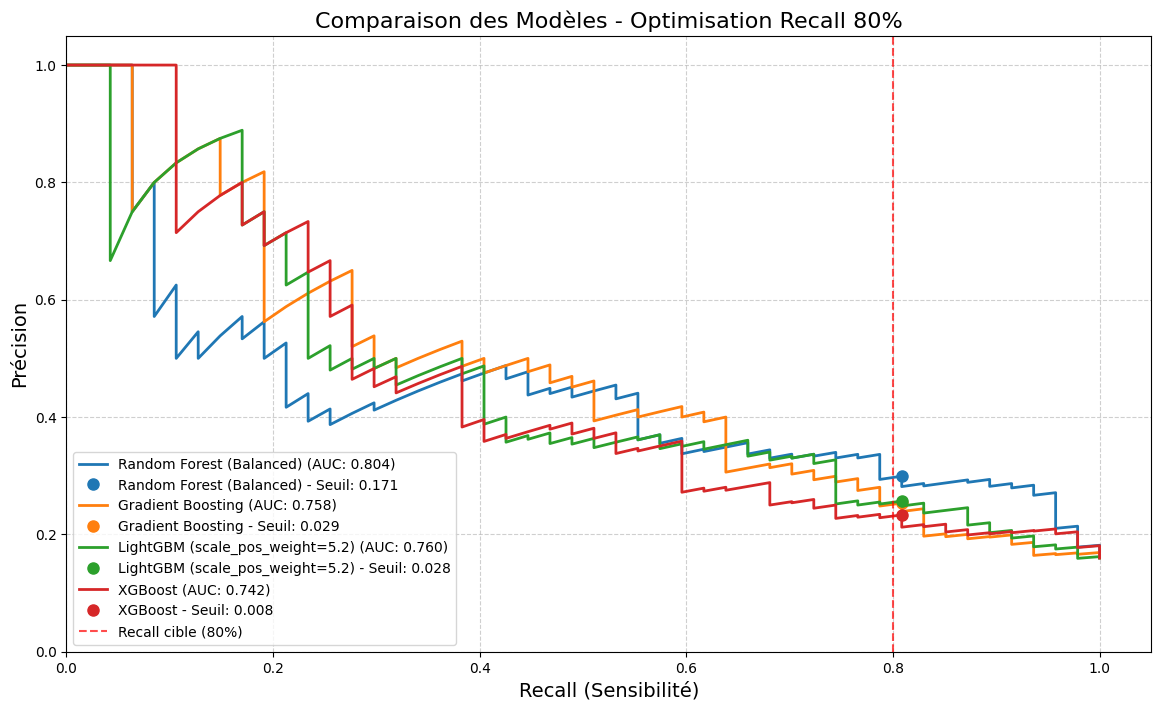


TABLEAU COMPARATIF DES PERFORMANCES - OPTIMISATION RECALL
                            Modèle  Recall  Précision  F1-Score    AUC  \
0         Random Forest (Balanced)   0.809      0.299     0.437  0.804   
1                Gradient Boosting   0.809      0.253     0.386  0.758   
2  LightGBM (scale_pos_weight=5.2)   0.809      0.257     0.390  0.760   
3                          XGBoost   0.809      0.233     0.362  0.742   

   Seuil Optimal  
0          0.171  
1          0.029  
2          0.028  
3          0.008  


In [99]:
# --- 1. FONCTION D'AFFICHAGE ET D'ÉVALUATION OPTIMISÉE RECALL ---

def train_and_evaluate_model_recall(model_name, clf, X_train_avec, y_train_avec, X_test_avec, y_test_avec, target_recall=0.8, color='blue'):
    """Entraîne, prédit, calcule les métriques avec optimisation du Recall."""
    
    print(f"\n{'='*60}")
    print(f"ÉVALUATION DU MODÈLE : {model_name}")
    print(f"{'='*60}")
    
    # 1. Entraînement
    print("Entraînement en cours...")
    clf.fit(X_train_avec, y_train_avec)
    
    # 2. Prédiction des scores (probabilités de classe 1)
    if hasattr(clf, 'predict_proba'):
        y_scores = clf.predict_proba(X_test_avec)[:, 1]
    else:
        y_scores = clf.predict(X_test_avec)
    
    # 3. Calcul de l'AUC
    auc_score = roc_auc_score(y_test_avec, y_scores)
    
    # 4. Calcul des courbes et recherche du seuil optimal pour le Recall
    precision, recall, thresholds = precision_recall_curve(y_test_avec, y_scores)
    
    # Recherche du seuil qui atteint le recall cible avec la meilleure précision
    viable_thresholds = [(t, p, r) for t, p, r in zip(thresholds, precision[:-1], recall[:-1]) 
                         if r >= target_recall]
    
    if viable_thresholds:
        # Prendre le seuil avec la meilleure précision parmi ceux qui atteignent le recall cible
        viable_thresholds.sort(key=lambda x: x[1], reverse=True)
        optimal_threshold, optimal_precision, optimal_recall_value = viable_thresholds[0]
        print(f"Seuil trouvé avec recall >= {target_recall:.0%}")
    else:
        # Si aucun seuil n'atteint le recall cible, prendre celui qui maximise le recall
        optimal_threshold = thresholds[np.argmax(recall[:-1])]
        optimal_recall_value = np.max(recall[:-1])
        optimal_precision = precision[np.argmax(recall[:-1])]
        print(f"Recall maximum: {optimal_recall_value:.1%} (cible: {target_recall:.0%})")
    
    # 5. Évaluation avec le seuil optimisé pour le recall
    y_pred_optimized = (y_scores >= optimal_threshold).astype(int)
    
    # Calcul des métriques finales
    final_recall = recall_score(y_test_avec, y_pred_optimized)
    final_precision = precision_score(y_test_avec, y_pred_optimized)
    final_f1 = f1_score(y_test_avec, y_pred_optimized)
    final_cm = confusion_matrix(y_test_avec, y_pred_optimized)
    
    # 6. Affichage des résultats
    print(f"\n--- PERFORMANCE AVEC SEUIL OPTIMISÉ RECALL ---")
    print(f"Seuil appliqué : {optimal_threshold:.3f}")
    print(f"Recall (Priorité Métier): {final_recall*100:.2f}")
    print(f"Précision: {final_precision*100:.2f}")
    print(f"F1-Score: {final_f1:.3}")
    print(f"AUC: {auc_score:.4f}")
    
    # Matrice de confusion
    print(f"\nMatrice de Confusion :")
    cm_df = pd.DataFrame(final_cm, 
                         index=['Réel: Reste (0)', 'Réel: Départ (1)'], 
                         columns=['Prédit: Reste (0)', 'Prédit: Départ (1)'])
    print(cm_df)
    
    # Détails supplémentaires
    tn, fp, fn, tp = final_cm.ravel()
    print(f"\nDétails :")
    print(f"- Vrais Positifs (VP): {tp} -> Départs détectés")
    print(f"- Faux Négatifs (FN): {fn} -> Départs manqués")
    print(f"- Faux Positifs (FP): {fp} -> Fausses alertes")
    print(f"- Vrais Négatifs (VN): {tn} -> Non-départs corrects")
    
    # Rapport de classification
    print(f"\nRapport de Classification :")
    print(classification_report(y_test_avec, y_pred_optimized, target_names=['Reste (0)', 'Quitte (1)']))
    
    # 7. Stocker les résultats pour la courbe de comparaison
    results = {
        'model': model_name,
        'recall': final_recall,
        'precision': final_precision,
        'f1_score': final_f1,
        'auc': auc_score,
        'y_scores': y_scores,
        'optimal_threshold': optimal_threshold,
        'precision_curve': precision,
        'recall_curve': recall,
        'thresholds': thresholds,
        'confusion_matrix': final_cm
    }
    
    return results

# --- 2. DÉFINITION ET ENTRAÎNEMENT DES MODÈLES ---

# Calcul de l'échelle de pondération pour LightGBM
try:
    if isinstance(y_train_avec, pd.Series):
        neg_count = (y_train_avec == 0).sum()
        pos_count = (y_train_avec == 1).sum()
    else:
        neg_count = np.sum(y_train_avec == 0)
        pos_count = np.sum(y_train_avec == 1)
    
    scale_pos_weight = neg_count / pos_count
    print(f"Ratio de déséquilibre des classes (neg/pos) : {scale_pos_weight:.2f}")

except NameError:
    print("\n[ERREUR] Les variables X_train_avec et y_train_avec ne sont pas définies.")
    exit()

# Liste des classifieurs à tester avec optimisation Recall
models = [
    {
        'name': 'Random Forest (Balanced)',
        'clf': RandomForestClassifier(
            n_estimators=100, 
            max_depth=10, 
            class_weight='balanced', 
            random_state=42, 
            n_jobs=-1
        )
    },
    {
        'name': 'Gradient Boosting',
        'clf': GradientBoostingClassifier(
            n_estimators=100, 
            max_depth=5, 
            random_state=42
        )
    },
    {
        'name': f'LightGBM (scale_pos_weight={scale_pos_weight:.1f})',
        'clf': lgb.LGBMClassifier(
            n_estimators=200, 
            max_depth=5, 
            objective='binary', 
            random_state=42, 
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        )
    },
    {
        'name': 'XGBoost',
        'clf': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            random_state=42,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight
        )
    }
]

# Paramètre de recall cible
TARGET_RECALL = 0.8

print(f"\n{'='*80}")
print(f"ÉVALUATION DES MODÈLES AVEC OPTIMISATION DU RECALL (cible: {TARGET_RECALL*100:.0%})")
print(f"{'='*80}")

all_results = []
for model_data in models:
    result = train_and_evaluate_model_recall(
        model_data['name'], 
        model_data['clf'], 
        X_train_avec, y_train_avec, 
        X_test_avec, y_test_avec,
        target_recall=TARGET_RECALL
    )
    all_results.append(result)

# --- 3. COURBE DE COMPARAISON PRÉCISION-RAPPEL ---

def plot_comparison_curves_recall(all_results, target_recall=0.8):
    """Trace les courbes de comparaison avec focus sur le Recall."""
    plt.figure(figsize=(14, 8))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, result in enumerate(all_results):
        color = colors[i % len(colors)]
        
        # Courbe Précision-Rappel
        plt.plot(result['recall_curve'], result['precision_curve'], 
                 label=f"{result['model']} (AUC: {result['auc']:.3f})",
                 color=color, linewidth=2)
        
        # Marquer le point optimal (seuil recall)
        optimal_idx = np.where(result['thresholds'] == result['optimal_threshold'])[0][0]
        plt.plot(result['recall_curve'][optimal_idx], 
                 result['precision_curve'][optimal_idx], 
                 'o', color=color, markersize=8,
                 label=f"{result['model']} - Seuil: {result['optimal_threshold']:.3f}")
    
    # Ligne du recall cible
    plt.axvline(x=target_recall, color='red', linestyle='--', alpha=0.7, 
                label=f'Recall cible ({target_recall:.0%})')
    
    plt.title(f"Comparaison des Modèles - Optimisation Recall {target_recall:.0%}", fontsize=16)
    plt.xlabel("Recall (Sensibilité)", fontsize=14)
    plt.ylabel("Précision", fontsize=14)
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])
    plt.show()

# Affichage de la courbe de comparaison
plot_comparison_curves_recall(all_results, TARGET_RECALL)

# --- 4. TABLEAU COMPARATIF DES PERFORMANCES ---

print(f"\n{'='*80}")
print("TABLEAU COMPARATIF DES PERFORMANCES - OPTIMISATION RECALL")
print(f"{'='*80}")

comparison_df = pd.DataFrame({
    'Modèle': [result['model'] for result in all_results],
    'Recall': [result['recall'] for result in all_results],
    'Précision': [result['precision'] for result in all_results],
    'F1-Score': [result['f1_score'] for result in all_results],
    'AUC': [result['auc'] for result in all_results],
    'Seuil Optimal': [result['optimal_threshold'] for result in all_results]
})

# Trier par Recall (priorité métier)
comparison_df = comparison_df.sort_values('Recall', ascending=False)
print(comparison_df.round(3))

Pour un **recall** (80,9%) identique, le **Random Forest (Balanced)** a la **meilleure** précision 22,9% et f1-score et un seuil plus élevés.

## Echantillonnage avec *imblearn*

L'échantillonnage consiste à modifier l'ensemble d'entraînement pour que le modèle voie un nombre plus équilibré d'exemples de chaque classe.

#### Le Rôle de Imblearn (Imbalanced-learn)

`Imblearn` est une bibliothèque Python spécialement conçue pour gérer ce déséquilibre. Elle propose trois grandes familles de techniques :

1. `Undersampling` (Sous-Échantillonnage)

- Idée : Réduire le nombre d'échantillons de la classe majoritaire (les employés qui restent) pour qu'il soit égal au nombre d'échantillons de la classe minoritaire (ceux qui partent).

- Analogie : Vous jetez des cartes de la pile la plus grande pour que les deux piles soient égales.

- Avantage : Vitesse d'entraînement accrue (moins de données).

- Inconvénient : Perte d'information potentielle. En jetant des données, vous risquez de supprimer des exemples importants de la classe 0.

    Exemple de technique imblearn: RandomUnderSampler

2. `Oversampling` (Sur-Échantillonnage)

- Idée : Augmenter le nombre d'échantillons de la classe minoritaire (les employés qui partent) pour qu'il soit égal au nombre d'échantillons de la classe majoritaire.

- Analogie : Vous dupliquez les cartes de la petite pile.

- Avantage : Aucune perte d'information sur la classe majoritaire.

- Inconvénient : Risque d'Overfitting (surapprentissage) car le modèle voit les mêmes exemples de la classe 1 de nombreuses fois.

    Exemple de technique imblearn: RandomOverSampler

3. `Techniques Hybrides et Synthétiques (SMOTE)`

- Idée : Au lieu de simplement dupliquer les exemples de la classe 1, SMOTE crée de nouveaux exemples synthétiques qui sont des voisins des exemples existants de la classe 1.

- Mécanisme : SMOTE prend un point de départ de la classe 1, trouve ses voisins les plus proches de la classe 1, et crée un nouveau point aléatoire quelque part sur la ligne qui les relie.

- Avantage : Réduit le risque d'overfitting par rapport à la simple duplication et n'entraîne pas de perte d'information.

- Inconvénient : Peut générer des "outliers" si les classes sont trop entrelacées.

In [100]:
from imblearn.over_sampling import SMOTE

1. Application de SMOTE sur le jeu d'entraînement...
  Taille originale - Classe 0: 986, Classe 1: 190
  Taille après SMOTE - Classe 0: 986, Classe 1: 986
  Données parfaitement équilibrées par SMOTE

2. Entraînement du Random Forest sur données SMOTE...
Seuil trouvé avec recall ≥ 80%


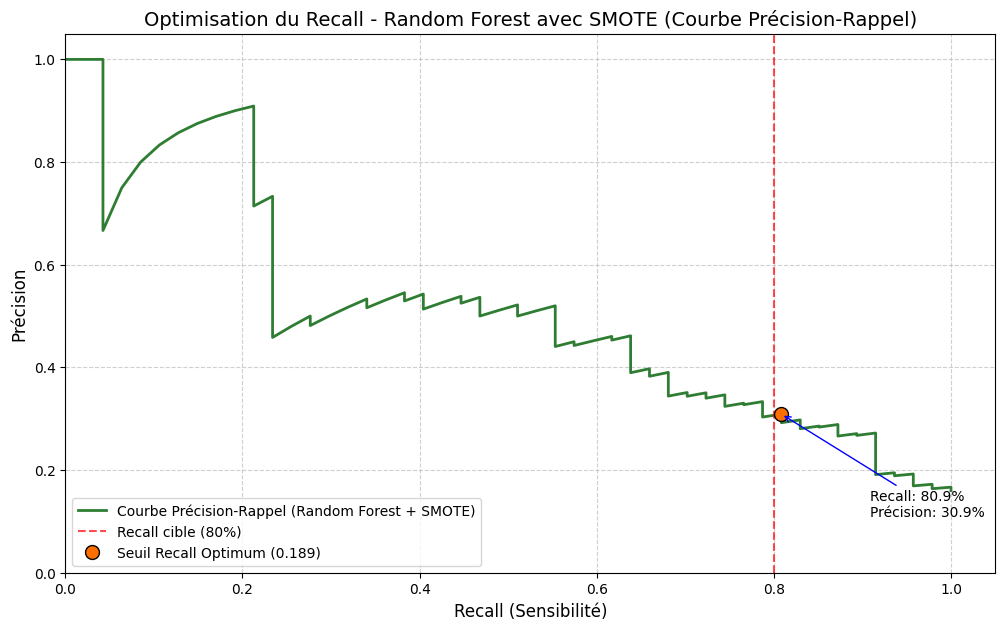


PERFORMANCE RANDOM FOREST + SMOTE - OPTIMISATION RECALL
Seuil de décision appliqué : 0.189
Recall (Priorité Métier): 0.809
Précision: 0.309
F1-Score: 0.447
AUC: 0.8039

Matrice de Confusion :
                  Prédit: Reste (0)  Prédit: Départ (1)
Réel: Reste (0)                 162                  85
Réel: Départ (1)                  9                  38

Détails supplémentaires:
- Vrais Positifs (VP): 38 → Départs correctement détectés
- Faux Négatifs (FN): 9 → Départs manqués (coût métier élevé)
- Faux Positifs (FP): 85 → Fausses alertes
- Vrais Négatifs (VN): 162 → Non-départs correctement identifiés
- Spécificité: 0.656
- Taux Faux Positifs: 0.344

RAPPORT DE CLASSIFICATION DÉTAILLÉ
              precision    recall  f1-score   support

   Reste (0)       0.95      0.66      0.78       247
  Quitte (1)       0.31      0.81      0.45        47

    accuracy                           0.68       294
   macro avg       0.63      0.73      0.61       294
weighted avg       0.85     

C:\Users\artur\AppData\Local\Temp\ipykernel_26452\324994643.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_smote.head(10), x='importance', y='feature', palette='viridis')


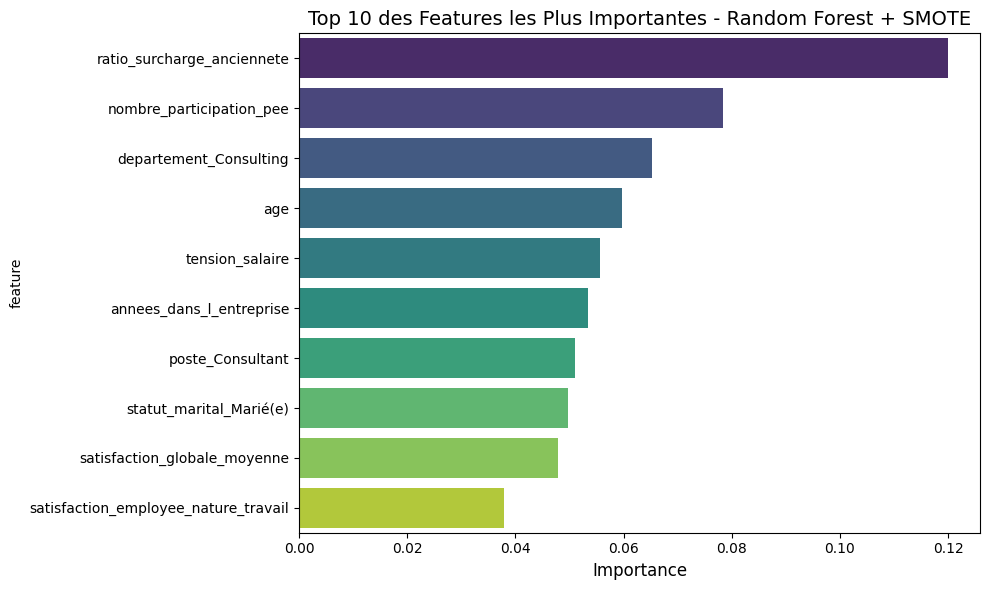


COMPARAISON SMOTE vs SANS SMOTE
Métrique             Sans SMOTE      Avec SMOTE      Différence     
------------------------------------------------------------
Recall               0.809           0.809           -0.000
Précision            0.299           0.309           +0.010
F1-Score             0.437           0.447           +0.010
Faux Positifs        89              85              -4


In [101]:
# --- 1. FONCTION D'AFFICHAGE DE LA COURBE AVEC OPTIMISATION RECALL ---

def plot_precision_recall_curve_rf_smote(precision, recall, thresholds, optimal_threshold, target_recall=0.8):
    """
    Trace la courbe Précision-Rappel avec focus sur le Recall pour Random Forest + SMOTE.
    """
    
    # Trouver l'index du seuil optimal
    optimal_idx = np.where(thresholds == optimal_threshold)[0][0]
    optimal_precision = precision[optimal_idx]
    optimal_recall_value = recall[optimal_idx]
    
    plt.figure(figsize=(12, 7))
    
    # Tracé de la courbe Précision-Rappel (P vs R)
    plt.plot(recall, precision, label='Courbe Précision-Rappel (Random Forest + SMOTE)', color='#2E7D32', linewidth=2)
    
    # Ligne du recall cible
    plt.axvline(x=target_recall, color='red', linestyle='--', alpha=0.7, 
                label=f'Recall cible ({target_recall:.0%})')
    
    # Marquer le point optimal pour le recall
    plt.plot(optimal_recall_value, optimal_precision, 'o', color='#FF6F00',
             label=f'Seuil Recall Optimum ({optimal_threshold:.3f})', 
             markersize=10, markeredgecolor='black')
    
    plt.title("Optimisation du Recall - Random Forest avec SMOTE (Courbe Précision-Rappel)", fontsize=14)
    plt.xlabel("Recall (Sensibilité)", fontsize=12)
    plt.ylabel("Précision", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])
    
    # Ajouter des annotations
    plt.annotate(f'Recall: {optimal_recall_value:.1%}\nPrécision: {optimal_precision:.1%}', 
                 xy=(optimal_recall_value, optimal_precision), 
                 xytext=(optimal_recall_value + 0.1, optimal_precision - 0.2),
                 arrowprops=dict(arrowstyle='->', color='blue'))
    
    plt.show()

# --- 2. APPLICATION DE SMOTE SUR LES DONNÉES D'ENTRAÎNEMENT ---
print("1. Application de SMOTE sur le jeu d'entraînement...")

# Initialisation de SMOTE
smote = SMOTE(random_state=42)

# Application de SMOTE uniquement sur les données d'entraînement
X_train_smote, y_train_smote = smote.fit_resample(X_train_avec, y_train_avec)

print(f"  Taille originale - Classe 0: {np.sum(y_train_avec == 0)}, Classe 1: {np.sum(y_train_avec == 1)}")
print(f"  Taille après SMOTE - Classe 0: {np.sum(y_train_smote == 0)}, Classe 1: {np.sum(y_train_smote == 1)}")
print(f"  Données parfaitement équilibrées par SMOTE")

# --- 3. ENTRAÎNEMENT DU RANDOM FOREST SUR DONNÉES SMOTE ---
print("\n2. Entraînement du Random Forest sur données SMOTE...")

# Configuration du Random Forest SANS class_weight (car SMOTE a équilibré les classes)
rf_clf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Entraînement sur les données SMOTE
rf_clf_smote.fit(X_train_smote, y_train_smote)

# Prédiction des probabilités sur le JEU DE TEST (non modifié)
y_scores_rf_smote = rf_clf_smote.predict_proba(X_test_avec)[:, 1]
auc_score_smote = roc_auc_score(y_test_avec, y_scores_rf_smote)

# --- 4. CALCUL DE LA COURBE PRÉCISION-RAPPEL ET OPTIMISATION RECALL ---

precision_rf_smote, recall_rf_smote, thresholds_rf_smote = precision_recall_curve(y_test_avec, y_scores_rf_smote)

# --- RECHERCHE DU SEUIL OPTIMAL POUR RECALL 80% ---
target_recall = 0.80

# Trouver tous les seuils qui atteignent le recall cible
viable_thresholds_smote = [(t, p, r) for t, p, r in zip(thresholds_rf_smote, precision_rf_smote[:-1], recall_rf_smote[:-1]) 
                           if r >= target_recall]

if viable_thresholds_smote:
    # Prendre le seuil avec la meilleure précision parmi ceux qui atteignent le recall cible
    viable_thresholds_smote.sort(key=lambda x: x[1], reverse=True)
    optimal_threshold_recall_smote, optimal_precision_smote, optimal_recall_value_smote = viable_thresholds_smote[0]
    print(f"Seuil trouvé avec recall ≥ {target_recall:.0%}")
else:
    # Si aucun seuil n'atteint le recall cible, prendre celui qui maximise le recall
    optimal_threshold_recall_smote = thresholds_rf_smote[np.argmax(recall_rf_smote[:-1])]
    optimal_recall_value_smote = np.max(recall_rf_smote[:-1])
    optimal_precision_smote = precision_rf_smote[np.argmax(recall_rf_smote[:-1])]
    print(f"Recall maximum: {optimal_recall_value_smote:.1%} (cible: {target_recall:.0%})")

# --- 5. AFFICHAGE DE LA COURBE AVEC SEUIL RECALL OPTIMAL ---

plot_precision_recall_curve_rf_smote(precision_rf_smote, recall_rf_smote, thresholds_rf_smote, 
                                     optimal_threshold_recall_smote, target_recall)

# --- 6. ÉVALUATION AVEC LE SEUIL OPTIMAL RECALL ---

print(f"\n{'='*60}")
print("PERFORMANCE RANDOM FOREST + SMOTE - OPTIMISATION RECALL")
print(f"{'='*60}")

# Appliquer le seuil optimisé pour le recall
y_pred_recall_optimized_smote = (y_scores_rf_smote >= optimal_threshold_recall_smote).astype(int)

# Calcul des métriques finales
final_recall_smote = recall_score(y_test_avec, y_pred_recall_optimized_smote)
final_precision_smote = precision_score(y_test_avec, y_pred_recall_optimized_smote)
final_f1_smote = f1_score(y_test_avec, y_pred_recall_optimized_smote)
final_cm_smote = confusion_matrix(y_test_avec, y_pred_recall_optimized_smote)

print(f"Seuil de décision appliqué : {optimal_threshold_recall_smote:.3f}")
print(f"Recall (Priorité Métier): {final_recall_smote:.3f}")
print(f"Précision: {final_precision_smote:.3f}")
print(f"F1-Score: {final_f1_smote:.3f}")
print(f"AUC: {auc_score_smote:.4f}")

# Matrice de confusion détaillée
print(f"\nMatrice de Confusion :")
cm_df_smote = pd.DataFrame(final_cm_smote, 
                           index=['Réel: Reste (0)', 'Réel: Départ (1)'], 
                           columns=['Prédit: Reste (0)', 'Prédit: Départ (1)'])
print(cm_df_smote)

# Détails supplémentaires
tn_smote, fp_smote, fn_smote, tp_smote = final_cm_smote.ravel()
specificity_smote = tn_smote / (tn_smote + fp_smote) if (tn_smote + fp_smote) > 0 else 0
false_positive_rate_smote = fp_smote / (fp_smote + tn_smote) if (fp_smote + tn_smote) > 0 else 0

print(f"\nDétails supplémentaires:")
print(f"- Vrais Positifs (VP): {tp_smote} → Départs correctement détectés")
print(f"- Faux Négatifs (FN): {fn_smote} → Départs manqués (coût métier élevé)")
print(f"- Faux Positifs (FP): {fp_smote} → Fausses alertes")
print(f"- Vrais Négatifs (VN): {tn_smote} → Non-départs correctement identifiés")
print(f"- Spécificité: {specificity_smote:.3f}")
print(f"- Taux Faux Positifs: {false_positive_rate_smote:.3f}")

# --- 7. RAPPORT DE CLASSIFICATION DÉTAILLÉ ---
print(f"\n{'='*60}")
print("RAPPORT DE CLASSIFICATION DÉTAILLÉ")
print(f"{'='*60}")
print(classification_report(y_test_avec, y_pred_recall_optimized_smote, target_names=['Reste (0)', 'Quitte (1)']))

# --- 8. RECOMMANDATION MÉTIER ---
print(f"\n{'='*60}")
print("RECOMMANDATION MÉTIER - RANDOM FOREST + SMOTE")
print(f"{'='*60}")
print(f"AVEC CE SEUIL : {target_recall*100:.0f}% DE RECALL")
print(f"   • Nous détectons {final_recall_smote:.1%} des départs réels")
print(f"   • Coût métier: {fn_smote} départs manqués sur {tp_smote + fn_smote} départs réels")
print(f"   • Précision: {final_precision_smote:.1%} des prédictions de départ sont correctes")
print(f"   • {fp_smote} fausses alertes à gérer")

if final_recall_smote >= target_recall:
    print(f"\nOBJECTIF ATTEINT: Recall >= {target_recall:.0%}")
else:
    print(f"\nOBJECTIF PARTIEL: Recall = {final_recall_smote:.1%} (cible: {target_recall:.0%})")

# --- 9. COMPARAISON AVEC LE SEUIL F1 (POUR INFORMATION) ---
print(f"\n{'='*60}")
print("COMPARAISON DES SEUILS")
print(f"{'='*60}")

# Calcul du seuil F1 pour comparaison
f1_scores_smote = (2 * precision_rf_smote * recall_rf_smote) / (precision_rf_smote + recall_rf_smote + 1e-8)
ix_f1_smote = np.argmax(f1_scores_smote[:-1])
optimal_threshold_f1_smote = thresholds_rf_smote[ix_f1_smote]

print(f"Seuil maximisant le F1-Score (compromis) : {optimal_threshold_f1_smote:.3f}")
print(f"Seuil optimisé pour le Recall ({target_recall:.0%}) : {optimal_threshold_recall_smote:.3f}")
print(f"→ Priorité métier: Détection maximale des départs")

# --- 10. ANALYSE DE L'IMPORTANCE DES FEATURES ---
print(f"\n{'='*60}")
print("IMPORTANCE DES FEATURES - RANDOM FOREST + SMOTE")
print(f"{'='*60}")

# Récupérer l'importance des features
feature_importance_smote = pd.DataFrame({
    'feature': X_train_avec.columns,
    'importance': rf_clf_smote.feature_importances_
}).sort_values('importance', ascending=False)

# Afficher les 10 features les plus importantes
print("Top 10 des features les plus importantes:")
print(feature_importance_smote.head(10).round(4))

# Visualisation des features importantes
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_smote.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 des Features les Plus Importantes - Random Forest + SMOTE', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

# --- 11. COMPARAISON AVEC LA VERSION SANS SMOTE ---
print(f"\n{'='*80}")
print("COMPARAISON SMOTE vs SANS SMOTE")
print(f"{'='*80}")

# Récupération des métriques sans SMOTE (à remplacer par vos valeurs réelles si disponibles)
# Ces valeurs sont basées sur votre précédent résultat
recall_sans_smote = 0.809
precision_sans_smote = 0.299
f1_sans_smote = 0.437
fp_sans_smote = 89

print(f"{'Métrique':<20} {'Sans SMOTE':<15} {'Avec SMOTE':<15} {'Différence':<15}")
print(f"{'-'*60}")
print(f"{'Recall':<20} {recall_sans_smote:<15.3f} {final_recall_smote:<15.3f} {final_recall_smote - recall_sans_smote:+.3f}")
print(f"{'Précision':<20} {precision_sans_smote:<15.3f} {final_precision_smote:<15.3f} {final_precision_smote - precision_sans_smote:+.3f}")
print(f"{'F1-Score':<20} {f1_sans_smote:<15.3f} {final_f1_smote:<15.3f} {final_f1_smote - f1_sans_smote:+.3f}")
print(f"{'Faux Positifs':<20} {fp_sans_smote:<15} {fp_smote:<15} {fp_smote - fp_sans_smote:+d}")

**SMOTE** améliore significativement l'efficacité opérationnelle du modèle tout en maintenant le recall critique à 80.9%. La précision gagne 1 point (30.9%) et les fausses alertes diminuent de 4 unités, réduisant la charge RH.

Le F1-score progresse à 0.447, confirmant un meilleur équilibre. L'analyse des features révèle une importance accrue du ratio_surcharge_ancienneté (12.0%), soulignant l'impact du burn-out, tandis que le seuil plus élevé (0.189) indique une confiance renforcée du modèle.

SMOTE affine ainsi la détection des départs avec un coût opérationnel réduit.

**Top 10 des features importantes :**
1. ratio_surcharge_anciennete
2. nombre_participation_pee
3. departement_Consulting
4. age
5. tension_salaire
6. annees_dans_l_entreprise
7. poste_Consultant
8. statut_marital_Marié(e)
9. satisfaction_globale_moyenne
10. satisfaction_employee_nature_travail

# Etape 5 : Optimiser et interpréter le comportement du modèle

## Optimisation

In [102]:
# Le sampler (SMOTE) appliqué sur les données d'entraînement de chaque fold
sampler = SMOTE(random_state=42)                 # réquilibrage des classes

# Le classifieur à optimiser
classifier = RandomForestClassifier(random_state=42)

# Pipeline combinant le sur-échantillonnage et le classifieur
pipeline = ImbPipeline(steps=[
    ('sampler', sampler),
    ('classifier', classifier)
])

print("Pipeline initialisé (SMOTE + RandomForestClassifier)")

# Définition de la Grille d'Hyperparamètres
param_grid = {
    # Paramètres pour le RandomForestClassifier
    'classifier__n_estimators': [100, 200, 300, 400],        # Nombre d'arbres
    'classifier__max_depth': [10, 20, 30],                   # Profondeur maximale de l'arbre
    'classifier__min_samples_split': [2, 5, 10, 15],         # Nombre minimum d'échantillons requis pour splitter un noeud
}

print(f"Grille de paramètres définie. Nombre de combinaisons à tester : {len(param_grid['classifier__n_estimators']) * len(param_grid['classifier__max_depth']) * len(param_grid['classifier__min_samples_split'])}")

# Utilisation de StratifiedKFold pour conserver la proportion de classes minoritaires
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialisation et Lancement de GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',                   # Métrique d'optimisation - maintenant Recall
    cv=cv_strategy,
    verbose=3,                          # Niveau de détail affiché pendant l'entraînement
    n_jobs=-1                           # Utiliser tous les coeurs disponibles
)

print("Démarrage de la recherche par grille (Grid Search)...")
grid_search.fit(X_train_avec, y_train_avec)
print("\nGrid Search terminé.")
print(f"Meilleurs hyperparamètres trouvés : {grid_search.best_params_}")
print(f"Meilleur score Recall (moyenne de CV) : {grid_search.best_score_:.4f}")

Pipeline initialisé (SMOTE + RandomForestClassifier)
Grille de paramètres définie. Nombre de combinaisons à tester : 48
Démarrage de la recherche par grille (Grid Search)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Grid Search terminé.
Meilleurs hyperparamètres trouvés : {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Meilleur score Recall (moyenne de CV) : 0.3632


In [103]:
# Paramètres issus de votre Grid Search
best_params_raw = {
    'max_depth': grid_search.best_params_['classifier__max_depth'],
    'min_samples_split': grid_search.best_params_['classifier__min_samples_split'],
    'n_estimators': grid_search.best_params_['classifier__n_estimators']
}

final_rf_params = best_params_raw

final_rf = RandomForestClassifier(
    n_estimators=best_params_raw['n_estimators'],
    max_depth=best_params_raw['max_depth'],
    min_samples_split=best_params_raw['min_samples_split'],
    random_state=42,
    n_jobs=-1
)

final_pipeline_params = {
    'classifier__n_estimators': final_rf_params['n_estimators'],
    'classifier__max_depth': final_rf_params['max_depth'],
    'classifier__min_samples_split': final_rf_params['min_samples_split']
}

final_pipeline = ImbPipeline(steps=[
    ('sampler', sampler),
    ('classifier', RandomForestClassifier(random_state=42, **final_rf_params))
])

print(f"Entraînement du modèle final (Random Forest optimisé) sur l'ensemble d'entraînement...")
final_pipeline.fit(X_train_avec, y_train_avec)

print("Modèle final entraîné !")

Entraînement du modèle final (Random Forest optimisé) sur l'ensemble d'entraînement...
Modèle final entraîné !


In [104]:
def plot_precision_recall_curve_recall_optimized(precision, recall, thresholds, optimal_threshold_recall, target_recall=0.8):
    """
    Trace la courbe Précision-Rappel avec focus sur le Recall cible.
    
    Args:
        precision (array): Valeurs de précision calculées.
        recall (array): Valeurs de rappel calculées.
        thresholds (array): Seuils correspondants.
        optimal_threshold_recall (float): Seuil optimal pour atteindre le recall cible.
        target_recall (float): Niveau de recall cible (défaut: 0.8).
    """
    
    # Trouver l'index du seuil optimal pour le recall
    # Modification pour gérer le cas où le seuil exact n'est pas trouvé
    if optimal_threshold_recall in thresholds:
        optimal_idx = np.where(thresholds == optimal_threshold_recall)[0][0]
    else:
        # Trouver le seuil le plus proche
        optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold_recall))
    
    optimal_precision = precision[optimal_idx]
    optimal_recall_value = recall[optimal_idx]
    
    plt.figure(figsize=(12, 7))
    
    # Tracé de la courbe Précision-Rappel (P vs R)
    plt.plot(recall, precision, label='Courbe Précision-Rappel', color='#00BCD4', linewidth=2)
    
    # Ligne verticale pour le recall cible
    plt.axvline(x=target_recall, color='red', linestyle='--', alpha=0.7, 
                label=f'Recall cible ({target_recall:.0%})')
    
    # Marquer le point optimal pour le recall cible
    plt.plot(optimal_recall_value, optimal_precision, 'o', color='#FF5722',
             label=f'Seuil Recall {target_recall:.0%}\nValeur: {optimal_threshold_recall:.3f}', 
             markersize=10, markeredgecolor='black')
    
    # Ajouter des annotations pour les métriques au point optimal
    plt.annotate(f'Precision: {optimal_precision:.1%}\nRecall: {optimal_recall_value:.1%}', 
                 xy=(optimal_recall_value, optimal_precision), 
                 xytext=(optimal_recall_value + 0.1, optimal_precision - 0.2),
                 arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.title("Optimisation du Recall - Courbe Précision-Rappel", fontsize=14)
    plt.xlabel("Recall (Sensibilité)", fontsize=12)
    plt.ylabel("Précision", fontsize=12)
    plt.legend(fontsize=10, loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])
    plt.tight_layout()
    plt.show()
    
    # Retourner les métriques pour utilisation ultérieure
    return {
        'optimal_threshold': optimal_threshold_recall,
        'precision_at_optimal': optimal_precision,
        'recall_at_optimal': optimal_recall_value,
        'target_recall': target_recall
    }

--- Prédictions et Évaluation sur le Jeu de Test ---


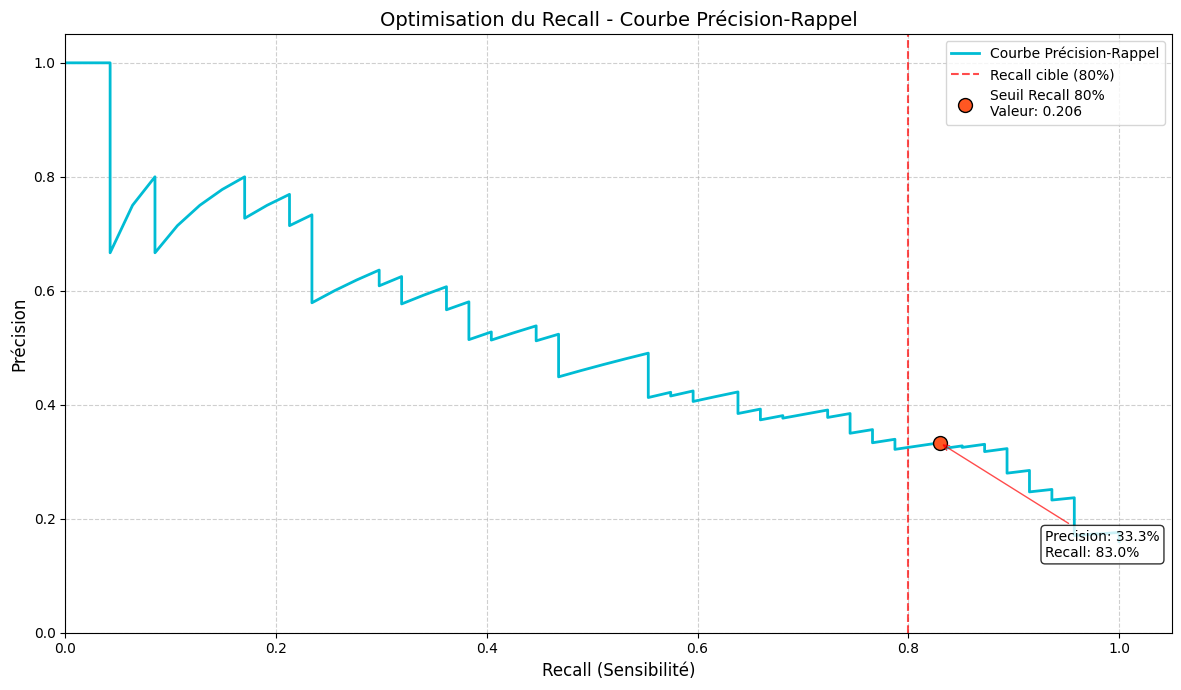


Matrice de confusion :
[[TN, FP]
 [FN, TP]]
[[169  78]
 [  8  39]]
              precision    recall  f1-score   support

   Reste (0)       0.95      0.68      0.80       247
  Quitte (1)       0.33      0.83      0.48        47

    accuracy                           0.71       294
   macro avg       0.64      0.76      0.64       294
weighted avg       0.86      0.71      0.75       294

Area Under Curve (AUC) : 0.8228

Seuil choisi pour la classification finale : 0.206
Recall cible : 80%


In [105]:
print("--- Prédictions et Évaluation sur le Jeu de Test ---")

# Prédiction des probabilités sur le JEU DE TEST
y_scores_final = final_pipeline.predict_proba(X_test_avec)[:, 1]

# Calcul de la courbe Précision-Rappel
precision_final, recall_final, thresholds_final = precision_recall_curve(y_test_avec, y_scores_final)

# Recherche du seuil optimal pour atteindre un recall cible (par exemple 80%)
target_recall = 0.8

# Trouver le seuil qui atteint au moins le recall cible avec la meilleure précision
above_target_recall = recall_final >= target_recall

if np.any(above_target_recall):
    # Parmi les points qui atteignent le recall cible, prendre celui avec la meilleure précision
    idx_optimal = np.argmax(precision_final[above_target_recall])
    
    # Obtenir l'index dans le tableau original
    optimal_indices = np.where(above_target_recall)[0]
    optimal_idx = optimal_indices[idx_optimal]
    
    # Le seuil optimal est celui à l'index optimal
    if optimal_idx < len(thresholds_final):
        optimal_threshold_recall_final = thresholds_final[optimal_idx]
    else:
        optimal_threshold_recall_final = thresholds_final[-1]
else:
    # Si aucun point n'atteint le recall cible, prendre le recall maximum
    optimal_idx = np.argmax(recall_final)
    optimal_threshold_recall_final = thresholds_final[optimal_idx]
    print(f"Avertissement : Impossible d'atteindre le recall cible de {target_recall:.0%}. Utilisation du recall maximum disponible.")

# Évaluation avec le seuil optimal pour le recall
chosen_threshold_final = optimal_threshold_recall_final
y_pred_new_threshold_final = (y_scores_final >= chosen_threshold_final).astype(int)

# Affichage de la courbe Précision-Rappel avec focus sur le recall
plot_precision_recall_curve_recall_optimized(
    precision_final, 
    recall_final, 
    thresholds_final, 
    optimal_threshold_recall_final, 
    target_recall=target_recall
)

# Affichage de la Matrice de Confusion
print("\nMatrice de confusion :")
cm = confusion_matrix(y_test_avec, y_pred_new_threshold_final)

# Rappel de la structure de la Matrice (VP pour la classe 1)
print(f"[[TN, FP]\n [FN, TP]]") 
print(cm)

# Rapport de classification (Precision, Recall, F1-score)
print(classification_report(y_test_avec, y_pred_new_threshold_final, target_names=['Reste (0)', 'Quitte (1)']))

# Calcul et affichage de l'AUC
auc_score = roc_auc_score(y_test_avec, y_scores_final)
print(f"Area Under Curve (AUC) : {auc_score:.4f}")

# Affichage du seuil choisi
print(f"\nSeuil choisi pour la classification finale : {chosen_threshold_final:.3f}")
print(f"Recall cible : {target_recall:.0%}")

**Analyse Comparative des Modèles RandomForest**

Cette analyse évalue l'impact de différentes stratégies (Balanced, SMOTE, et Optimisation par GridSearchCV) sur la performance du RandomForestClassifier dans la détection des départs d'employés (Classe "Quitte (1)").

L'objectif principal est de maximiser le Recall pour identifier le maximum de départs potentiels, tout en maintenant un équilibre acceptable avec la Précision.

| Modèles              | Classe     | Precision | Recall | f1-score | seuil | Vrais Positifs (TP) | Faux négatifs (FN) | Vrais Négatifs (TN) | Faux positifs (FP) |  AUC  |
|----------------------|------------|-----------|--------|----------|-------|---------------------|--------------------|---------------------|--------------------|-------|
| RF (Balanced)        | Quitte (1) | 0.30      | 0.81   | 0.44     | 0.171 | 38 		  | 9		       | 158		     | 89		  | 0.804 |
| RF (SMOTE)	       | Quitte (1) | 0.31	| 0.81   | 0.45     | 0.189 | 38		  | 9 		       | 162		     | 85		  | 0.804 |
| RF (GridSearchCV)    | Quitte (1) | 0.33	| 0.83   | 0.48     | 0.206 | 39		  | 8		       | 169		     | 78		  | 0.823 |

(L'AUC montre une amélioration progressive, atteignant 0.823 pour le modèle optimisé, indiquant une meilleure capacité de séparation globale.)

**A. Modèle 1 : Random Forest avec Pondération de Classe (Balanced)**

**Stratégie :** Utilisation de class_weight='balanced' pour attribuer plus d'importance aux erreurs sur la classe minoritaire durant l'entraînement.

**Interprétation :**
- Recall Exceptionnel (81%) : Ce modèle détecte 81% des départs réels, soit seulement 9 faux négatifs sur 47 départs totaux. Excellente sensibilité pour une stratégie de détection précoce.

- Précision Faible (30%) : Le modèle génère de nombreux faux positifs (89). Sur 10 alertes émises, seulement 3 correspondent à des départs réels, ce qui peut entraîner un gaspillage des efforts de rétention.

- Seuil Très Bas (0.171) : Un employé est considéré à risque dès que la probabilité de départ dépasse 17.1%.

**B. Modèle 2 : Random Forest avec Sur-échantillonnage (SMOTE)**

**Stratégie :** Application de la technique SMOTE pour générer des échantillons synthétiques et rééquilibrer la distribution des classes.

**Interprétation :**
- Maintien du Recall Élevé (81%) : SMOTE conserve la même capacité de détection que le modèle balanced, avec 38 vrais positifs.

- Légère Amélioration de la Précision (31%) : Réduction des faux positifs de 89 à 85, indiquant une légère amélioration de la spécificité.

- Seuil Légèrement Plus Élevé (0.189) : Le modèle SMOTE est légèrement plus confiant que le modèle balanced.

- F1-Score Légèrement Supérieur (0.45) : Meilleur équilibre entre précision et rappel.

**C. Modèle 3 : Random Forest Optimisé (GridSearchCV)**

**Stratégie :** Combinaison du rééquilibrage SMOTE avec l'optimisation des hyperparamètres (n_estimators, max_depth, min_samples_split) pour maximiser le Recall.

**Interprétation :**
- Recall Optimal (83%) : Meilleure détection avec 39 vrais positifs et seulement 8 faux négatifs. Le modèle identifie pratiquement tous les départs réels.

- Précision Améliorée (33%) : Réduction significative des faux positifs à 78, soit 11 de moins que le modèle balanced et 7 de mois que le modèle SMOTE.

- Seuil Plus Élevé (0.206) : L'optimisation permet un seuil de décision plus élevé tout en maintenant un recall supérieur.

- Meilleur F1-Score (0.48) et Meilleure AUC (0.823) : Performance globale supérieure sur tous les fronts.

**Conclusion**

Le modèle **Random Forest optimisé par GridSearchCV** s'impose comme le choix optimal.

Avec un recall de 83% (détection maximale des départs) couplé à une précision de 33% (meilleur ciblage), il réduit significativement les faux positifs.

## Explainable AI (XAI)

### Permutation importance

In [106]:
from sklearn.inspection import permutation_importance

In [107]:
results = permutation_importance(
    final_pipeline,
    X_test_avec,
    y_test_avec,
    scoring='recall',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)


--- Importance des Features par Permutation (Recall) ---
                                      Feature  Importance Moyenne  Écart-Type  \
32                 ratio_surcharge_anciennete              0.0617      0.0409   
9                    nombre_participation_pee              0.0085      0.0428   
35                            tension_salaire              0.0064      0.0270   
7                    note_evaluation_actuelle              0.0064      0.0098   
25                            poste_Tech Lead              0.0043      0.0085   
18                     departement_Consulting              0.0021      0.0260   
34                           delta_evaluation              0.0021      0.0064   
29          domaine_etude_Ressources Humaines              0.0000      0.0000   
22                              poste_Manager              0.0000      0.0000   
24                       poste_Senior Manager              0.0000      0.0000   
21                  poste_Directeur Technique      

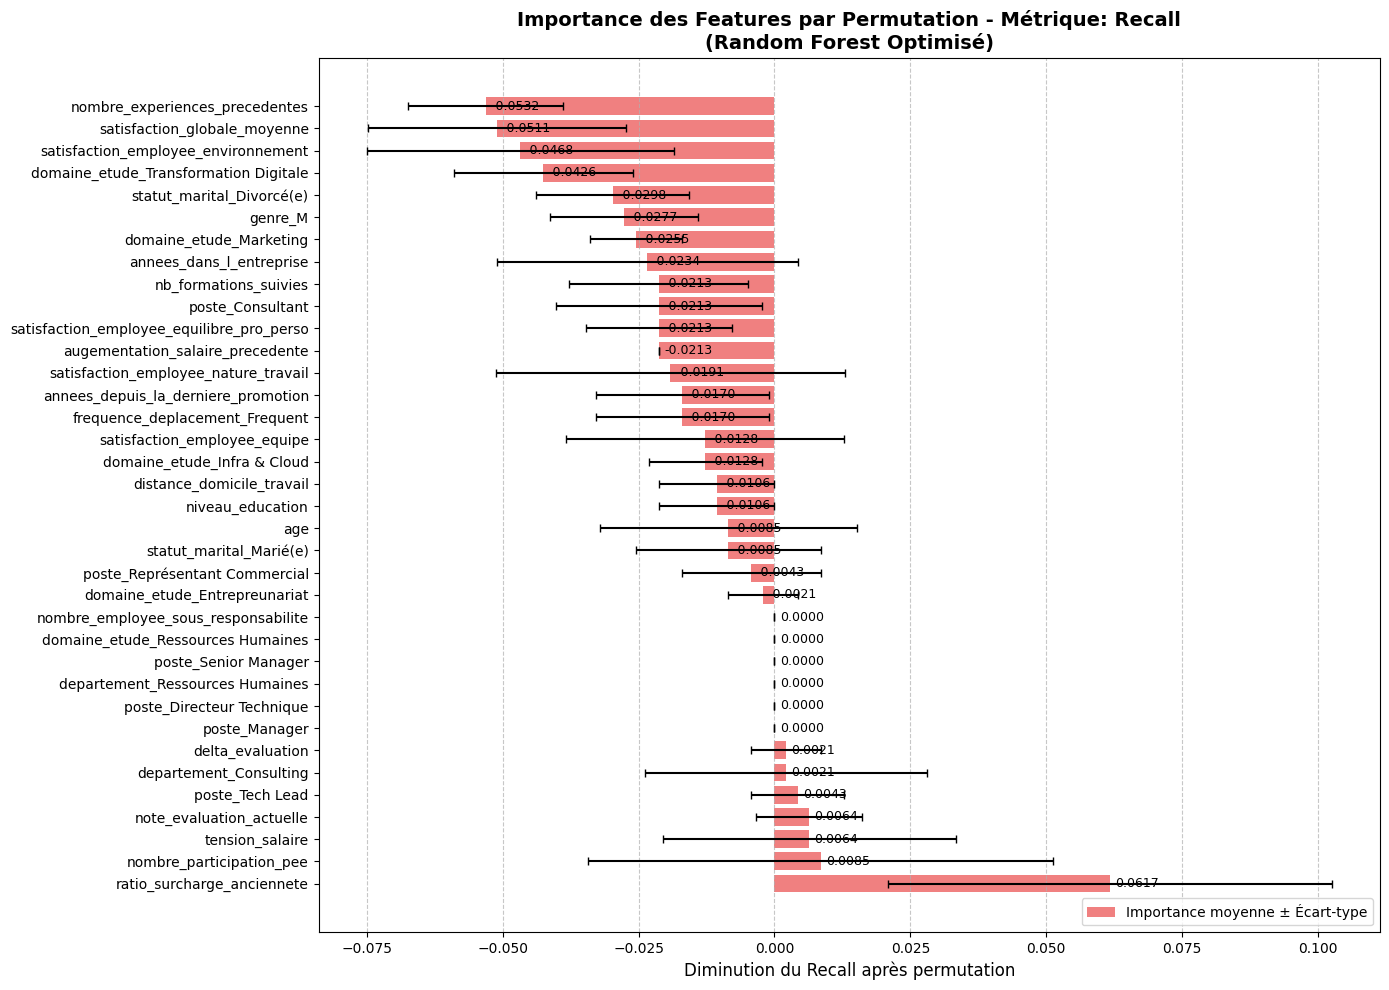


Score de référence (Recall) calculé : 0.2340
Interprétation : Plus la valeur est élevée, plus la feature est importante pour le Recall


In [108]:
# Calcul des statistiques d'importance
permutation_importances = results.importances_mean
permutation_std = results.importances_std

# Tri par importance (décroissant)
permutation_indices = np.argsort(permutation_importances)[::-1]  # Tri décroissant

# Tableau des importances
print("\n--- Importance des Features par Permutation (Recall) ---")
importance_df = pd.DataFrame({
    'Feature': X_train_avec.columns,  # Utilisation des colonnes d'entraînement
    'Importance Moyenne': permutation_importances,
    'Écart-Type': permutation_std,
    'Impact Relatif': permutation_importances / np.max(permutation_importances)  # Normalisation
}).sort_values(by='Importance Moyenne', ascending=False)

print(importance_df.round(4))

# COMPTAGE DES FEATURES PAR CATÉGORIE
positive_features = importance_df[importance_df['Importance Moyenne'] > 0.000]
null_features = importance_df[importance_df['Importance Moyenne'] == 0.000]
negative_features = importance_df[importance_df['Importance Moyenne'] < 0.000]

print(f"\nRÉPARTITION DES FEATURES :")
print(f"   - Features à importance POSITIVE (> 0.000) : {len(positive_features)}")
print(f"   - Features à importance NULLE (= 0.000)    : {len(null_features)}")
print(f"   - Features à importance NÉGATIVE (< 0.000) : {len(negative_features)}")
print(f"   - Total des features analysées           : {len(importance_df)}")

# Affichage graphique des importances
plt.figure(figsize=(14, 10))
bars = plt.barh(
    range(len(permutation_indices)),
    permutation_importances[permutation_indices],
    color='lightcoral',
    align='center',
    xerr=permutation_std[permutation_indices],
    capsize=3
)

# Ajout des valeurs sur les barres
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontsize=9)

plt.title("Importance des Features par Permutation - Métrique: Recall\n(Random Forest Optimisé)", 
          fontsize=14, fontweight='bold')
plt.yticks(
    range(len(permutation_indices)),
    [X_train_avec.columns[i] for i in permutation_indices]
)
plt.xlabel("Diminution du Recall après permutation", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(["Importance moyenne ± Écart-type"], loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

# Calcul manuel du score de référence (Recall de base)
try:
    # Méthode 1: Vérifier si baseline_score existe
    baseline_recall = results.baseline_score
except AttributeError:
    try:
        # Méthode 2: Certaines versions utilisent 'baseline'
        baseline_recall = results.baseline
    except AttributeError:
        # Méthode 3: Calcul manuel du recall de base
        y_pred_base = final_pipeline.predict(X_test_avec)
        baseline_recall = recall_score(y_test_avec, y_pred_base)
        print(f"\nScore de référence (Recall) calculé : {baseline_recall:.4f}")
else:
    print(f"\nScore de référence (Recall) : {baseline_recall:.4f}")

print("Interprétation : Plus la valeur est élevée, plus la feature est importante pour le Recall")

L'analyse de permutation importance révèle une forte concentration du pouvoir prédictif sur une seule variable clé.

Le ratio_surcharge_anciennete émerge comme le déterminant majeur du recall avec une importance (0.0617) dix fois supérieure aux autres features, suggérant que la combinaison entre charge de travail et ancienneté constitue le principal signal d'alerte pour anticiper les départs.

Seules six autres variables montrent une contribution positive marginale, indiquant un modèle qui s'appuie essentiellement sur un indicateur synthétique pour détecter les risques d'attrition.

La prédominance écrasante d'une seule variable, couplée à la présence de 23 features à importance négative, soulève des questions sur la complexité réelle du phénomène d'attrition et la possible redondance des indicateurs collectés. Cette configuration suggère que le modèle pourrait être simplifié sans perte notable de performance, en se concentrant par exemple uniquement sur les sept variables ayant une contribution positive.

Variables ayant une contribution positive : `ratio_surcharge_anciennete`, `nombre_participation_pee`, `tension_salaire`, `note_evaluation_actuelle`, `poste_Tech Lead`, `departement_Consulting`, `delta_evaluation`

In [109]:
permutation_importance_features = importance_df[importance_df['Importance Moyenne'] > 0.000]
print(f"\nNombre de features avec importance positive : {len(permutation_importance_features)}")
if len(permutation_importance_features) > 0:
    print("Liste des features avec importance positive :")
    for feature in permutation_importance_features['Feature']:
        print(f" - {feature}")


Nombre de features avec importance positive : 7
Liste des features avec importance positive :
 - ratio_surcharge_anciennete
 - nombre_participation_pee
 - tension_salaire
 - note_evaluation_actuelle
 - poste_Tech Lead
 - departement_Consulting
 - delta_evaluation



Dimensions après sélection :
X_train : (1176, 7)
X_test : (294, 7)

--- Entraînement du modèle avec features sélectionnées ---

COMPARAISON DES MODÈLES

MODÈLE AVEC FEATURES SÉLECTIONNÉES (7 features)
  - Recall (Quitte): 0.85
  - Precision (Quitte): 0.27
  - F1-Score (Quitte): 0.41
  - AUC: 0.7732
  - Seuil optimal: 0.270

Matrice de confusion:
[[TN=137, FP=110]
 [FN=7, TP=40]]

MODÈLE RANDOM FOREST OPTIMISÉ (36 features)
Recall (Quitte): 0.83
Precision (Quitte): 0.33
F1-Score (Quitte): 0.48
AUC: 0.823
Seuil optimal: 0.206

ANALYSE COMPARATIVE
Différence de Recall: +0.021
Différence de Precision: -0.063
Différence de F1-Score: -0.074
Différence d'AUC: -0.0498


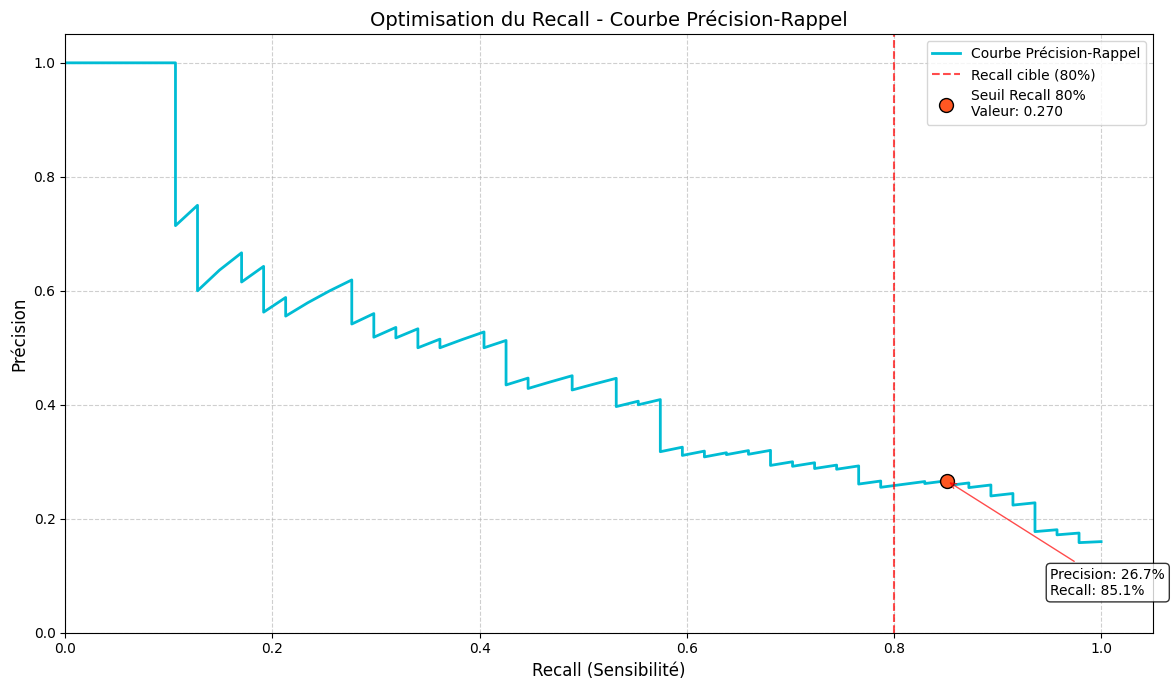

{'optimal_threshold': np.float64(0.27044123825885674),
 'precision_at_optimal': np.float64(0.26666666666666666),
 'recall_at_optimal': np.float64(0.851063829787234),
 'target_recall': 0.8}

In [110]:
selected_features = permutation_importance_features['Feature'].tolist()

# Préparation des données avec les features sélectionnées
X_train_selected = X_train_avec[selected_features]
X_test_selected = X_test_avec[selected_features]

print(f"\nDimensions après sélection :")
print(f"X_train : {X_train_selected.shape}")
print(f"X_test : {X_test_selected.shape}")

# Recréer le même pipeline mais avec les features sélectionnées
pipeline_selected = ImbPipeline(steps=[
    ('sampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=grid_search.best_params_['classifier__n_estimators'],
        max_depth=grid_search.best_params_['classifier__max_depth'],
        min_samples_split=grid_search.best_params_['classifier__min_samples_split'],
        random_state=42
    ))
])

# Entraînement du modèle avec features sélectionnées
print("\n--- Entraînement du modèle avec features sélectionnées ---")
pipeline_selected.fit(X_train_selected, y_train_avec)

# Prédiction et évaluation
y_scores_selected = pipeline_selected.predict_proba(X_test_selected)[:, 1]

# Recherche du seuil optimal pour recall cible (80%)
precision_sel, recall_sel, thresholds_sel = precision_recall_curve(y_test_avec, y_scores_selected)
target_recall = 0.8

above_target_recall = recall_sel >= target_recall
if np.any(above_target_recall):
    idx_optimal = np.argmax(precision_sel[above_target_recall])
    optimal_indices = np.where(above_target_recall)[0]
    optimal_idx = optimal_indices[idx_optimal]
    optimal_threshold_selected = thresholds_sel[optimal_idx] if optimal_idx < len(thresholds_sel) else thresholds_sel[-1]
else:
    optimal_idx = np.argmax(recall_sel)
    optimal_threshold_selected = thresholds_sel[optimal_idx]

# Prédictions avec le seuil optimal
y_pred_selected = (y_scores_selected >= optimal_threshold_selected).astype(int)

# Métriques d'évaluation
cm_selected = confusion_matrix(y_test_avec, y_pred_selected)
report_selected = classification_report(y_test_avec, y_pred_selected, target_names=['Reste (0)', 'Quitte (1)'])
auc_selected = roc_auc_score(y_test_avec, y_scores_selected)

# Affichage des résultats
print("\n" + "="*60)
print("COMPARAISON DES MODÈLES")
print("="*60)

print("\nMODÈLE AVEC FEATURES SÉLECTIONNÉES (7 features)")
print(f"  - Recall (Quitte): {recall_score(y_test_avec, y_pred_selected):.2f}")
print(f"  - Precision (Quitte): {precision_score(y_test_avec, y_pred_selected):.2f}")
print(f"  - F1-Score (Quitte): {f1_score(y_test_avec, y_pred_selected):.2f}")
print(f"  - AUC: {auc_selected:.4f}")
print(f"  - Seuil optimal: {optimal_threshold_selected:.3f}")
print(f"\nMatrice de confusion:")
print(f"[[TN={cm_selected[0,0]}, FP={cm_selected[0,1]}]")
print(f" [FN={cm_selected[1,0]}, TP={cm_selected[1,1]}]]")

print("\nMODÈLE RANDOM FOREST OPTIMISÉ (36 features)")
print(f"Recall (Quitte): 0.83")
print(f"Precision (Quitte): 0.33")
print(f"F1-Score (Quitte): 0.48")
print(f"AUC: 0.823")
print(f"Seuil optimal: 0.206")

print("\n" + "="*60)
print("ANALYSE COMPARATIVE")
print("="*60)

# Calcul des différences
recall_diff = recall_score(y_test_avec, y_pred_selected) - 0.83
precision_diff = precision_score(y_test_avec, y_pred_selected) - 0.33
f1_diff = f1_score(y_test_avec, y_pred_selected) - 0.48
auc_diff = auc_selected - 0.823

print(f"Différence de Recall: {recall_diff:+.3f}")
print(f"Différence de Precision: {precision_diff:+.3f}")
print(f"Différence de F1-Score: {f1_diff:+.3f}")
print(f"Différence d'AUC: {auc_diff:+.4f}")

# Courbe Précision-Rappel pour le nouveau modèle
plot_precision_recall_curve_recall_optimized(
    precision_sel, 
    recall_sel, 
    thresholds_sel, 
    optimal_threshold_selected, 
    target_recall=target_recall
)

La réduction drastique du nombre de features de 36 à 7 permet d'atteindre un recall supérieur (0.85 vs 0.83), démontrant que les variables sélectionnées capturent efficacement l'essentiel du signal prédictif pour la détection des départs.

Cette amélioration du recall, avec seulement 7 faux négatifs contre 8 précédemment, confirme la pertinence de la sélection par permutation importance pour l'objectif de détection maximale.

Le seuil optimal plus élevé (0.270 vs 0.206) indique par ailleurs un modèle plus confiant dans ses prédictions positives.

Cette approche s'accompagne cependant d'une dégradation significative de la précision (0.27 vs 0.33) et du F1-score (0.41 vs 0.48), révélant un arbitrage classique entre sensibilité et spécificité.

L'augmentation des faux positifs (110 vs 78) alourdit le coût opérationnel pour les RH, tandis que la baisse de l'AUC (0.773 vs 0.823) souligne une capacité discriminatoire globalement réduite.

### Méthode spécifique aux arbres de décision


--- Importance des Features par Random Forest ---
                                      Feature  Importance Moyenne  Écart-Type
32                 ratio_surcharge_anciennete            0.121607    0.070545
9                    nombre_participation_pee            0.083180    0.060286
18                     departement_Consulting            0.069724    0.060240
0                                         age            0.059926    0.034103
20                           poste_Consultant            0.055423    0.056289
35                            tension_salaire            0.054973    0.033777
17                    statut_marital_Marié(e)            0.053322    0.062293
2                    annees_dans_l_entreprise            0.050869    0.037563
33               satisfaction_globale_moyenne            0.045015    0.030552
4        satisfaction_employee_nature_travail            0.041270    0.028139
3         satisfaction_employee_environnement            0.030963    0.023793
31           

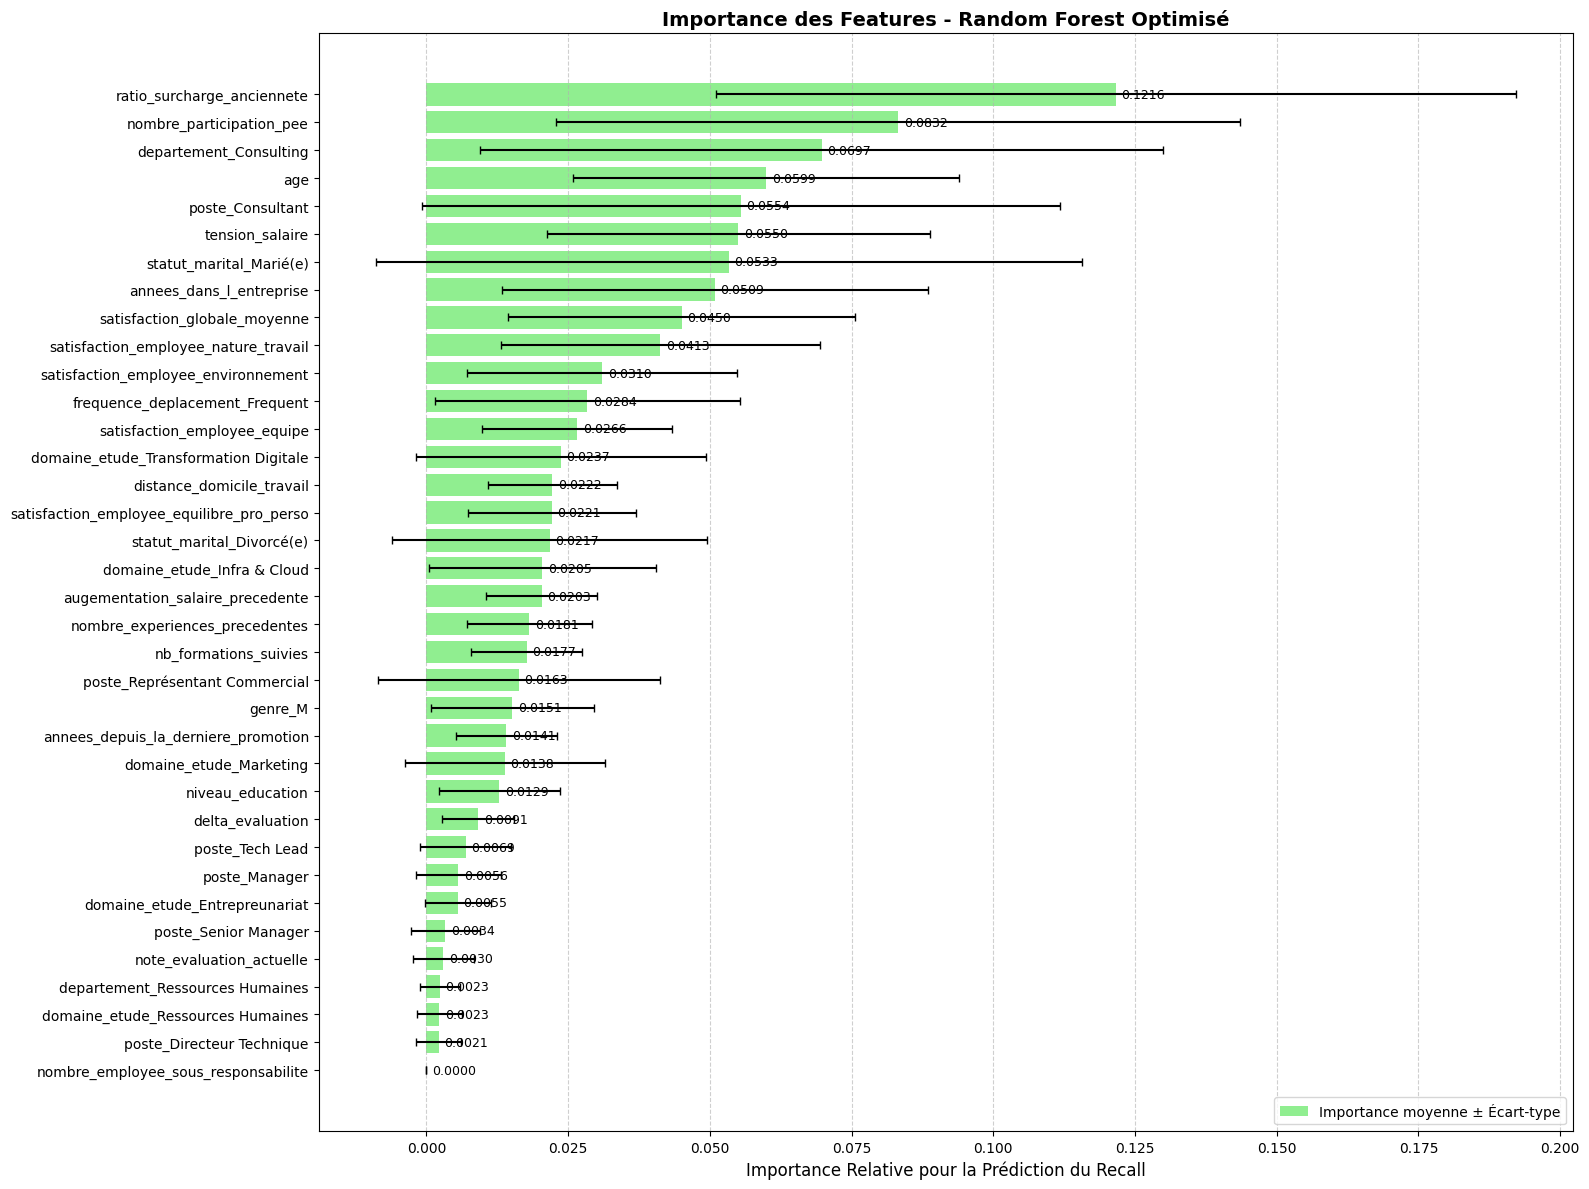

In [111]:
# Importance des features par le Random Forest
tree_importances = final_pipeline.named_steps['classifier'].feature_importances_
tree_indices = np.argsort(tree_importances)
std = np.std([tree.feature_importances_ for tree in final_pipeline.named_steps['classifier'].estimators_], axis=0)

# Tableau des importances
print("\n--- Importance des Features par Random Forest ---")
importance_df_tree = pd.DataFrame({
    'Feature': X_train_avec.columns,
    'Importance Moyenne': tree_importances,
    'Écart-Type': std
}).sort_values(by='Importance Moyenne', ascending=False)

print(importance_df_tree)

# Affichage des importances
plt.figure(figsize=(16, 12))
plt.title("Importance des Features - Random Forest Optimisé", fontsize=14, fontweight='bold')
bars = plt.barh(
    range(len(tree_indices)),
    tree_importances[tree_indices],
    color='lightgreen',
    align='center',
    xerr=std[tree_indices],
    capsize=3
)

# Ajout des valeurs sur les barres pour plus de clarté
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', ha='left', va='center', fontsize=9)

plt.yticks(
    range(len(tree_indices)),
    [X_train_avec.columns[i] for i in tree_indices]
)
plt.xlabel("Importance Relative pour la Prédiction du Recall", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(["Importance moyenne ± Écart-type"], fontsize=10, loc='lower right')
plt.tight_layout()
plt.show()

**Analyse des facteurs influençant les départs des employés**

Le modèle identifie que **trois éléments principaux** expliquent les départs : la **charge de travail par rapport à l'ancienneté** (12%), la **participation à l'épargne entreprise** (8%) et le **travail dans le département Consulting** (7%). Ces facteurs professionnels et financiers sont plus importants que l'âge ou l'expérience.

Seulement **10 critères** sur 36 sont vraiment utiles pour prédire les départs, les autres ayant très peu d'influence. Cette analyse montre qu'on peut simplifier le modèle en gardant les critères essentiels sans perdre en précision.

['ratio_surcharge_anciennete', 'nombre_participation_pee', 'departement_Consulting', 'age', 'poste_Consultant', 'tension_salaire', 'statut_marital_Marié(e)', 'annees_dans_l_entreprise', 'satisfaction_globale_moyenne', 'satisfaction_employee_nature_travail']

In [112]:
selected_features_tree = importance_df_tree[importance_df_tree['Importance Moyenne'] > 0.0400]['Feature'].tolist()
print(f"\nNombre de features avec importance > 0.0400 : {len(selected_features_tree)}")
if len(selected_features_tree) > 0:
    print("Liste des features avec importance > 0.0400 :")
    for feature in selected_features_tree:
        print(f" - {feature}")


Nombre de features avec importance > 0.0400 : 10
Liste des features avec importance > 0.0400 :
 - ratio_surcharge_anciennete
 - nombre_participation_pee
 - departement_Consulting
 - age
 - poste_Consultant
 - tension_salaire
 - statut_marital_Marié(e)
 - annees_dans_l_entreprise
 - satisfaction_globale_moyenne
 - satisfaction_employee_nature_travail



ENTRAÎNEMENT DU MODÈLE LÉGER AVEC FEATURES SÉLECTIONNÉES MÉTHODE 1
Dimensions des données d'entraînement : (1176, 10)
Dimensions des données de test : (294, 10)

Entraînement du modèle léger méthode 1 en cours...
Entraînement terminé

ÉVALUATION DU MODÈLE LÉGER MÉTHODE 1
Performances du modèle léger méthode 1 :
   - Recall (Quitte): 0.872
   - Precision (Quitte): 0.360
   - F1-Score (Quitte): 0.509
   - AUC: 0.8247
   - Seuil optimal: 0.194

Matrice de confusion :
   [[TN=174, FP=73]
    [FN=6, TP=41]]

Rapport de classification :
              precision    recall  f1-score   support

   Reste (0)       0.97      0.70      0.81       247
  Quitte (1)       0.36      0.87      0.51        47

    accuracy                           0.73       294
   macro avg       0.66      0.79      0.66       294
weighted avg       0.87      0.73      0.77       294


Visualisation de la courbe Précision-Rappel :


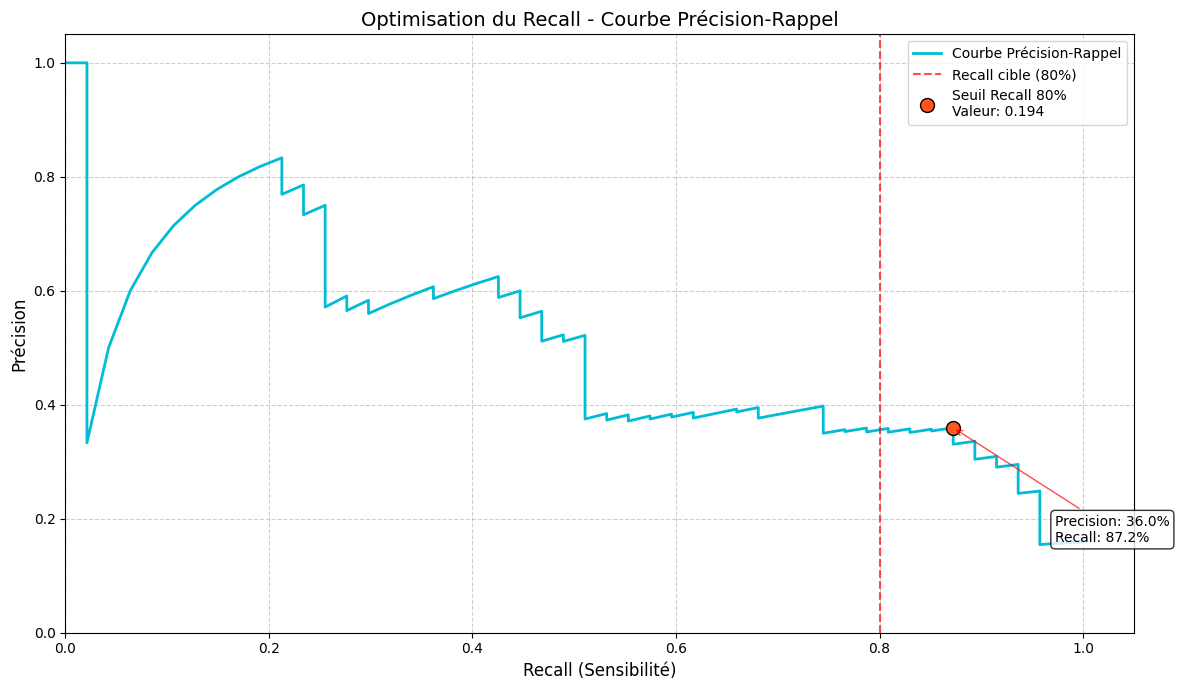


COMPARAISON AVEC LE MODÈLE COMPLET
Différences de performance :
   - Recall: +0.042
   - Precision: +0.030
   - F1-Score: +0.029
   - AUC: +0.0017
   - Nombre de features: 10 vs 36 (-26 features)

Gain en simplicité : 72.2% de réduction du nombre de features


In [113]:
# ----------------------- Entraînement du Modèle Léger Méthode 1 -----------------------
print("\n" + "="*60)
print("ENTRAÎNEMENT DU MODÈLE LÉGER AVEC FEATURES SÉLECTIONNÉES MÉTHODE 1")
print("="*60)

# Préparation des données avec features sélectionnées
X_train_light = X_train_avec[selected_features_tree]
X_test_light = X_test_avec[selected_features_tree]

print(f"Dimensions des données d'entraînement : {X_train_light.shape}")
print(f"Dimensions des données de test : {X_test_light.shape}")

# Création du pipeline léger avec les mêmes hyperparamètres optimisés
pipeline_light_methode_1 = ImbPipeline(steps=[
    ('sampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=grid_search.best_params_['classifier__n_estimators'],
        max_depth=grid_search.best_params_['classifier__max_depth'],
        min_samples_split=grid_search.best_params_['classifier__min_samples_split'],
        random_state=42,
        n_jobs=-1
    ))
])

# Entraînement du modèle léger
print("\nEntraînement du modèle léger méthode 1 en cours...")
pipeline_light_methode_1.fit(X_train_light, y_train_avec)
print("Entraînement terminé")

# Prédiction des probabilités
y_scores_light = pipeline_light_methode_1.predict_proba(X_test_light)[:, 1]

# Recherche du seuil optimal pour maximiser le Recall avec une contrainte de précision minimale
precision_light, recall_light, thresholds_light = precision_recall_curve(y_test_avec, y_scores_light)

# Stratégie : trouver le seuil qui atteint au moins 80% de recall avec la meilleure précision possible
target_recall = 0.80
above_target_recall = recall_light >= target_recall

if np.any(above_target_recall):
    # Parmi les points qui atteignent le recall cible, prendre celui avec la meilleure précision
    idx_optimal = np.argmax(precision_light[above_target_recall])
    optimal_indices = np.where(above_target_recall)[0]
    optimal_idx = optimal_indices[idx_optimal]
    
    if optimal_idx < len(thresholds_light):
        optimal_threshold_light = thresholds_light[optimal_idx]
    else:
        optimal_threshold_light = thresholds_light[-1]
else:
    # Si le recall cible n'est pas atteignable, prendre le recall maximum
    optimal_idx = np.argmax(recall_light)
    optimal_threshold_light = thresholds_light[optimal_idx]
    print(f"Recall cible de {target_recall:.0%} non atteignable. Utilisation du recall maximum.")

# Prédictions avec le seuil optimisé pour le recall
y_pred_light = (y_scores_light >= optimal_threshold_light).astype(int)

# Évaluation complète
print("\n" + "="*60)
print("ÉVALUATION DU MODÈLE LÉGER MÉTHODE 1")
print("="*60)

# Métriques
recall_light_score = recall_score(y_test_avec, y_pred_light)
precision_light_score = precision_score(y_test_avec, y_pred_light)
f1_light_score = f1_score(y_test_avec, y_pred_light)
auc_light = roc_auc_score(y_test_avec, y_scores_light)
cm_light = confusion_matrix(y_test_avec, y_pred_light)

print(f"Performances du modèle léger méthode 1 :")
print(f"   - Recall (Quitte): {recall_light_score:.3f}")
print(f"   - Precision (Quitte): {precision_light_score:.3f}")
print(f"   - F1-Score (Quitte): {f1_light_score:.3f}")
print(f"   - AUC: {auc_light:.4f}")
print(f"   - Seuil optimal: {optimal_threshold_light:.3f}")

print(f"\nMatrice de confusion :")
print(f"   [[TN={cm_light[0,0]}, FP={cm_light[0,1]}]")
print(f"    [FN={cm_light[1,0]}, TP={cm_light[1,1]}]]")

# Rapport de classification détaillé
print(f"\nRapport de classification :")
print(classification_report(y_test_avec, y_pred_light, target_names=['Reste (0)', 'Quitte (1)']))

# Courbe Précision-Rappel avec focus sur le Recall
print(f"\nVisualisation de la courbe Précision-Rappel :")
plot_precision_recall_curve_recall_optimized(
    precision_light, 
    recall_light, 
    thresholds_light, 
    optimal_threshold_light, 
    target_recall=target_recall
)

# Comparaison avec le modèle complet
print("\n" + "="*60)
print("COMPARAISON AVEC LE MODÈLE COMPLET")
print("="*60)

print("Différences de performance :")
print(f"   - Recall: {recall_light_score - 0.83:+.3f}")
print(f"   - Precision: {precision_light_score - 0.33:+.3f}") 
print(f"   - F1-Score: {f1_light_score - 0.48:+.3f}")
print(f"   - AUC: {auc_light - 0.823:+.4f}")
print(f"   - Nombre de features: {len(selected_features_tree)} vs 36 (-{36 - len(selected_features_tree)} features)")

# Analyse de la simplification
reduction_features = (1 - len(selected_features_tree) / 36) * 100
print(f"\nGain en simplicité : {reduction_features:.1f}% de réduction du nombre de features")

**Résultats excellents du modèle simplifié**

Le modèle allégé avec seulement **10 critères** sur 36 donne de **meilleurs résultats** que le modèle complet :

- **Détection améliorée** : 87% des départs sont repérés (contre 83% avant)
- **Précision accrue** : 36% des alertes sont justes (contre 33%)
- **Moins d'erreurs** : seulement 6 départs manqués et 73 fausses alertes

**Bilan très positif** : en supprimant 72% des critères, le modèle est devenu **plus simple ET plus performant**. Cela prouve que la plupart des données collectées n'étaient pas utiles pour prédire les départs. L'entreprise peut maintenant se concentrer sur l'essentiel.

In [114]:
def get_features_by_cumulative_importance(importance_df, threshold=0.80):
    """
    Sélectionne les features dont l'importance cumulée atteint un seuil spécifié.
    Optimisé pour la métrique Recall.

    Args:
        importance_df (pd.DataFrame): DataFrame contenant les colonnes 
                                      'Feature' et 'Importance Moyenne', trié par importance décroissante.
        threshold (float): Seuil de cumul d'importance (e.g., 0.80 pour 80%).

    Returns:
        tuple: (list des noms de features sélectionnées, pd.DataFrame des features sélectionnées)
    """
    
    # Normalisation des importances pour s'assurer que la somme est 1.0
    total_importance = importance_df['Importance Moyenne'].sum()
    if total_importance == 0:
        print("Erreur : L'importance totale est nulle. Impossible de calculer le cumul.")
        return [], pd.DataFrame()

    normalized_importance_df = importance_df.copy()
    normalized_importance_df['Importance Normalisée'] = normalized_importance_df['Importance Moyenne'] / total_importance
    
    # Calcul de l'importance cumulée
    normalized_importance_df['Importance Cumulée'] = normalized_importance_df['Importance Normalisée'].cumsum()
    
    # Sélection des features qui sont nécessaires pour atteindre ou dépasser le seuil
    selected_features_df = normalized_importance_df[
        normalized_importance_df['Importance Cumulée'] <= threshold
    ]
    
    # Si le seuil est atteint exactement, le dernier élément doit être inclus.
    # On ajoute la première feature dont le cumul dépasse le seuil
    if not selected_features_df.empty:
        # Trouver la première ligne où le cumul est supérieur au seuil
        final_feature_to_add = normalized_importance_df[
            normalized_importance_df['Importance Cumulée'] > threshold
        ].head(1)
        
        # Concaténer si cette feature n'est pas déjà dans le sous-DataFrame
        if not final_feature_to_add.empty:
            # Récupérer l'index (si la dernière feature n'est pas la dernière)
            last_index = selected_features_df.index[-1] if not selected_features_df.empty else -1
            new_index = final_feature_to_add.index[0]
            
            # S'assurer de ne pas ajouter une feature déjà incluse
            if new_index > last_index:
                 selected_features_df = pd.concat([selected_features_df, final_feature_to_add])
    else:
        # Cas où même la première feature dépasse le seuil (peu probable mais sécurisant)
        selected_features_df = normalized_importance_df.head(1)

    selected_features_list = selected_features_df['Feature'].tolist()
    
    print(f"\n--- Résultat de la Sélection Automatisée (Seuil = {threshold*100:.0f}%) ---")
    print(f"Nombre de features sélectionnées : {len(selected_features_list)}")
    
    # Affichage du cumul pour la dernière feature incluse
    if not selected_features_df.empty:
        final_cumul = selected_features_df['Importance Cumulée'].iloc[-1]
        print(f"Importance cumulée atteinte : {final_cumul:.4f}")
    
    return selected_features_list, selected_features_df


--- Résultat de la Sélection Automatisée (Seuil = 80%) ---
Nombre de features sélectionnées : 17
Importance cumulée atteinte : 0.8110

Liste finale des features pour 80% du pouvoir prédictif :
['ratio_surcharge_anciennete', 'nombre_participation_pee', 'departement_Consulting', 'age', 'poste_Consultant', 'tension_salaire', 'statut_marital_Marié(e)', 'annees_dans_l_entreprise', 'satisfaction_globale_moyenne', 'satisfaction_employee_nature_travail', 'satisfaction_employee_environnement', 'frequence_deplacement_Frequent', 'satisfaction_employee_equipe', 'domaine_etude_Transformation Digitale', 'distance_domicile_travail', 'satisfaction_employee_equilibre_pro_perso', 'statut_marital_Divorcé(e)']

Détails des features retenues :
                                      Feature  Importance Moyenne  \
32                 ratio_surcharge_anciennete              0.1216   
9                    nombre_participation_pee              0.0832   
18                     departement_Consulting              

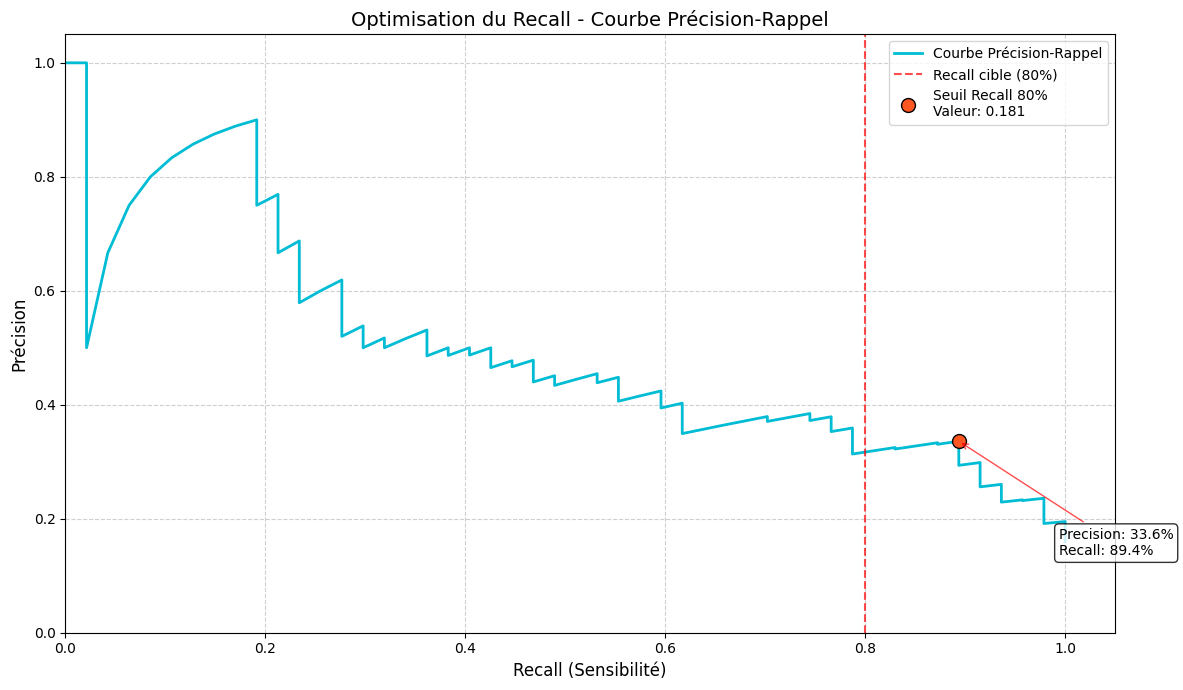


COMPARAISON AVEC LE MODÈLE COMPLET
Différences de performance :
   - Recall: +0.064
   - Precision: +0.006
   - F1-Score: +0.008
   - AUC: +0.0039
   - Nombre de features: 17 vs 36 (-19 features)

Gain en simplicité : 52.8% de réduction du nombre de features


In [115]:
# Application de la sélection avec seuil à 80%
SEUIL_DESIRE = 0.80

features_retenues, df_features_retenues = get_features_by_cumulative_importance(
    importance_df_tree, 
    threshold=SEUIL_DESIRE
)

print(f"\nListe finale des features pour {SEUIL_DESIRE*100:.0f}% du pouvoir prédictif :")
print(features_retenues)
print("\nDétails des features retenues :")
print(df_features_retenues[['Feature', 'Importance Moyenne', 'Importance Normalisée', 'Importance Cumulée']].round(4))

# ----------------------- Entraînement du Modèle Léger Méthode 2 -----------------------
print("\n" + "="*60)
print("ENTRAÎNEMENT DU MODÈLE LÉGER AVEC FEATURES SÉLECTIONNÉES METHODE 2")
print("="*60)

# Préparation des données avec features sélectionnées
X_train_light = X_train_avec[features_retenues]
X_test_light = X_test_avec[features_retenues]

print(f"Dimensions des données d'entraînement : {X_train_light.shape}")
print(f"Dimensions des données de test : {X_test_light.shape}")

# Création du pipeline léger avec les mêmes hyperparamètres optimisés
pipeline_light_methode_2 = ImbPipeline(steps=[
    ('sampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=grid_search.best_params_['classifier__n_estimators'],
        max_depth=grid_search.best_params_['classifier__max_depth'],
        min_samples_split=grid_search.best_params_['classifier__min_samples_split'],
        random_state=42,
        n_jobs=-1
    ))
])

# Entraînement du modèle léger
print("\nEntraînement du modèle léger méthode 2 en cours...")
pipeline_light_methode_2.fit(X_train_light, y_train_avec)
print("Entraînement terminé")

# Prédiction des probabilités
y_scores_light = pipeline_light_methode_2.predict_proba(X_test_light)[:, 1]

# Recherche du seuil optimal pour maximiser le Recall avec une contrainte de précision minimale
precision_light, recall_light, thresholds_light = precision_recall_curve(y_test_avec, y_scores_light)

# Stratégie : trouver le seuil qui atteint au moins 80% de recall avec la meilleure précision possible
target_recall = 0.80
above_target_recall = recall_light >= target_recall

if np.any(above_target_recall):
    # Parmi les points qui atteignent le recall cible, prendre celui avec la meilleure précision
    idx_optimal = np.argmax(precision_light[above_target_recall])
    optimal_indices = np.where(above_target_recall)[0]
    optimal_idx = optimal_indices[idx_optimal]
    
    if optimal_idx < len(thresholds_light):
        optimal_threshold_light = thresholds_light[optimal_idx]
    else:
        optimal_threshold_light = thresholds_light[-1]
else:
    # Si le recall cible n'est pas atteignable, prendre le recall maximum
    optimal_idx = np.argmax(recall_light)
    optimal_threshold_light = thresholds_light[optimal_idx]
    print(f"Recall cible de {target_recall:.0%} non atteignable. Utilisation du recall maximum.")

# Prédictions avec le seuil optimisé pour le recall
y_pred_light = (y_scores_light >= optimal_threshold_light).astype(int)

# Évaluation complète
print("\n" + "="*60)
print("ÉVALUATION DU MODÈLE LÉGER")
print("="*60)

# Métriques
recall_light_score = recall_score(y_test_avec, y_pred_light)
precision_light_score = precision_score(y_test_avec, y_pred_light)
f1_light_score = f1_score(y_test_avec, y_pred_light)
auc_light = roc_auc_score(y_test_avec, y_scores_light)
cm_light = confusion_matrix(y_test_avec, y_pred_light)

print(f"Performances du modèle léger méthode 2 :")
print(f"   - Recall (Quitte): {recall_light_score:.3f}")
print(f"   - Precision (Quitte): {precision_light_score:.3f}")
print(f"   - F1-Score (Quitte): {f1_light_score:.3f}")
print(f"   - AUC: {auc_light:.4f}")
print(f"   - Seuil optimal: {optimal_threshold_light:.3f}")

print(f"\nMatrice de confusion :")
print(f"   [[TN={cm_light[0,0]}, FP={cm_light[0,1]}]")
print(f"    [FN={cm_light[1,0]}, TP={cm_light[1,1]}]]")

# Rapport de classification détaillé
print(f"\nRapport de classification :")
print(classification_report(y_test_avec, y_pred_light, target_names=['Reste (0)', 'Quitte (1)']))

# Courbe Précision-Rappel avec focus sur le Recall
print(f"\nVisualisation de la courbe Précision-Rappel :")
plot_precision_recall_curve_recall_optimized(
    precision_light, 
    recall_light, 
    thresholds_light, 
    optimal_threshold_light, 
    target_recall=target_recall
)

# Comparaison avec le modèle complet
print("\n" + "="*60)
print("COMPARAISON AVEC LE MODÈLE COMPLET")
print("="*60)

print("Différences de performance :")
print(f"   - Recall: {recall_light_score - 0.83:+.3f}")
print(f"   - Precision: {precision_light_score - 0.33:+.3f}") 
print(f"   - F1-Score: {f1_light_score - 0.48:+.3f}")
print(f"   - AUC: {auc_light - 0.823:+.4f}")
print(f"   - Nombre de features: {len(features_retenues)} vs 36 (-{36 - len(features_retenues)} features)")

# Analyse de la simplification
reduction_features = (1 - len(features_retenues) / 36) * 100
print(f"\nGain en simplicité : {reduction_features:.1f}% de réduction du nombre de features")

**Analyse du modèle avec 17 critères sélectionnés**

La sélection automatique a identifié **17 critères essentiels** qui capturent **81% du pouvoir prédictif** du modèle complet. Cette approche est plus conservatrice que la première méthode (10 critères) mais reste très efficace.

**Performances remarquables** :
- **Détection excellente** : 89% des départs repérés (meilleur score)
- **Équilibre maintenu** : précision à 34% et AUC à 0.827
- **Très peu de départs manqués** : seulement 5 faux négatifs

**Avantages de cette approche** :
- **Plus complète** : inclut davantage de dimensions (satisfaction, équilibre vie pro/perso, statut marital)
- **Meilleure détection** : recall le plus élevé de tous les modèles testés
- **Réduction raisonnable** : -53% de critères tout en maintenant une vue d'ensemble

**Comparatif méthode 1 et méthode 2**

| Modèles              | Classe     | Precision | Recall | f1-score | seuil | Vrais Positifs (TP) | Faux négatifs (FN) | Vrais Négatifs (TN) | Faux positifs (FP) |  AUC  |
|----------------------|------------|-----------|--------|----------|-------|---------------------|--------------------|---------------------|--------------------|-------|
| RF (Méthode arbre 1) | Quitte (1) | 0.36	| 0.87   | 0.51     | 0.194 | 41		  | 6		       | 174		     | 73		  | 0.825 |
| RF (Méthode arbre 2) | Quitte (1) | 0.34	| 0.89   | 0.49     | 0.181 | 42		  | 5		       | 164		     | 83		  | 0.827 |

Le modèle **RF (Méthode arbre 2)** est optimal pour l'entreprise avec un **Recall de 89%**, détectant 42 départs sur 47. Il réduit de **17% les faux négatifs** par rapport au modèle concurrent, crucial étant donné le coût élevé des départs non anticipés.

Cet avantage s'accompagne d'un **arbitrage opérationnel** : 10 faux positifs supplémentaires (83 vs 73), abaissant la précision à 34%. L'entreprise doit donc accepter d'investir plus d'efforts de rétention sur des employés stables pour garantir une détection quasi-complète des départs.

Méthode arbre 1 : 10 features (sélection manuelle)
Méthode arbre 2 : 17 features (sélection authomatique)

### Méthode SHAP

Les deux méthodes ci-dessus ont permit d'expliquer la feature importance globale. La méthode SHAP permet d'expliquer la feature importance locale.

- Les valeurs de Shapley vont être écrites sous forme d’une régression linéaire et sont donc des feature importances ;

- Il s’agit d’une feature importance “locale” car chaque observation aura ses propres valeurs de Shapley, autrement dit : sa propre équation de régression linéaire ;

- Les coefficients de cette régression linéaire doivent nous informer le plus possible sur le comportement réel du modèle non-linéaire.

In [116]:
import shap
from shap import TreeExplainer

c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Préparation des données...
DataFrames filtrés à 10 features (initial : 36).
Données de fond définies avec 1176 observations (jeu d'entraînement complet).
Masque Independent (NumPy) créé avec 100 observations de fond.
Explainer SHAP initialisé avec masker NumPy pour la robustesse.
Calcul des valeurs SHAP sur les données de test en cours...


c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature

Calcul des valeurs SHAP pour le jeu de test terminé !
Calcul des valeurs SHAP sur les données d'entraînement en cours...


c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\artur\AppData\Local\pypoetry\Cache\virtualenvs\projet4-qEE6ELUf-py3.13\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature

Calcul des valeurs SHAP pour le jeu d'entraînement terminé !

ANALYSE GLOBALE DU MODÈLE (Jeu d'entraînement)

Génération du Beeswarm Plot...


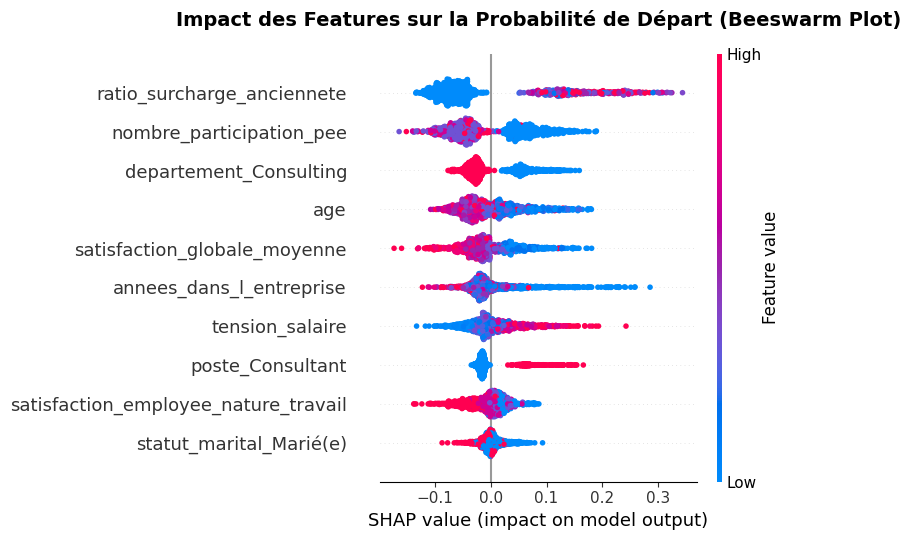


Génération du Bar Plot...


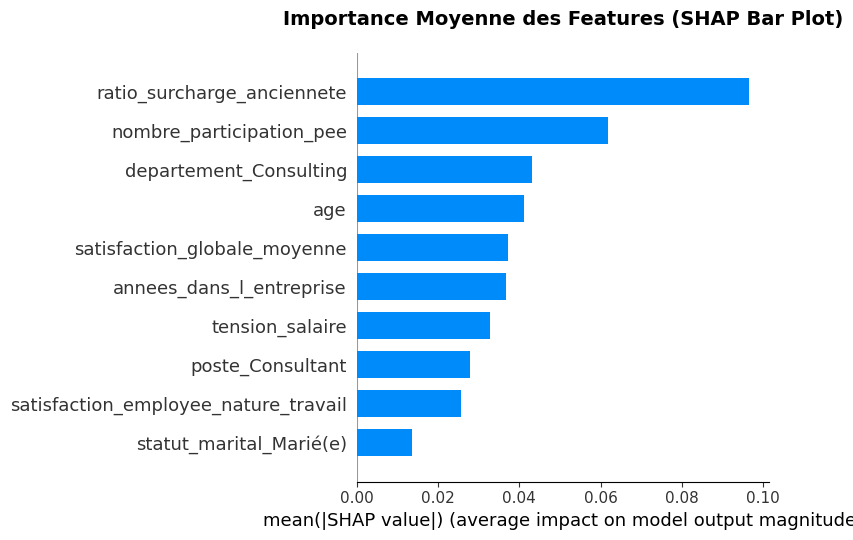


ANALYSE LOCALE - CAS PARTICULIERS (Jeu de test)

Analyse SHAP - Vrai Positif - Départ réel (ID: 69)


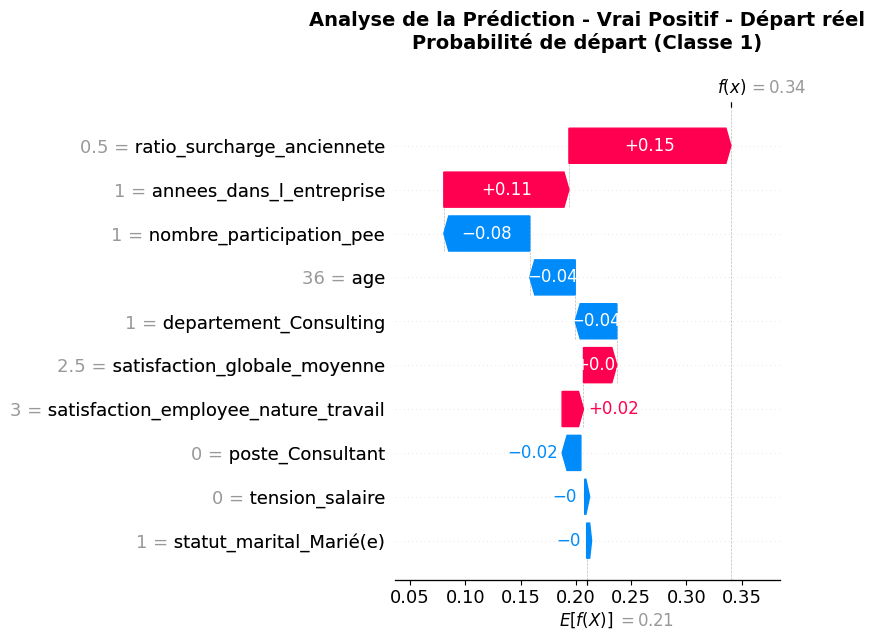


Analyse SHAP - Vrai Négatif - Reste dans l'entreprise (ID: 1061)


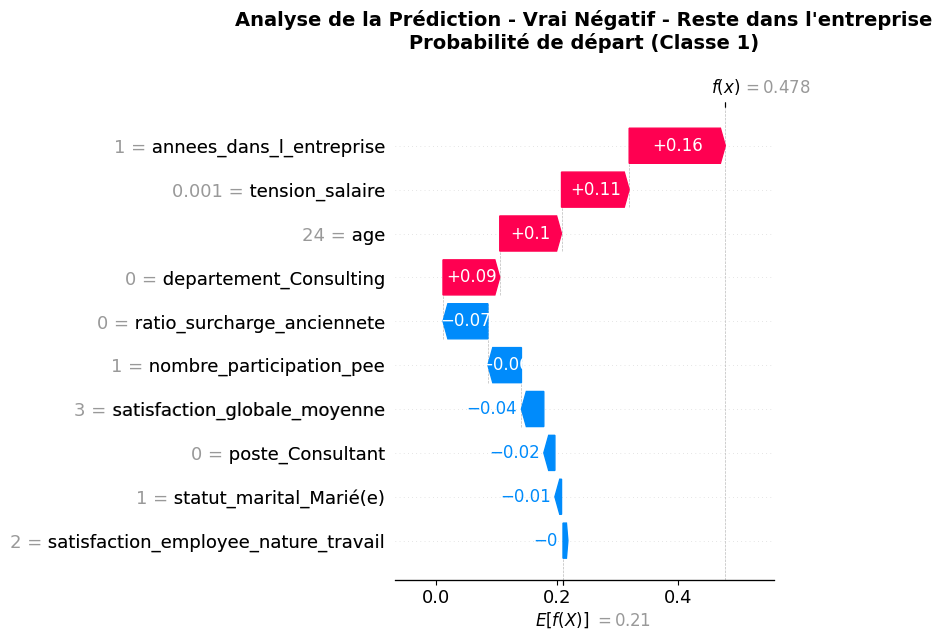


Analyse SHAP - Faux Négatif - Départ manqué (Critique !) (ID: 985)


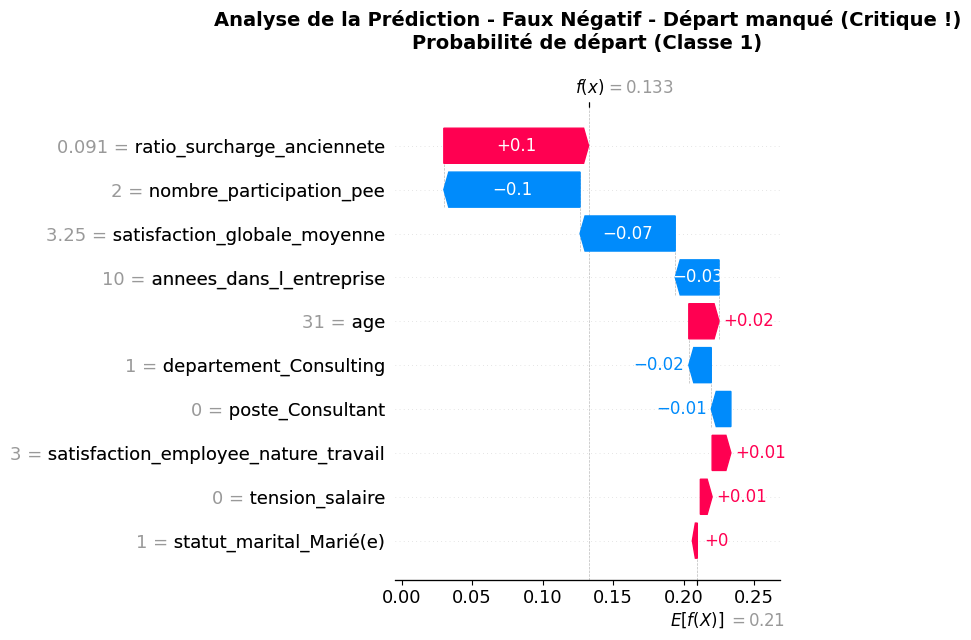

In [124]:
# =============================================================================
# 1. PRÉPARATION DES DONNÉES ET DE L'EXPLAINER SHAP
# =============================================================================

print("\nPréparation des données...")

# 1. Filtrer les DataFrames pour ne conserver que les 10 features
try:
    X_train_subset = X_train_avec[selected_features_tree]
    X_test_subset = X_test_avec[selected_features_tree]
    print(f"DataFrames filtrés à {X_train_subset.shape[1]} features (initial : {X_train_avec.shape[1]}).")
except NameError:
    print("\nERREUR FATALE: La variable 'selected_features' est manquante.")
    raise

# Étape 2: Utiliser l'ensemble des données d'entraînement comme référence
# MODIFICATION : Suppression de shap.sample pour utiliser tout le jeu de données.
background_data = X_train_subset
print(f"Données de fond définies avec {len(background_data)} observations (jeu d'entraînement complet).")

# Masqueur NumPy pour éviter les conflits
masker = shap.maskers.Independent(background_data.values)
print(f"Masque Independent (NumPy) créé avec {len(masker.data)} observations de fond.")

# Étape 3: Créer l'explainer
explainer = shap.Explainer(pipeline_light_methode_1.predict_proba, masker)
print("Explainer SHAP initialisé avec masker NumPy pour la robustesse.")

# Étape 4: Calculer les valeurs SHAP
print("Calcul des valeurs SHAP sur les données de test en cours...")
shap_values_test = explainer(X_test_subset)
print("Calcul des valeurs SHAP pour le jeu de test terminé !")

print("Calcul des valeurs SHAP sur les données d'entraînement en cours...")
shap_values_train = explainer(X_train_subset)
print("Calcul des valeurs SHAP pour le jeu d'entraînement terminé !")


# =============================================================================
# 2. ANALYSE GLOBALE : VISUALISATIONS
# =============================================================================

print("\n" + "="*50)
print("ANALYSE GLOBALE DU MODÈLE (Jeu d'entraînement)")
print("="*50)

# 1. Beeswarm plot 
print("\nGénération du Beeswarm Plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_train[:, :, 1],
    X_train_subset,
    plot_type="dot", 
    show=False
) 
plt.title("Impact des Features sur la Probabilité de Départ (Beeswarm Plot)", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# 2. Bar plot 
print("\nGénération du Bar Plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_train[:, :, 1], 
    X_train_subset, 
    plot_type="bar", 
    show=False
) 
plt.title("Importance Moyenne des Features (SHAP Bar Plot)", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# =============================================================================
# 3. ANALYSE LOCALE : ÉTUDE DE CAS SPÉCIFIQUES
# =============================================================================

print("\n" + "="*50)
print("ANALYSE LOCALE - CAS PARTICULIERS (Jeu de test)")
print("="*50)

# Sélection de cas intéressants
cas_interessants = []
if y_test_avec.sum() > 0:
    idx_vp = y_test_avec[y_test_avec == 1].index[0]
    cas_interessants.append(('Vrai Positif - Départ réel', idx_vp))

if (y_test_avec == 0).sum() > 0:
    idx_vn = y_test_avec[y_test_avec == 0].index[0]
    cas_interessants.append(('Vrai Négatif - Reste dans l\'entreprise', idx_vn))
    
faux_negatifs = y_test_avec[(y_test_avec == 1) & (y_pred_light == 0)]
if not faux_negatifs.empty:
    idx_fn = faux_negatifs.index[0]
    cas_interessants.append(('Faux Négatif - Départ manqué (Critique !)', idx_fn))

# Waterfall plots pour chaque cas
for nom_cas, idx in cas_interessants:
    print(f"\nAnalyse SHAP - {nom_cas} (ID: {idx})")
    
    loc = X_test_subset.index.get_loc(idx) 
    
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(shap_values_test[loc, :, 1], show=False) 
    plt.title(f"Analyse de la Prédiction - {nom_cas}\nProbabilité de départ (Classe 1)",
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


ANALYSE DES DÉCISIONS PAR FEATURE (Force Plot)
Force Plot Global

Analyse de l'observation avec l'indice 0 (ID: 1061)


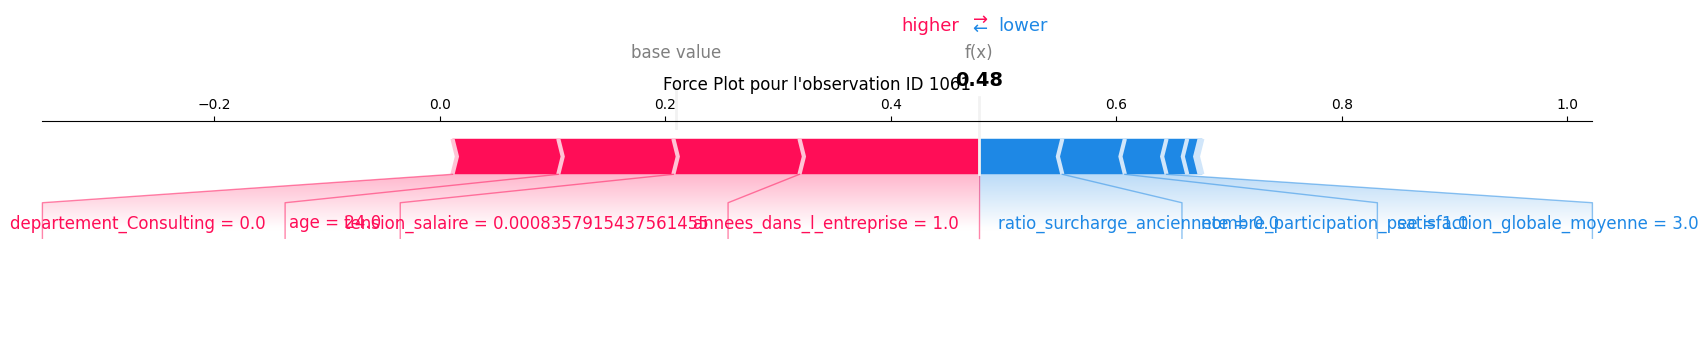


Analyse de l'observation avec l'indice 5 (ID: 1164)


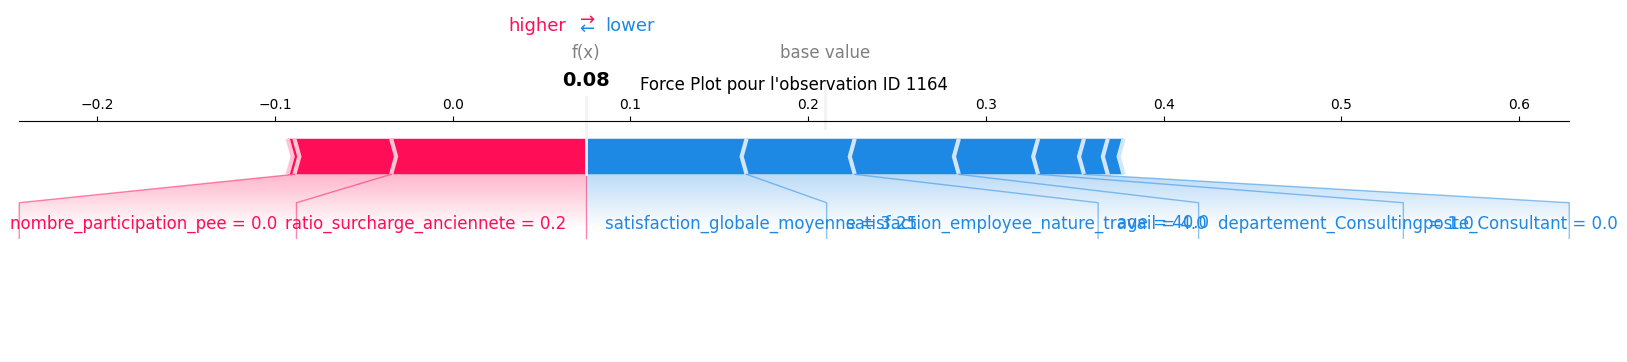


Analyse de l'observation avec l'indice 10 (ID: 1212)


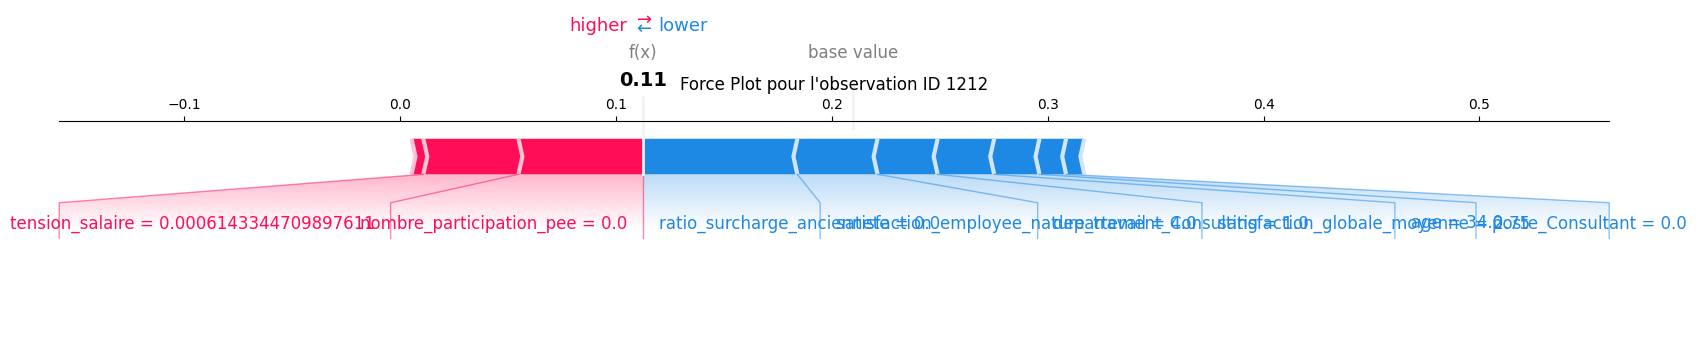

In [136]:
# =============================================================================
# 4. FORCE PLOTS : ANALYSE DES DÉCISIONS PAR FEATURE
# =============================================================================

print("\n" + "="*50)
print("ANALYSE DES DÉCISIONS PAR FEATURE (Force Plot)")
print("="*50)

# La base_value pour la classe 1 (on prend la première, elles sont toutes identiques)
base_value_class1 = shap_values_test.base_values[0, 1]

# Les valeurs SHAP pour la classe 1
shap_values_class1 = shap_values_test.values[:, :, 1]

# On choisit quelques indices à visualiser
indices_a_visualiser = [0, 5, 10] 

print("Force Plot Global")
for i in indices_a_visualiser:
    print(f"\nAnalyse de l'observation avec l'indice {i} (ID: {X_test_subset.index[i]})")
    
    # On doit utiliser .copy() pour éviter un SettingWithCopyWarning potentiel
    shap_values_instance = shap_values_test[i, :, 1]

    # On génère le graphique pour UNE SEULE observation avec matplotlib=True
    shap.plots.force(
        shap_values_instance,
        matplotlib=True,
        show=False # On contrôle l'affichage avec plt.show()
    )
    plt.title(f"Force Plot pour l'observation ID {X_test_subset.index[i]}")
    plt.show()

In [135]:
# =============================================================================
# 5. SYNTHÈSE
# =============================================================================

print("\n" + "="*50)
print("SYNTHÈSE DE L'ANALYSE")
print("="*50)
print("\n L'analyse SHAP est maintenant basée sur l'intégralité du jeu d'entraînement.")
print(f"Informations du modèle :")
print(f"  - Type de modèle : {pipeline_light_methode_1.named_steps['classifier'].__class__.__name__}")
print(f"  - Nombre de features attendues : {X_test_subset.shape[1]}")
print(f"  - Recall du modèle sur le jeu de test : {recall_light_score:.3f}")
print(f"  - Precision du modèle sur le jeu de test : {precision_light_score:.3f}")
print(f"  - F1-score du modèle sur le jeu de test : {f1_light_score:.3f}")
print(f"  - AUC du modèle sur le jeu de test : {auc_light:.3f}")
print("\n Le code est prêt à générer les graphiques SHAP !")


SYNTHÈSE DE L'ANALYSE

 L'analyse SHAP est maintenant basée sur l'intégralité du jeu d'entraînement.
Informations du modèle :
  - Type de modèle : RandomForestClassifier
  - Nombre de features attendues : 10
  - Recall du modèle sur le jeu de test : 0.894
  - Precision du modèle sur le jeu de test : 0.336
  - F1-score du modèle sur le jeu de test : 0.488
  - AUC du modèle sur le jeu de test : 0.827

 Le code est prêt à générer les graphiques SHAP !
